# $\textbf{Case Analysis including actions}$

This Covid explainer will walk you through how to run the MDP Algorithm on the code (in the version used by `covid_team2`). Everything you need to run the code should already be here in this folder, as the MDP algorithm was modified for Covid specifically. Relevant files in this directory include: 
* `mdp_model.py`
* `mdp_clustering.py`
* `mdp_testing.py`
* `mdp_tools.py`
* `states_combined_data.csv`**

** Note: some rows or columns have been taken out to create this sample dataset, to accomodate missing data in the original dataset. 

In [1]:
# Load Built-in Modules
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import seaborn as sns
import os
import matplotlib.pyplot as plt
import pickle

# Ignore Python package warnings (not verbose)
import warnings
warnings.filterwarnings("ignore")

In [2]:
# in-built library path

In [3]:
DIRECTORY_PATH = r"C:\Users\david\Desktop\MIT\Courses\Research internship\master_branch\covid19_team2\code"
os.chdir(DIRECTORY_PATH)

from mdp_states_functions import createSamples, fit_cv, fit_eval
from mdp_utils import initializeClusters, splitter
from mdp_testing import predict_cluster, predict_region_date, MDPPredictionError, MDPTrainingError
from mdp_testing import mape, plot_pred, plot_pred_action, plot_pred_fact
# Load MDP packages
import mdp_model as mdp
from mdp_states_functions import createSamples
from data_utils import (save_model, load_model, load_data, dict_to_df)
# from codes.utils import run_script # for multiprocessing

In [4]:
# experiment path & data path & result path

In [136]:
# MODEL_PATH = r"C:\Users\david\Desktop\MIT\Courses\Research internship\results\28 - 20201008 - mobility analysis"
MODEL_PATH = r"C:\Users\david\Desktop\MIT\Courses\Research internship\master_branch\covid19_team2\code\models"
DATA_PATH = r'C:\Users\david\Dropbox (MIT)\COVID-19-Team2\Data\08_15_2020_states_countries_combined_with_GooPCADavid.csv'
RESULT_PATH = r"C:\Users\david\Desktop\MIT\Courses\Research internship\results\28 - 20201008 - mobility analysis\results"

## $\textbf{Experiment descrition}$
### $\textbf{Sensitivity analysis of the (lagged)}$ `workplaces_percent_change_from_baseline_med` $\textbf{on the COVID-19 cases predictions}$

In the folllowing, we aimed to suggest different approaches for incorpating `ACTIONS` through a discretization on a mobility variable, in this case `workplaces_percent_change_from_baseline_med`.


We focused our attention on how the testing `MAPE` reacts to `two` specific features of the algorithm :

- ### `completion_algorithm`

This variable decides of the algorithm we used to predict for $\textbf{unobserved transitions}$. As of now, we have three different approaches : 
- `unbias_completion` (we set as the $\textbf{baseline}$) : we a kNN algorithm to 'predict' what could be a potential next cluster by training on observed actions (from different states). This way, we are complete the transition matrix.
- `bias_completion` : we used the same approach than the one described above, except that we are providing a prior information that : 
\begin{equation}
\begin{split}
\forall \, \text{actions} \, a_i, a_j \quad \mbox{and state} s,  \quad a_i < a_j \implies R(\operatorname{NextCluster}(s, a_i)) \leq R(\operatorname{NextCluster}(s, a_j))
\end{split}
\end{equation}
- `relative_completion` : we assumed that, for a given state, unobserved transactions provide the same next cluster that observed transition, up to an adjustment in the growth rate. 
In other words :
\begin{equation}
\begin{split}
\forall \, \text{actions} \, a_i, a_j \quad \mbox{and state} s \, & \mbox{ s.t. } \nexists \operatorname{NextCluster}(s, a_i) \mbox{ but } \exists \operatorname{NextCluster}(s, a_j) \\
& \implies \operatorname{NextCluster}(s, a_i) = \operatorname{NextCluster}(s, a_j) \\
& \implies R(\operatorname{NextCluster}(s, a_i)) = \alpha(a_i, a_j) R(\operatorname{NextCluster}(s, a_j))
\end{split}
\end{equation}

- ### `d_delay`
This variable account for lag in terms of days in the change variable before recording the action
In the following study, we considered `{0, 7, 14}`

In [6]:
validation_cutoff = '2020-08-10'
training_cutoff = '2020-07-21'
df, df_train, df_validation = load_data(file=DATA_PATH, 
                                        training_cutoff=training_cutoff, 
                                        validation_cutoff=validation_cutoff)
df.head()

Training set contains 63 state.


unnamed: 0    state       date  cases  deaths  population  emergdec  \
0           0  Alabama 2020-03-24    242       0   4903185.0       1.0   
1           1  Alabama 2020-03-25    381       1   4903185.0       1.0   
2           2  Alabama 2020-03-26    517       1   4903185.0       1.0   
3           3  Alabama 2020-03-27    587       4   4903185.0       1.0   
4           4  Alabama 2020-03-28    694       4   4903185.0       1.0   

   schoolclose  gathrestrict  barrestrict  ...  \
0          1.0           1.0          1.0  ...   
1          1.0           1.0          1.0  ...   
2          1.0           1.0          1.0  ...   
3          1.0           1.0          1.0  ...   
4          1.0           1.0          1.0  ...   

   transit_stations_percent_change_from_baseline_med  \
0                                                NaN   
1                                                NaN   
2                                             -17.25   
3                                             -18.00   
4                                             -19.00   

   workplaces_percent_change_from_baseline_med  \
0                                          NaN   
1                                          NaN   
2                                        -35.5   
3                                        -36.0   
4                                        -36.0   

   residential_percent_change_from_baseline_med  mobility_pca  \
0                                           NaN           NaN   
1                                           NaN           NaN   
2                                          14.0    -37.818198   
3                                          14.0    -32.139411   
4                                          14.0    -32.217391   

   workplaces_percent_change_from_baseline_med_pct1  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                          0.014085   
4                                          0.000000   

   workplaces_percent_change_from_baseline_med_diff1  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                               -0.5   
4                                                0.0   

   workplaces_percent_change_from_baseline_med_pct7  \
0                                               NaN   
1                                               NaN   
2                                               NaN   
3                                               NaN   
4                                               NaN   

   workplaces_percent_change_from_baseline_med_diff7  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   workplaces_percent_change_from_baseline_med_pct14  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

   workplaces_percent_change_from_baseline_med_diff14  
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4                                                NaN   

[5 rows x 60 columns]

## $\textbf{Experiment settings :}$

In [7]:
# # Setting parameters
n_days = 20
date_col = 'date'
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
days_avg = 3

## $\textbf{MDP - 7 days lag, relative completion algorithm}$

In [137]:
with open(os.path.join(MODEL_PATH, 'mdp_20200721_cases_state_workplace5.pickle'), 'rb') as filehandler:
    m = pickle.load(filehandler)

In [138]:
m

MDPModel(target=cases, horizon=8, days_avg=3,distance_threshold=10pct, n_iter=70, classification_algorithm=DecisionTreeClassifier, features_list=['workplaces_percent_change_from_baseline_med_diff7', 'cases_pct3', 'cases_pct5', 'workplaces_percent_change_from_baseline_med_diff7_delay'],action_thresh=([-19, 15], 1))

In [139]:
m.features_list

['workplaces_percent_change_from_baseline_med_diff7',
 'cases_pct3',
 'cases_pct5',
 'workplaces_percent_change_from_baseline_med_diff7_delay']

In [140]:
# performance in the training
print(m.optimal_cluster_size)
print(m.CV_error)
m.verbose=False

57
0.7551087640621694


### $\textbf{1) Relative transition matrix}$

In [141]:
m.mdp_transition.relative_R_df

In [142]:
m.completion_algorithm

'knn_completion'

### $\textbf{2) Out of sample performance - 20 days}$

In [97]:
# add actions
df_action, pfeatures, actions = createSamples(df.copy(),
                                       target_colname=m.target_colname,
                                       region_colname=m.region_colname,
                                       date_colname=m.date_colname,
                                       features_list=["workplaces_percent_change_from_baseline_med_diff7", "cases_pct3", "cases_pct5"],
                                       action_thresh_base=m.action_thresh,
                                       days_avg=m.days_avg,
                                       d_delay=m.d_delay,
                                       region_exceptions=m.region_exceptions)

Now, we can run `model.predict_region_ndays`, which takes a state name and a time horizon `n_days`, and returns the predicted number of cases after `n_days` from the most recent datapoint. (For later comparison purposes, since we created the training data using `n_days = 15`, we should pick an `n_days` that is less than that to compare with the real value.)

In [98]:
# daily predictions
m.predict_region_ndays('Egypt', 45, actions_df=df_action, verbose=1)

Egypt [0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0]


100106.68185456752

In [99]:
# all predictions
m.predict_allregions_ndays(15, actions_df=df_action)

TIME   cases
state                                  
Alabama              2020-08-03  101529
Alaska               2020-08-05    2827
Arizona              2020-08-05  198558
Arkansas             2020-08-03   48604
Belarus              2020-08-04   68810
California           2020-08-03  570064
Colorado             2020-08-03   54180
Connecticut          2020-08-04   50006
District of Columbia 2020-08-05   11960
Egypt                2020-08-05   92525
Illinois             2020-08-03  182496
Indiana              2020-08-04   76869
Iowa                 2020-08-03   52472
Kansas               2020-08-03   32263
Kentucky             2020-08-05   30473
Latvia               2020-08-05    1239
Louisiana            2020-08-03  123196
Maine                2020-08-04    3890
Mali                 2020-08-05    2574
Maryland             2020-08-04   88121
Massachusetts        2020-08-05  118612
Michigan             2020-08-04   86586
Minnesota            2020-08-05   53971
Mississippi          2020-08-04   58348
Missouri             2020-08-05   44575
Montana              2020-08-05    3510
Nebraska             2020-08-05   26373
Nevada               2020-08-05   47531
New Hampshire        2020-08-05    6513
New Jersey           2020-08-05  184374
New Mexico           2020-08-04   23191
New York             2020-08-05  424573
New Zealand          2020-08-05    1253
Niger                2020-08-05    1149
North Carolina       2020-08-03  145251
Norway               2020-08-05    9390
Ohio                 2020-08-03   96391
Oklahoma             2020-08-05   35157
Oregon               2020-08-03   19387
Pennsylvania         2020-08-04  119105
Rhode Island         2020-08-03   18612
Singapore            2020-08-05   49964
South Carolina       2020-08-05   92886
South Dakota         2020-08-05    8393
Taiwan               2020-08-04     473
Tennessee            2020-08-05  103787
Texas                2020-08-04  497593
Thailand             2020-08-05    3385
Uruguay              2020-08-05    1113
Utah                 2020-08-05   38997
Vermont              2020-08-04    1426
Virginia             2020-08-04  105330
Washington           2020-08-05   64869
West Virginia        2020-08-03    7278
Wisconsin            2020-08-05   58940
Wyoming              2020-08-04    2802

We can run the following code to visualize the comparative errors between predicted and actual errors in a dataframe.

In [143]:
# prediction with actions
df_pred = pd.concat([m.predict_allregions_ndays(i, actions_df=df_action) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
df_pred.set_index(m.region_colname, inplace=True)
error = mape(df_pred, df_true, m.target_colname).reset_index()
error_state_actions = error.drop("TIME", axis=1).groupby(m.region_colname)["rel_error"].mean().to_frame()
error_state_actions.sort_values("rel_error")

rel_error
state                          
Connecticut            0.002883
New Jersey             0.003485
Vermont                0.004119
Pennsylvania           0.004216
Massachusetts          0.004336
Niger                  0.004507
Taiwan                 0.004619
Belarus                0.006357
Mali                   0.006399
Norway                 0.006868
Latvia                 0.007860
Illinois               0.007958
New York               0.009825
Thailand               0.009956
Maine                  0.013631
Wyoming                0.015029
Oregon                 0.015563
South Carolina         0.016390
Louisiana              0.017033
Egypt                  0.019337
Rhode Island           0.020056
Wisconsin              0.020266
New Zealand            0.020412
New Hampshire          0.021916
Maryland               0.023923
District of Columbia   0.026262
Ohio                   0.027797
Nebraska               0.028936
West Virginia          0.033183
Texas                  0.038729
Mississippi            0.042200
Kentucky               0.043776
Washington             0.043835
Michigan               0.044935
New Mexico             0.045466
Singapore              0.046556
Minnesota              0.047463
Arizona                0.049522
South Dakota           0.055788
Arkansas               0.056155
California             0.058888
Utah                   0.059015
Indiana                0.064813
Tennessee              0.066131
Nevada                 0.066164
Virginia               0.072782
Alabama                0.072840
Colorado               0.077964
Kansas                 0.083644
Iowa                   0.088149
North Carolina         0.091753
Oklahoma               0.108675
Uruguay                0.109329
Alaska                 0.118358
Missouri               0.140483
Montana                0.153274

In [144]:
# computing the out of sample error
error_state_actions.describe()

rel_error
count  56.000000
mean    0.041961
std     0.036766
min     0.002883
25%     0.012712
50%     0.031060
75%     0.060465
max     0.153274

In [145]:
# Import full dataset and convert time col to time object
df_pred = pd.concat([m.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
df_pred.set_index(m.region_colname, inplace=True)
error = mape(df_pred, df_true, m.target_colname).reset_index()
error_state = error.drop("TIME", axis=1).groupby(m.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

rel_error
state                          
Connecticut            0.002883
New Jersey             0.003485
Vermont                0.004119
Pennsylvania           0.004216
Massachusetts          0.004336
Niger                  0.004507
Taiwan                 0.004619
Belarus                0.006357
Mali                   0.006399
Norway                 0.006868
Latvia                 0.007860
Illinois               0.007958
New York               0.009825
Thailand               0.009956
Maine                  0.013631
Wyoming                0.015029
Oregon                 0.015563
South Carolina         0.016390
Louisiana              0.017033
Egypt                  0.019337
Rhode Island           0.020056
Wisconsin              0.020266
New Zealand            0.020412
New Hampshire          0.021916
Maryland               0.023923
District of Columbia   0.026262
Ohio                   0.027797
Nebraska               0.028936
West Virginia          0.033183
Texas                  0.038729
Mississippi            0.042200
Kentucky               0.043776
Washington             0.043835
Michigan               0.044935
New Mexico             0.045466
Singapore              0.046556
Minnesota              0.047463
Arizona                0.049522
South Dakota           0.055788
Arkansas               0.056155
California             0.058888
Utah                   0.059015
Indiana                0.064813
Tennessee              0.066131
Nevada                 0.066164
Virginia               0.072782
Alabama                0.072840
Colorado               0.077964
Kansas                 0.083644
Iowa                   0.088149
North Carolina         0.091753
Oklahoma               0.108675
Uruguay                0.109329
Alaska                 0.118358
Missouri               0.140483
Montana                0.153274

In [103]:
# computing the out of sample error
error_state.describe()

rel_error
count  56.000000
mean    0.041961
std     0.036766
min     0.002883
25%     0.012712
50%     0.031060
75%     0.060465
max     0.153274

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001410CCF0248>]],
      dtype=object)

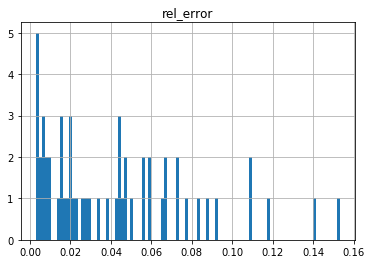

In [104]:
error_state.hist(bins=100)

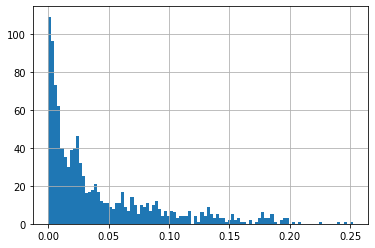

In [105]:
error["rel_error"].hist(bins=100)

Now, the great thing is that literally ALL OF THE ABOVE has been pacakged into a nice function for you, which returns both the trained model and this error dataframe! Simply run the `model_testing` function from the `mdp_model.py` file, and you will get these results!

## Visualization Tools

`plot_pred` allows us to visualize the predicted path of the model compared to the real evolution of the target value.

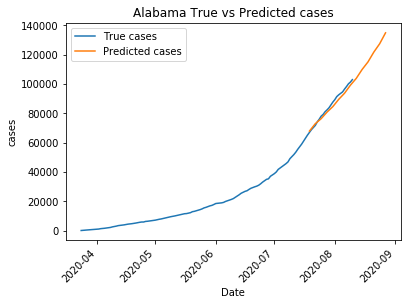

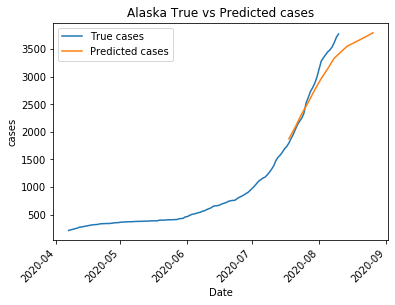

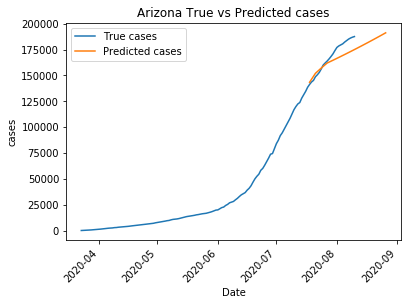

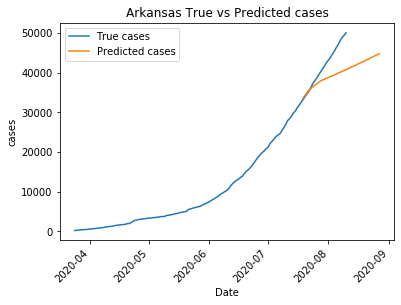

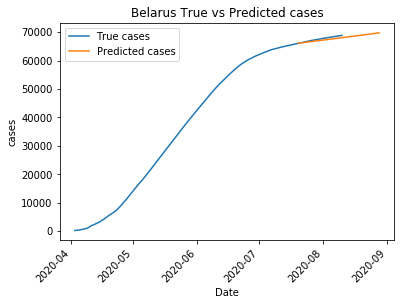

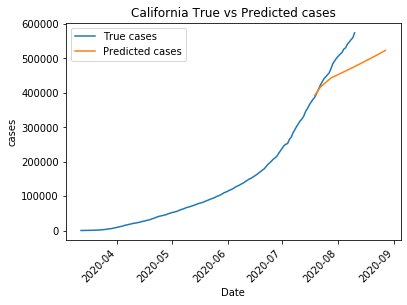

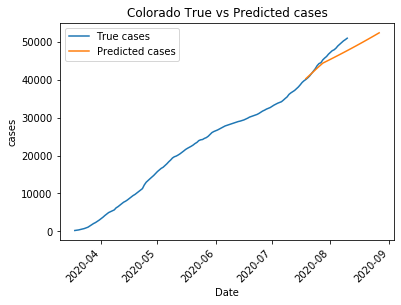

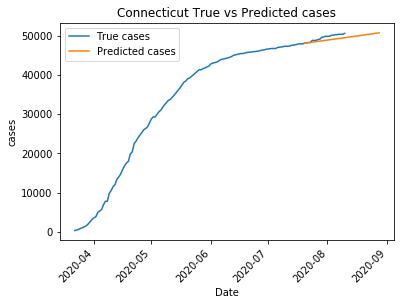

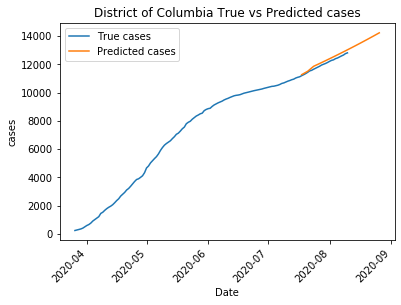

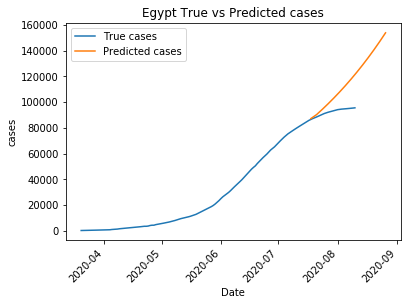

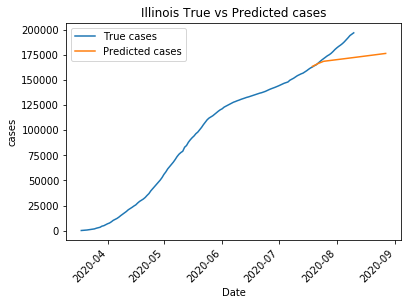

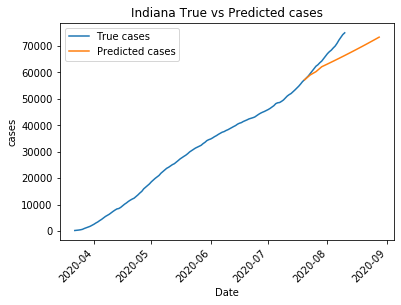

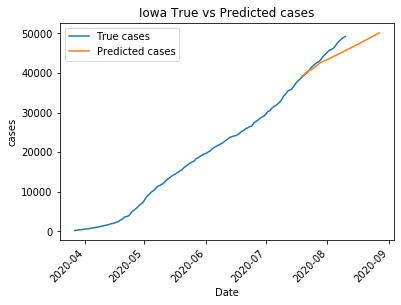

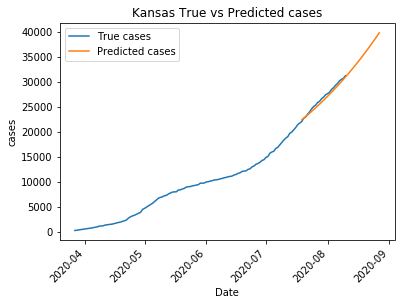

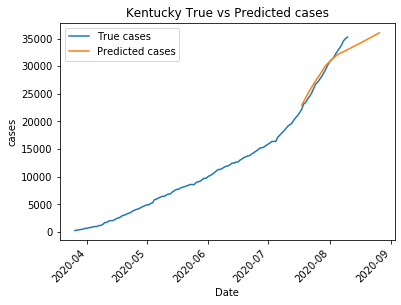

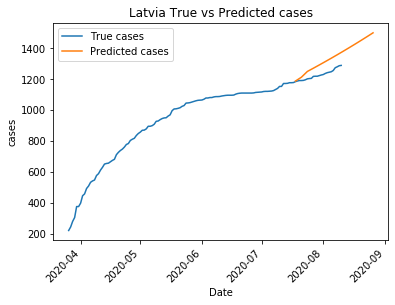

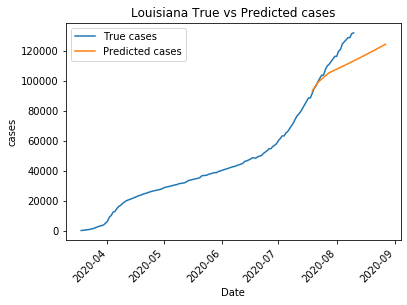

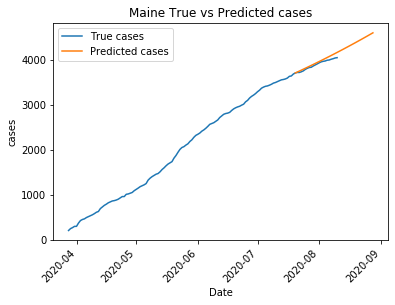

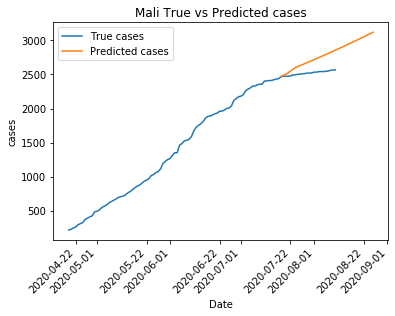

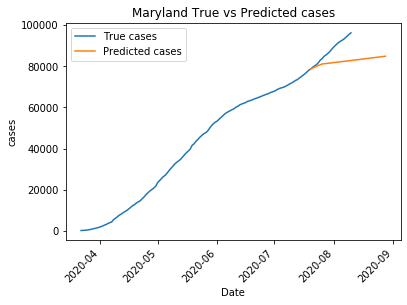

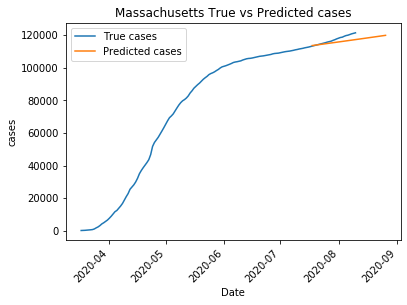

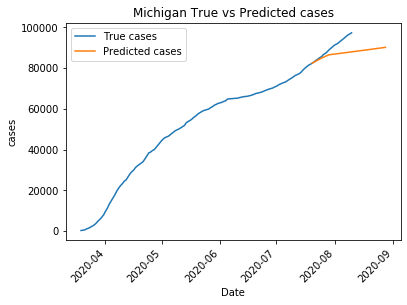

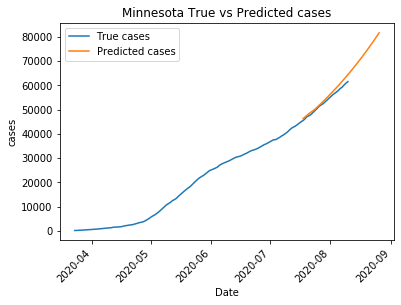

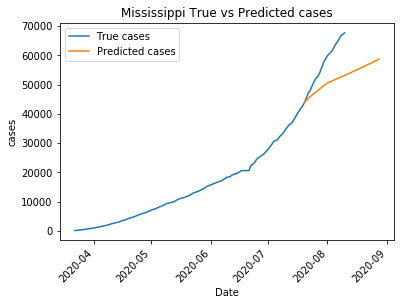

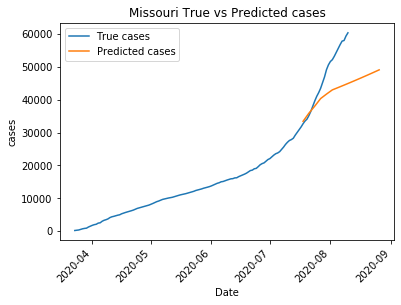

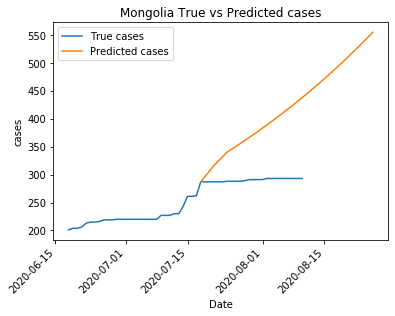

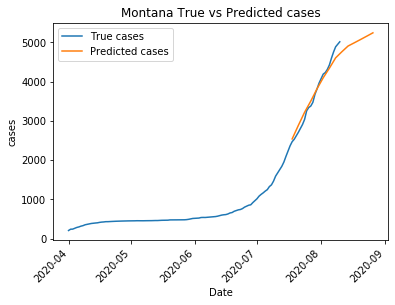

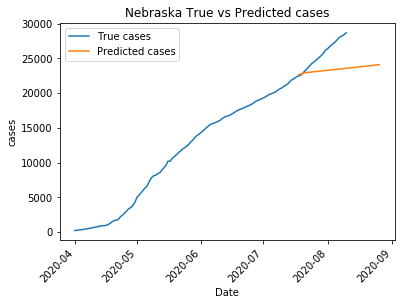

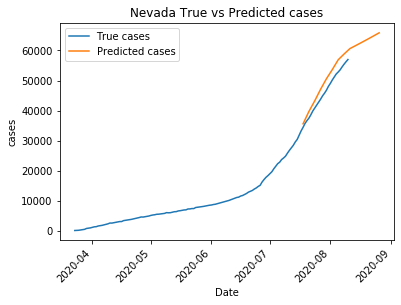

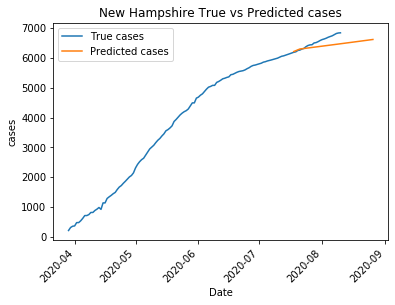

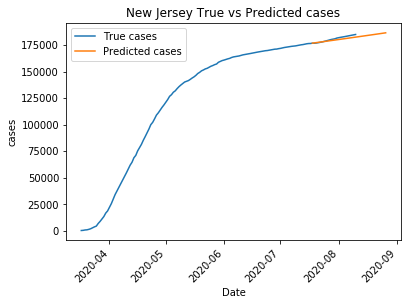

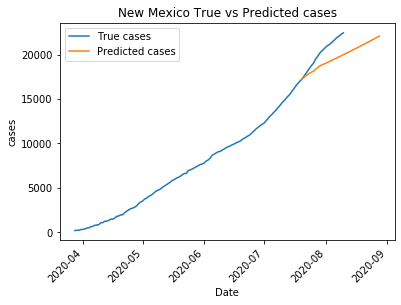

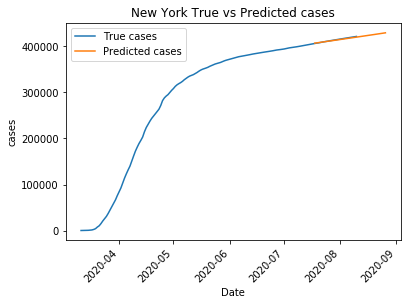

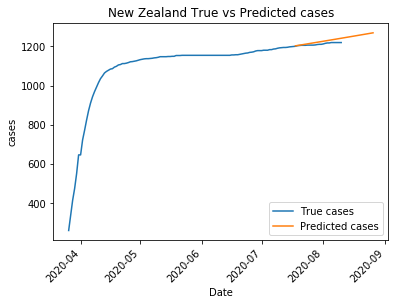

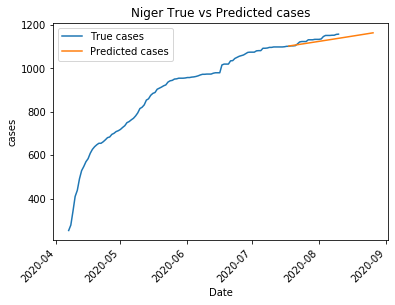

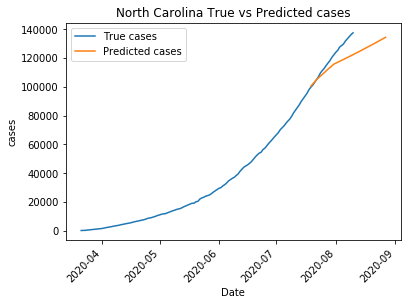

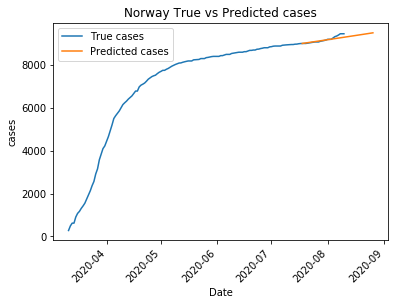

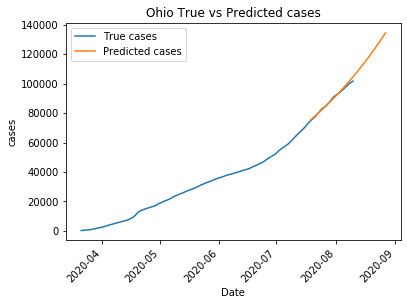

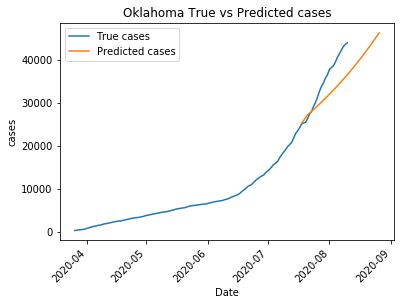

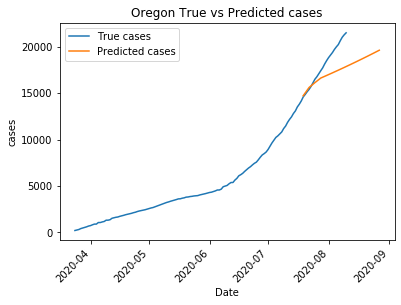

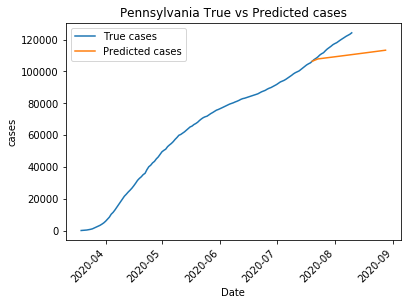

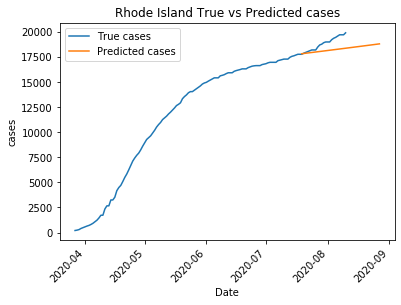

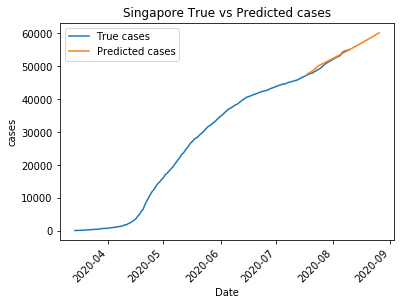

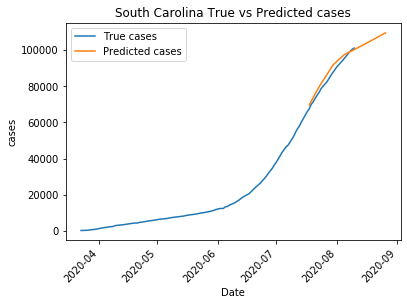

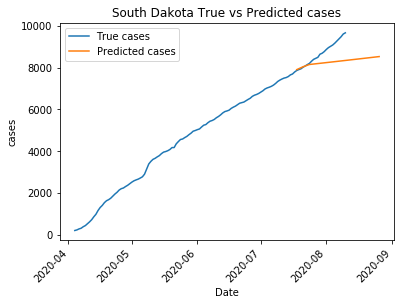

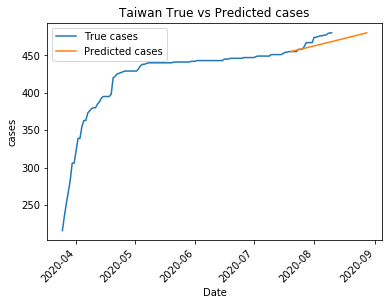

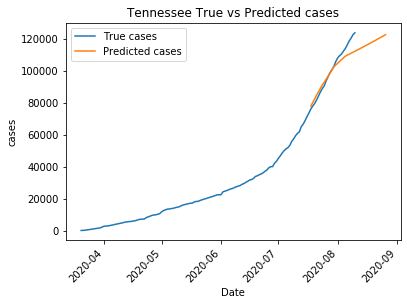

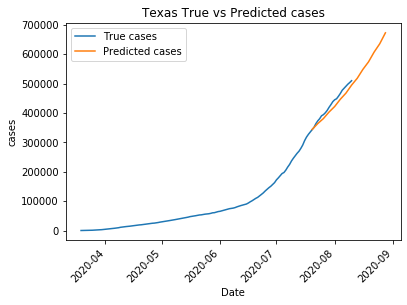

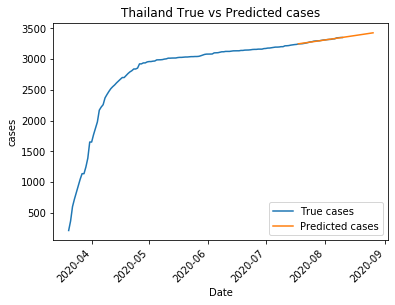

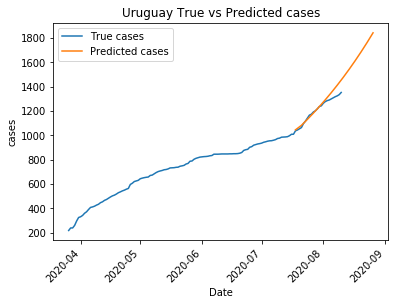

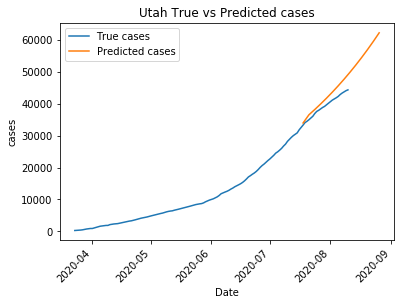

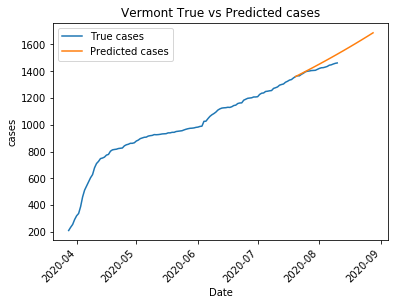

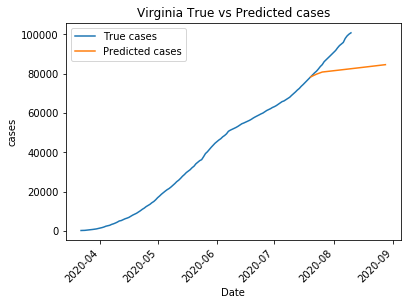

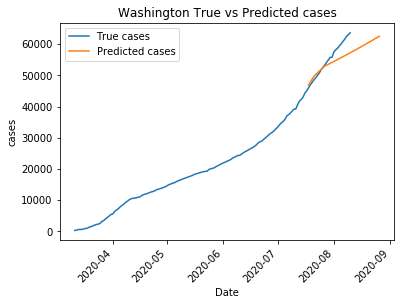

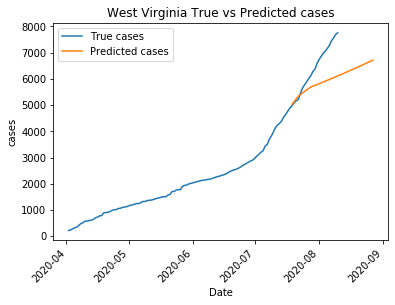

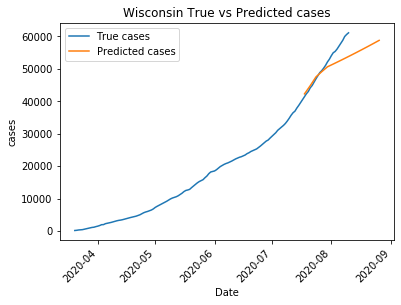

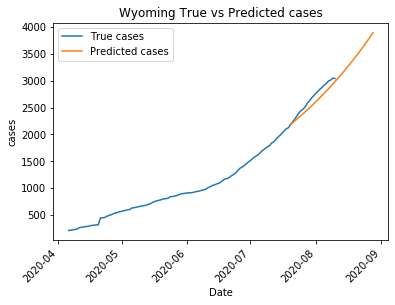

In [14]:
for region in m.df_trained.index:
    plot_pred(m, region, df, 40)

## $\textbf{Grid Search Analysis}$

no model trained currently

In [36]:
results = pd.DataFrame()

for ix in range(1, 10):

    with open(os.path.join(MODEL_PATH, 'mdp_exp{}.pickle'.format(ix)), 'rb') as filehandler:
        m = pickle.load(filehandler)
        
        # add actions
    df_action, pfeatures, actions = createSamples(df.copy(),
                                           target_colname=m.target_colname,
                                           region_colname=m.region_colname,
                                           date_colname=m.date_colname,
                                           features_list=["workplaces_percent_change_from_baseline_med_diff7", "cases_pct3", "cases_pct5"],
                                           action_thresh_base=m.action_thresh,
                                           days_avg=m.days_avg,
                                           d_delay=m.d_delay,
                                           region_exceptions=m.region_exceptions)
    
    # prediction with actions
    df_pred = pd.concat([m.predict_allregions_ndays(i, actions_df=df_action) for i in range(1, n_days)]).reset_index()
    df_true = df_pred.set_index([m.region_colname, "TIME"]).join(df.rename(columns={m.date_colname: "TIME"}).set_index([m.region_colname, "TIME"])[m.target_colname], lsuffix="_", rsuffix="").loc[:, [m.target_colname]].reset_index().set_index(m.region_colname)
    df_pred.set_index(m.region_colname, inplace=True)
    error = mape(df_pred, df_true, m.target_colname).reset_index()
    error_state_actions = error.drop("TIME", axis=1).groupby(m.region_colname)["rel_error"].mean().to_frame()
    error_state_actions.sort_values("rel_error")
    
    ix_x = (ix- 1) % 3
    ix_y = (ix- 1) // 3
    results.at[ix_x, ix_y] = error_state_actions.mean()[0]
    
    

In [38]:
results_ = results.copy()

In [40]:
results_.index = ["lag_0", "lag_7", "lag_14"]
results_.columns = ["Method III", "Method II", "Method I"]

In [41]:
results_

Method III  Method II  Method I
lag_0     0.040744   0.052225  0.033995
lag_7     0.037787   0.042618  0.050539
lag_14    0.048038   0.055146  0.098063

In [ ]:
mgs.best_estimator_

In [ ]:
import operator
key_opt = min(mgs.testing_error.items(), key=operator.itemgetter(1))[0]
m_opt = mgs.all_estimators_dict[key_opt]
m_opt

In [ ]:
m_opt.optimal_cluster_size

In [30]:
# Import full dataset and convert time col to time object
file = '07_08_2020_states_combined.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file))
df.loc[:, [date_col]]= pd.to_datetime(df[date_col])

df_pred = pd.concat([m_opt.predict_allregions_ndays(i) for i in range(1, n_days)]).reset_index()
df_true = df_pred.set_index([m_opt.region_colname, "TIME"]).join(df.rename(columns={m_opt.date_colname: "TIME"}).set_index([m_opt.region_colname, "TIME"])[m_opt.target_colname], lsuffix="_", rsuffix="").loc[:, [m_opt.target_colname]].reset_index().set_index(m_opt.region_colname)
df_pred.set_index(m_opt.region_colname, inplace=True)
error = mape(df_pred, df_true, m_opt.target_colname).reset_index()
error_state = error.drop("TIME", axis=1).groupby(m_opt.region_colname)["rel_error"].mean().to_frame()
error_state.sort_values("rel_error")

NameError: name 'm_opt' is not defined

In [12]:
# computing the out of sample error
error_state.describe()

NameError: name 'error_state' is not defined

In [ ]:
error["rel_error"].hist(bins=100)

## $\textbf{Changing in policy analysis}$

In [127]:
MODEL_PATH = r"C:\Users\david\Desktop\MIT\Courses\Research internship\results\28 - 20201008 - mobility analysis"
with open(os.path.join(MODEL_PATH, 'mdp_exp2.pickle'), 'rb') as filehandler:
    m = pickle.load(filehandler)

In [128]:
# # plot_pred() takes a trained model, a specific US state name, and the df_true
# # (sorted by TIME), and plots the predicted versus true cases for n_days
# def plot_pred_action(model, state, df_true, n_days, action_day=0, from_first=False):
#     h = int(np.floor(n_days/model.days_avg))
#     action_adj = int(np.floor(action_day/model.days_avg))
#     df_true.loc[:, [model.date_colname]]= pd.to_datetime(df_true[model.date_colname])
#     if from_first:
#         date = model.df_trained_first.loc[state, "TIME"]
#         target = model.df_trained_first.loc[state, model.target_colname]
#         s_init = model.df_trained_first.loc[state, "CLUSTER"]
#     else:
#         date = model.df_trained.loc[state, "TIME"]
#         target = model.df_trained.loc[state, model.target_colname]
#         s_init = model.df_trained.loc[state, "CLUSTER"]

#     actions = [a - model.action_thresh[1] for a in range(len(model.action_thresh[0])+1)]
#     fig, ax = plt.subplots(figsize=(28,13))

#     # prediction 0
#     for a in actions:
#         s = s_init
#         dates = [date]
#         targets_pred = [target]
#         r = 1
#         for i in range(h):
#             dates.append(date + timedelta((i+1)*model.days_avg))
#             r = r*np.exp(model.R_df.loc[s])
#             targets_pred.append(target*r)
#             try:
#                 if i == action_adj:
#                     s_bf = s
#                     s = model.P_df.loc[s, a].values[0]
#                     print("with action {}".format(a)," STATE bef:", s_bf, " STATE aft:", s)
#                 else:
#                     s = model.P_df.loc[s, 0].values[0]
#             except TypeError:
#                 print("Transition not found:", (s, a))
#                 break

#         target_pred_act = pd.Series(index=dates, data=targets_pred)
#         target_pred_act.plot(label='Predicted '+model.target_colname+ ' with ACTION {} after {} days'.format(a, action_day), ax=ax)

#     ax.plot(df_true.loc[df_true[model.region_colname]==state][model.date_colname], \
#             df_true.loc[df_true[model.region_colname]==state][model.target_colname], \
#             label = 'True '+model.target_colname)
#     ax.set_title('%s True vs Predicted '%state + model.target_colname)
#     ax.set_xlabel('Date')
#     ax.set_ylabel(model.target_colname)
#     plt.xticks(rotation=45, ha='right')
#     plt.legend()
#     plt.show(block=False)

In [129]:
len(list(m.mdp_transition.P_df.index.unique()))

445

In [130]:
m.mdp_transition.R_df

EST_RISK
CLUSTER          
0        0.181097
1        0.024520
2        0.323676
3        0.108593
4        0.039474
...           ...
84       0.070438
85       0.126441
86       0.025060
87       0.069886
88       0.096870

[89 rows x 1 columns]

In [131]:
m.mdp_transition.P_df.iloc[50: 70]

TRANSITION_CLUSTER
CLUSTER ACTION                    
10      -2                     NaN
        -1                    75.0
         0                    71.0
         1                     NaN
         2                     NaN
11      -2                    74.0
        -1                    74.0
         0                    80.0
         1                    80.0
         2                     NaN
12      -2                     NaN
        -1                     5.0
         0                    12.0
         1                     NaN
         2                     NaN
13      -2                     NaN
        -1                    80.0
         0                    80.0
         1                     8.0
         2                     NaN

In [146]:
ex_cluster = 0.
# print(m.mdp_transition(ex_cluster,-2))
print(m.mdp_transition(ex_cluster,-1))
print(m.mdp_transition(ex_cluster, 0))
print(m.mdp_transition(ex_cluster, 1))
# print(m.mdp_transition(ex_cluster, 2))
#  19.0  STATE aft: 51.0

(2.0, 0.12726944724546832)
(56.0, 0.16112713288002647)
(56.0, 0.16112713288002647)


#### m.mdp_transition.completion_algorithm

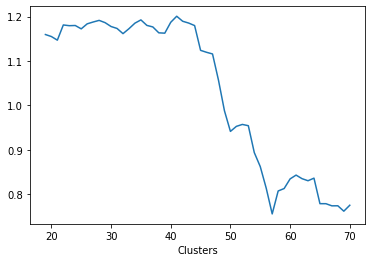

In [147]:
m.cv_testing_error.plot()

with action -1  STATE bef: 7.0  STATE aft: 8.0
with action 0  STATE bef: 7.0  STATE aft: 7.0
with action 1  STATE bef: 7.0  STATE aft: 48.0


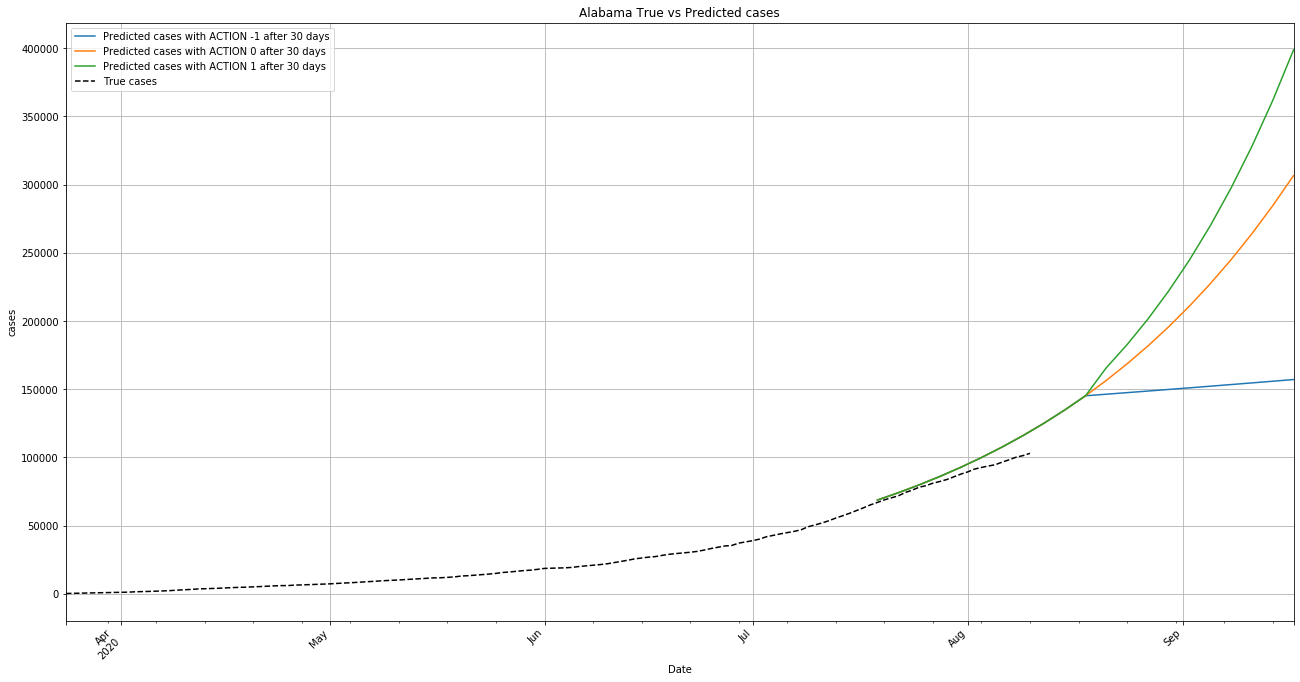

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


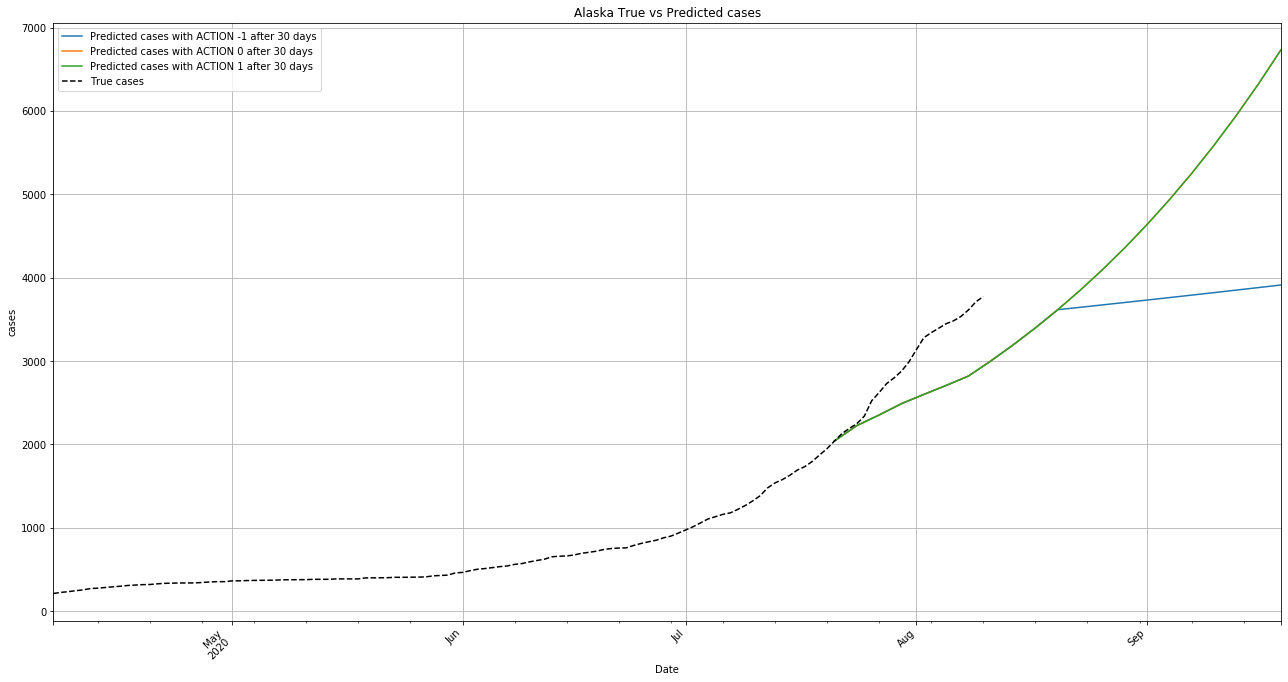

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


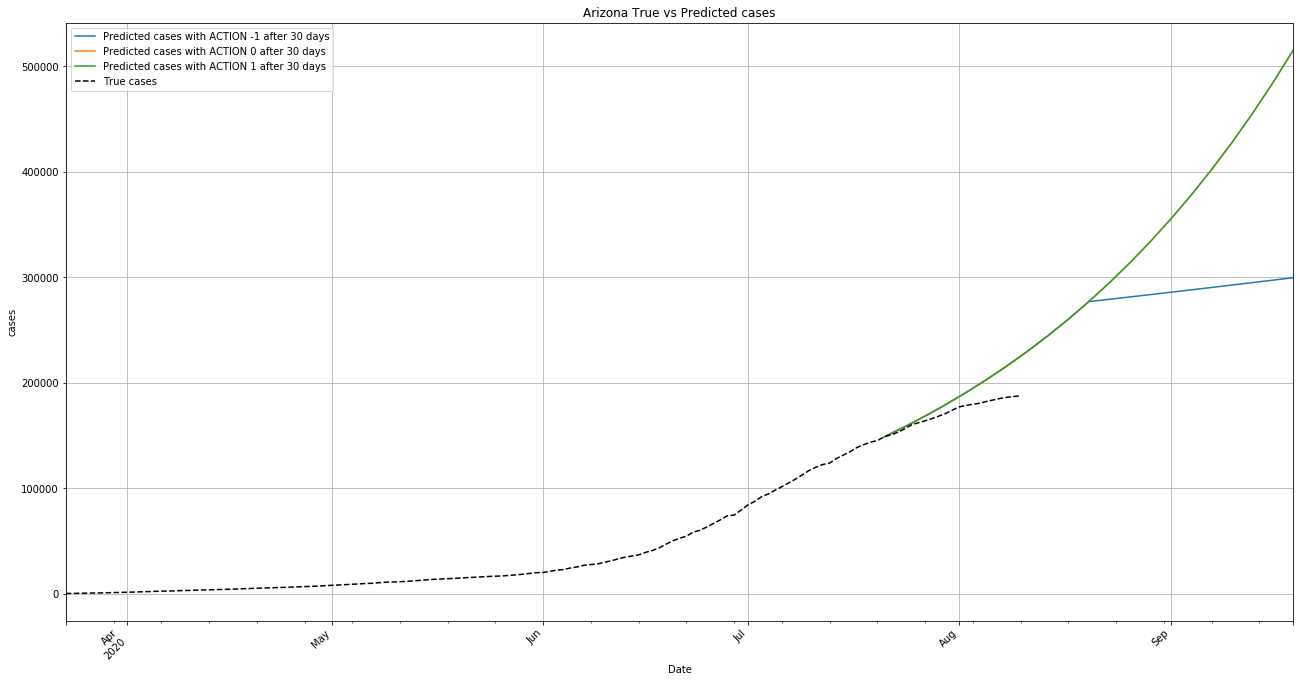

with action -1  STATE bef: 7.0  STATE aft: 8.0
with action 0  STATE bef: 7.0  STATE aft: 7.0
with action 1  STATE bef: 7.0  STATE aft: 48.0


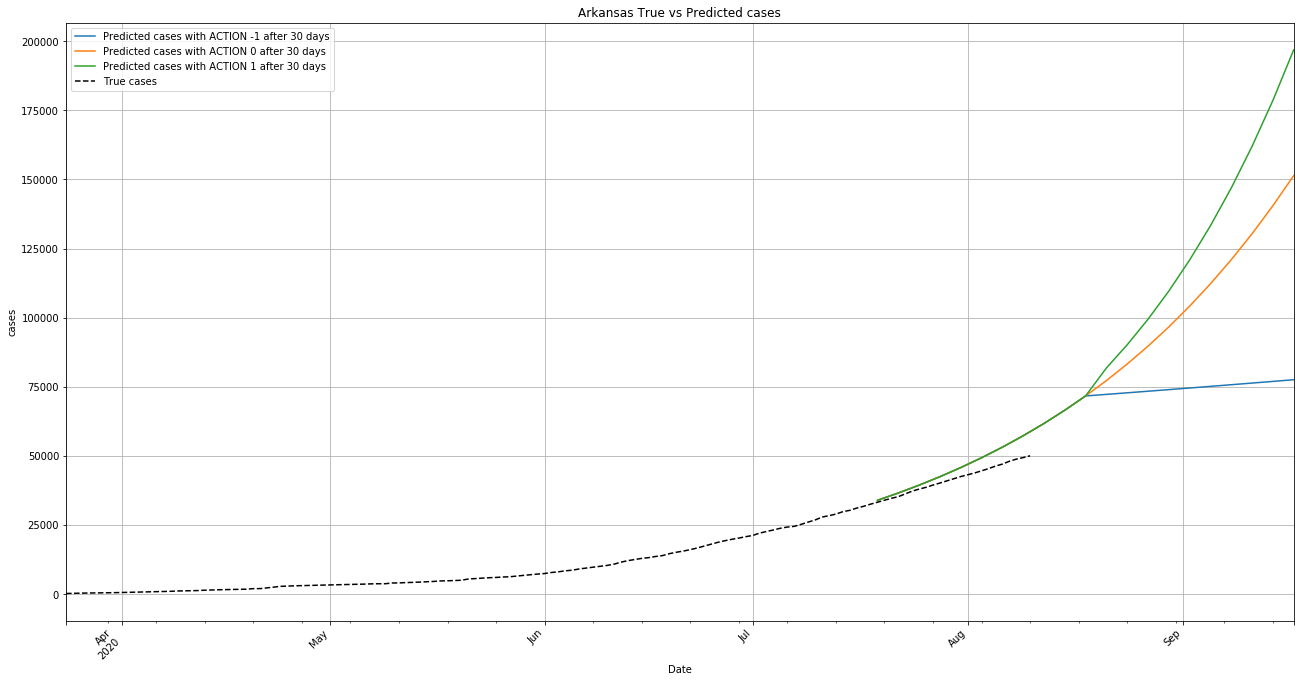

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


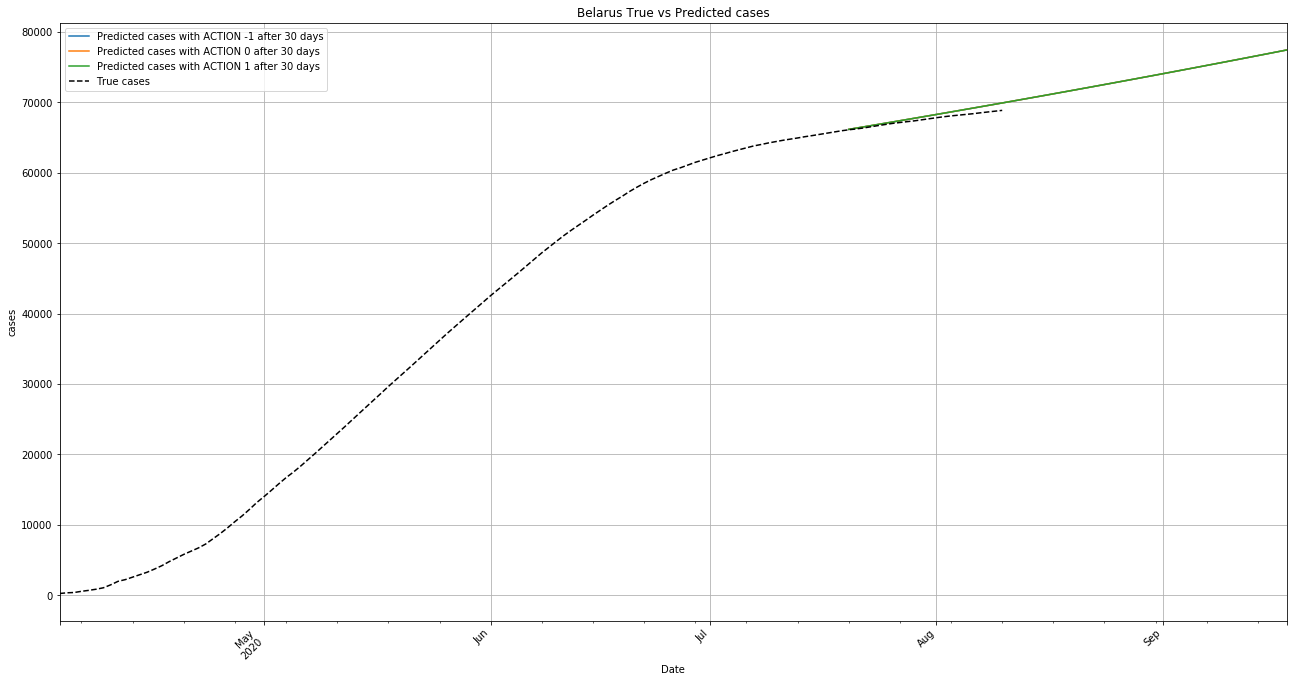

with action -1  STATE bef: 7.0  STATE aft: 8.0
with action 0  STATE bef: 7.0  STATE aft: 7.0
with action 1  STATE bef: 7.0  STATE aft: 48.0


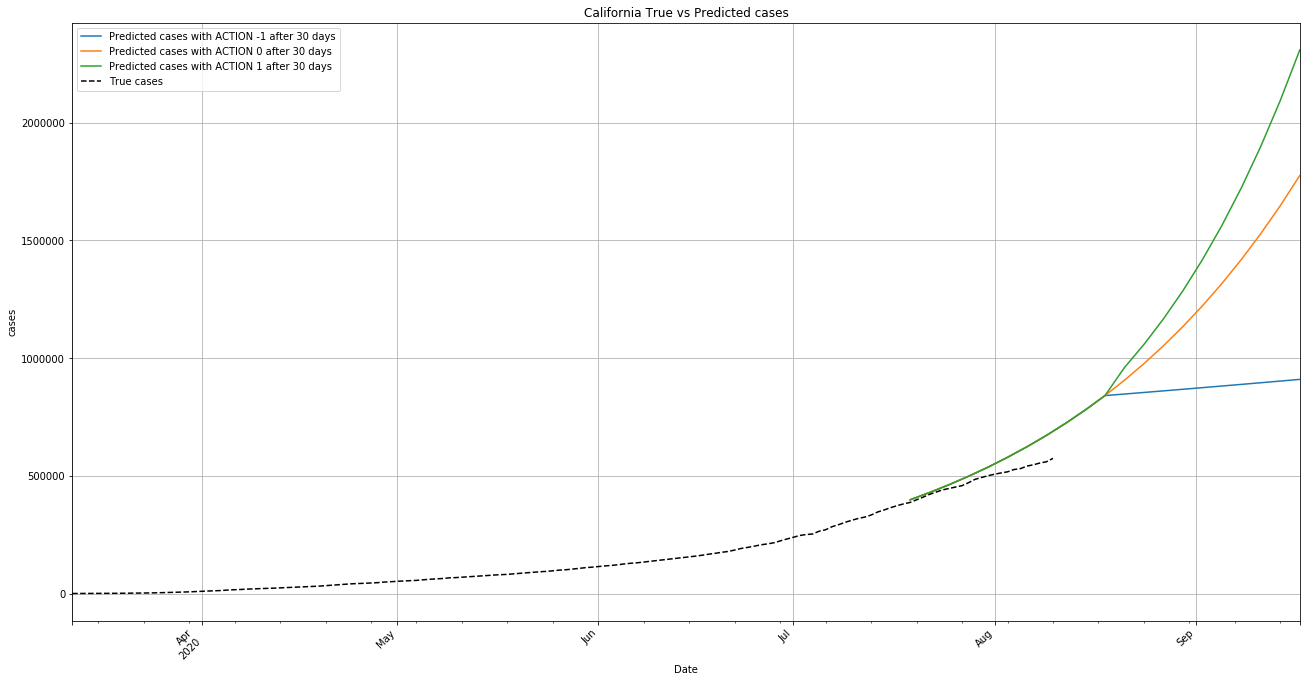

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


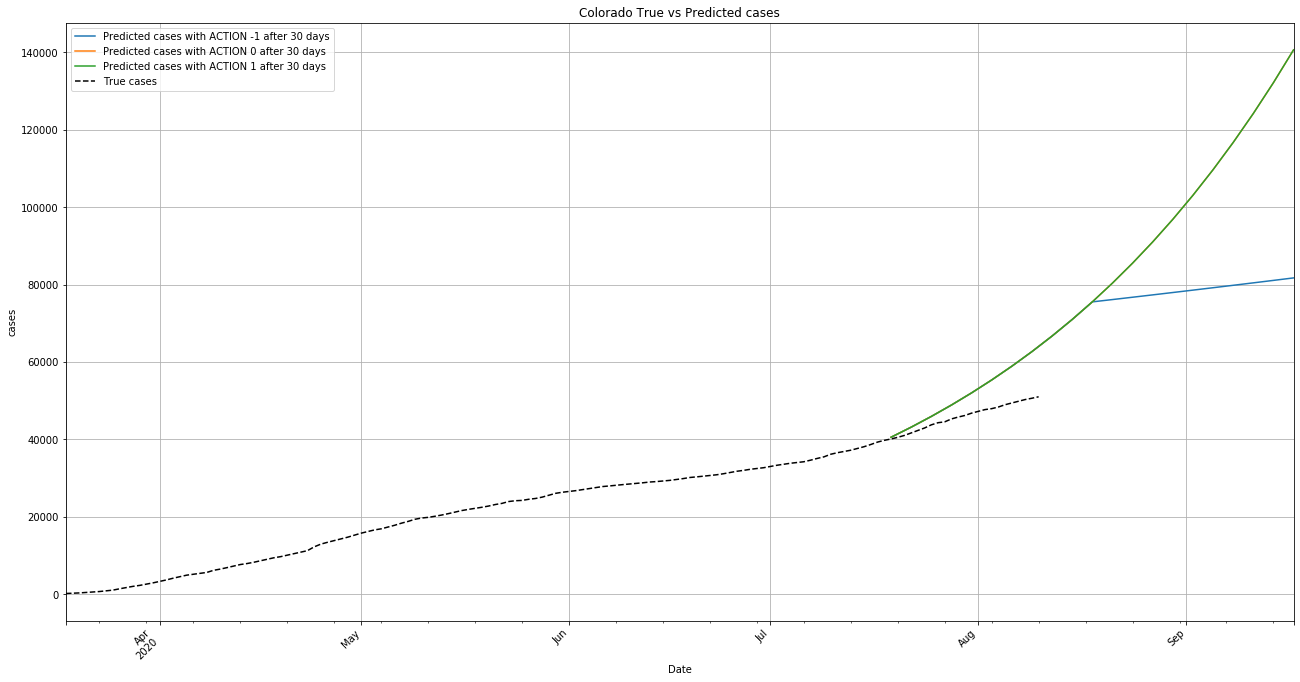

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


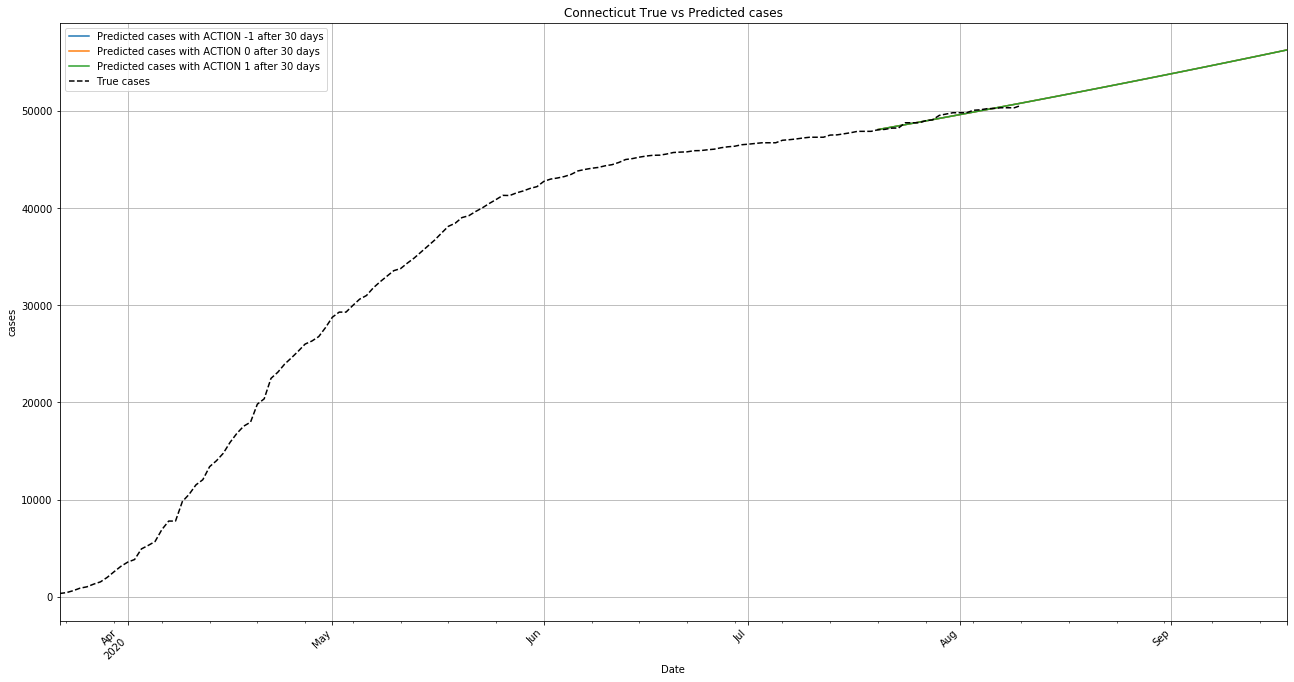

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


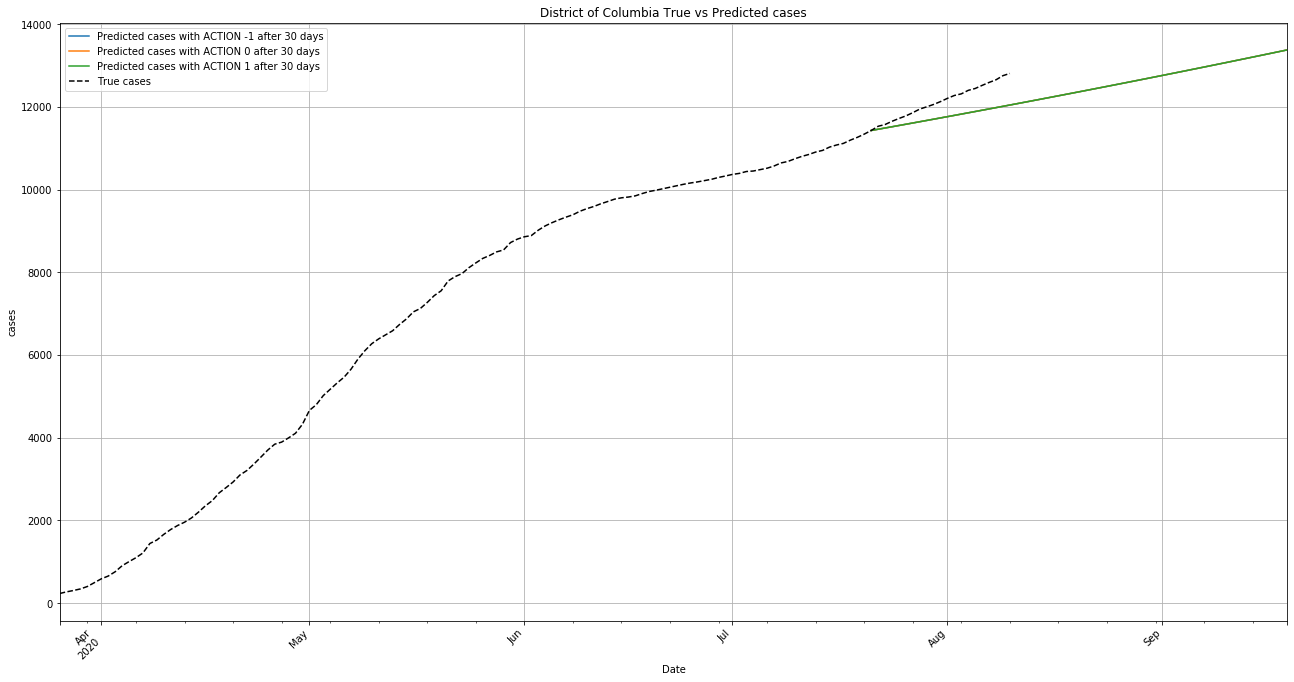

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


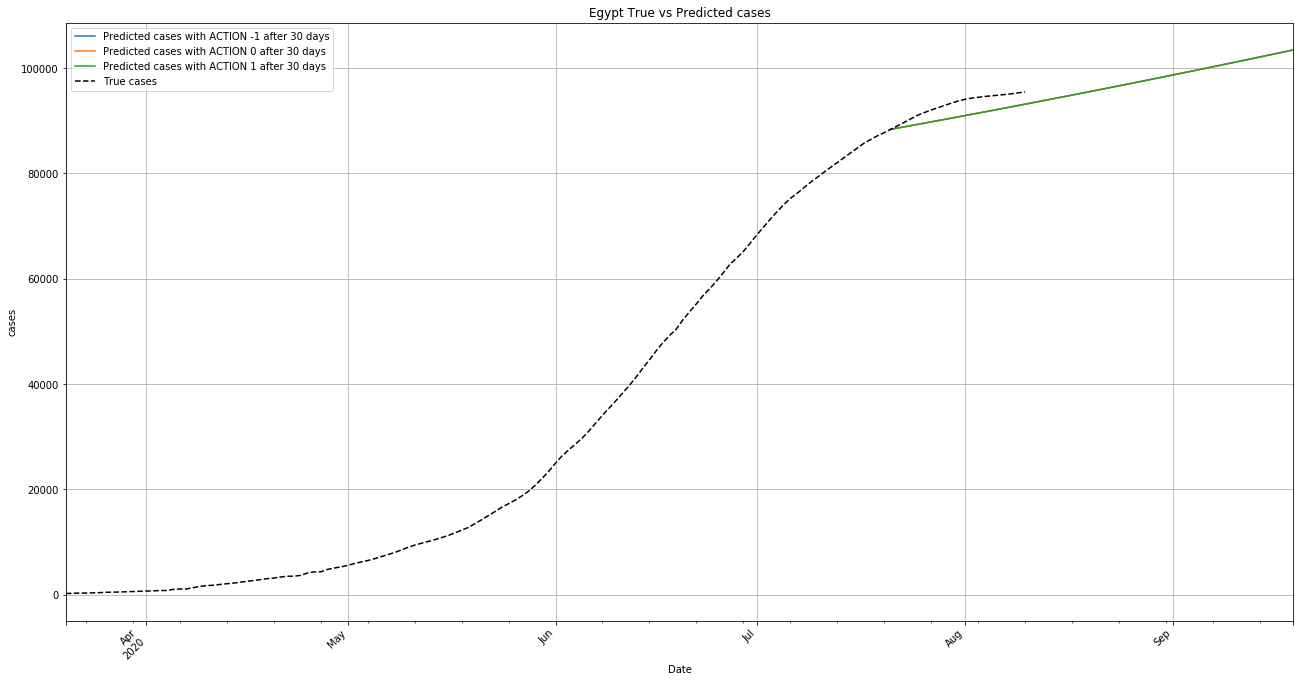

with action -1  STATE bef: 15.0  STATE aft: 8.0
with action 0  STATE bef: 15.0  STATE aft: 15.0
with action 1  STATE bef: 15.0  STATE aft: 40.0


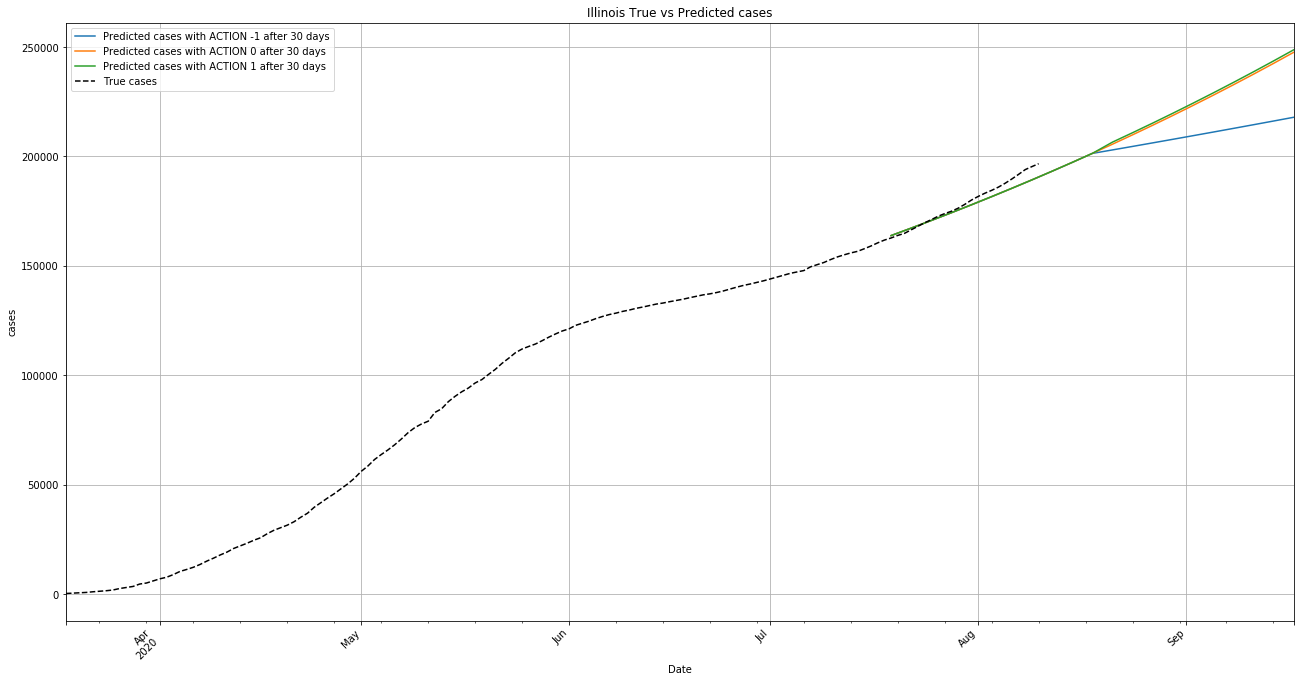

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


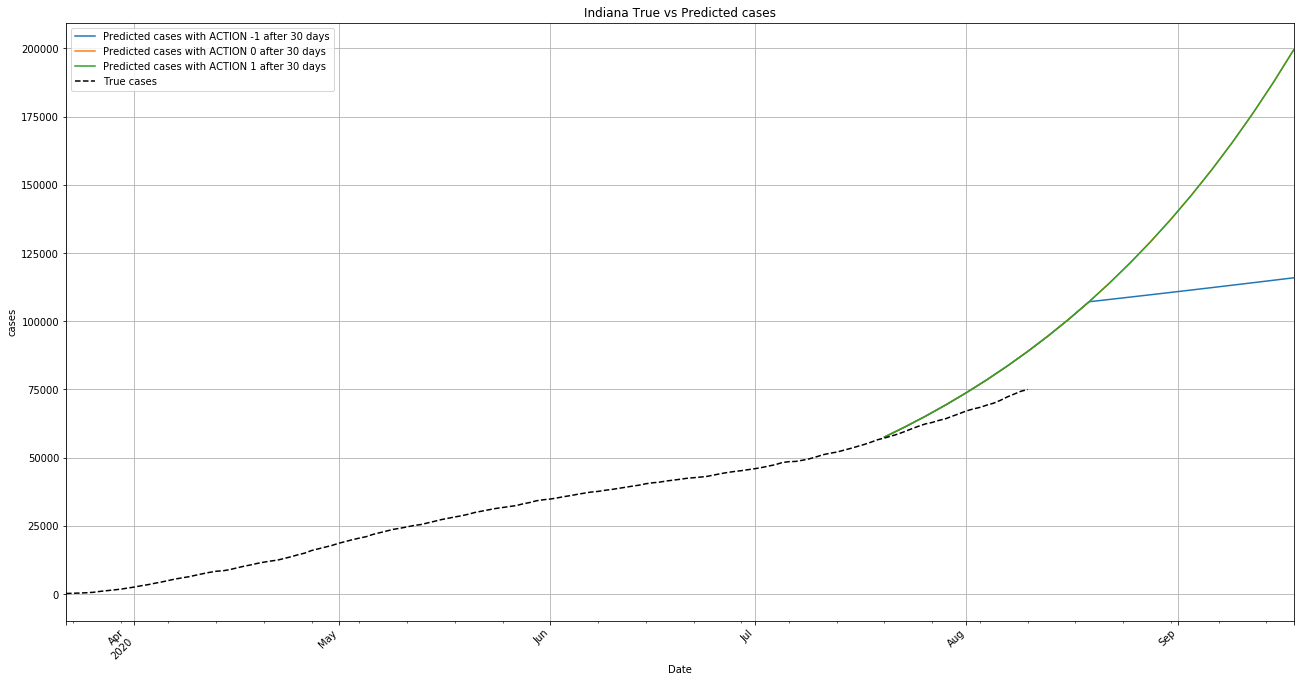

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


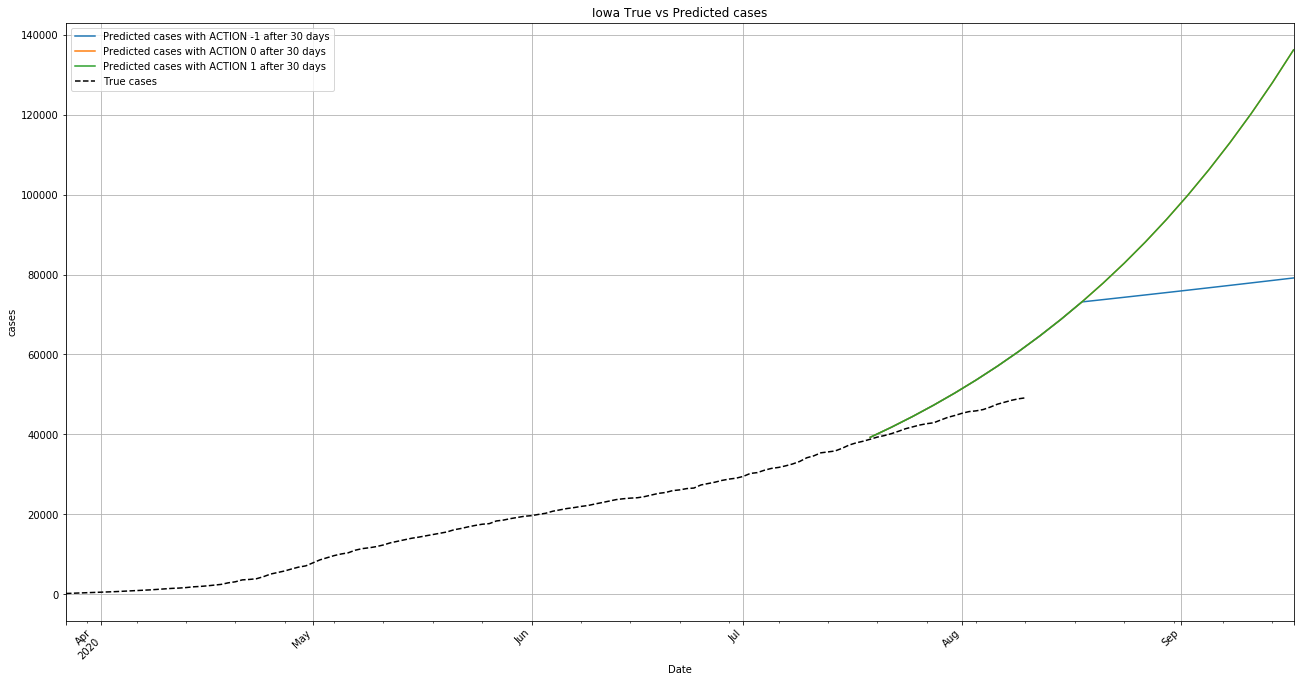

with action -1  STATE bef: 7.0  STATE aft: 8.0
with action 0  STATE bef: 7.0  STATE aft: 7.0
with action 1  STATE bef: 7.0  STATE aft: 48.0


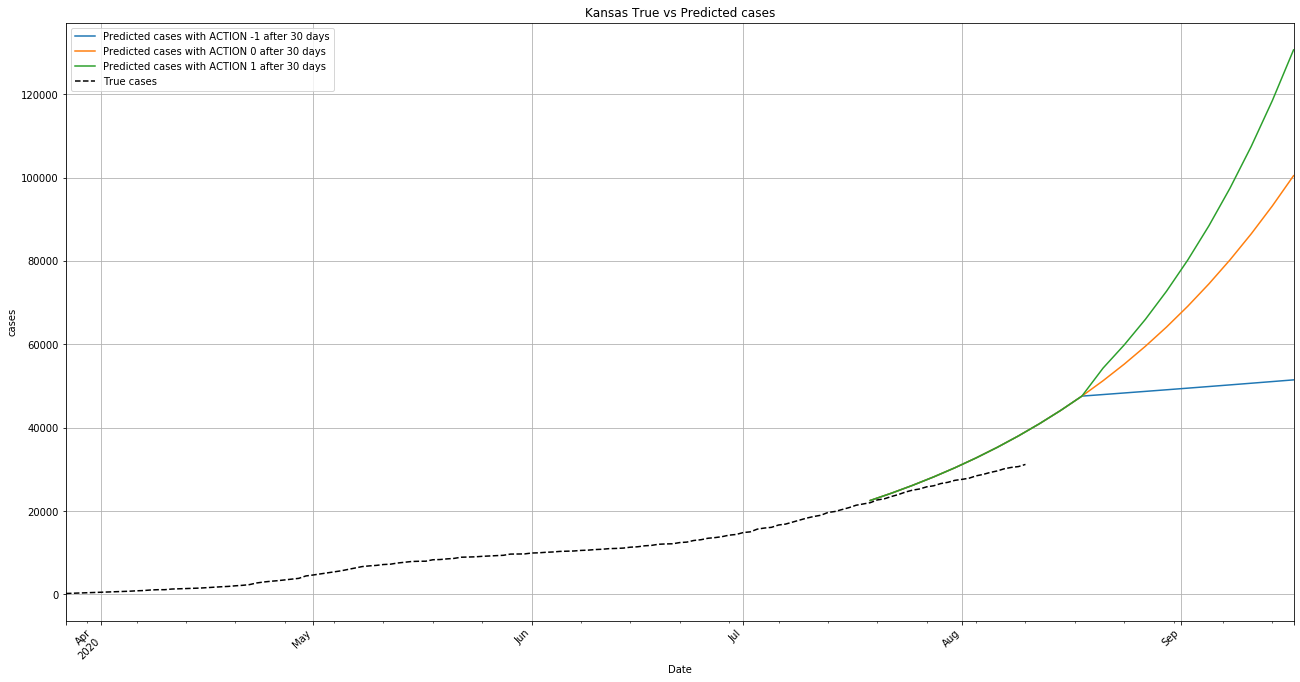

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


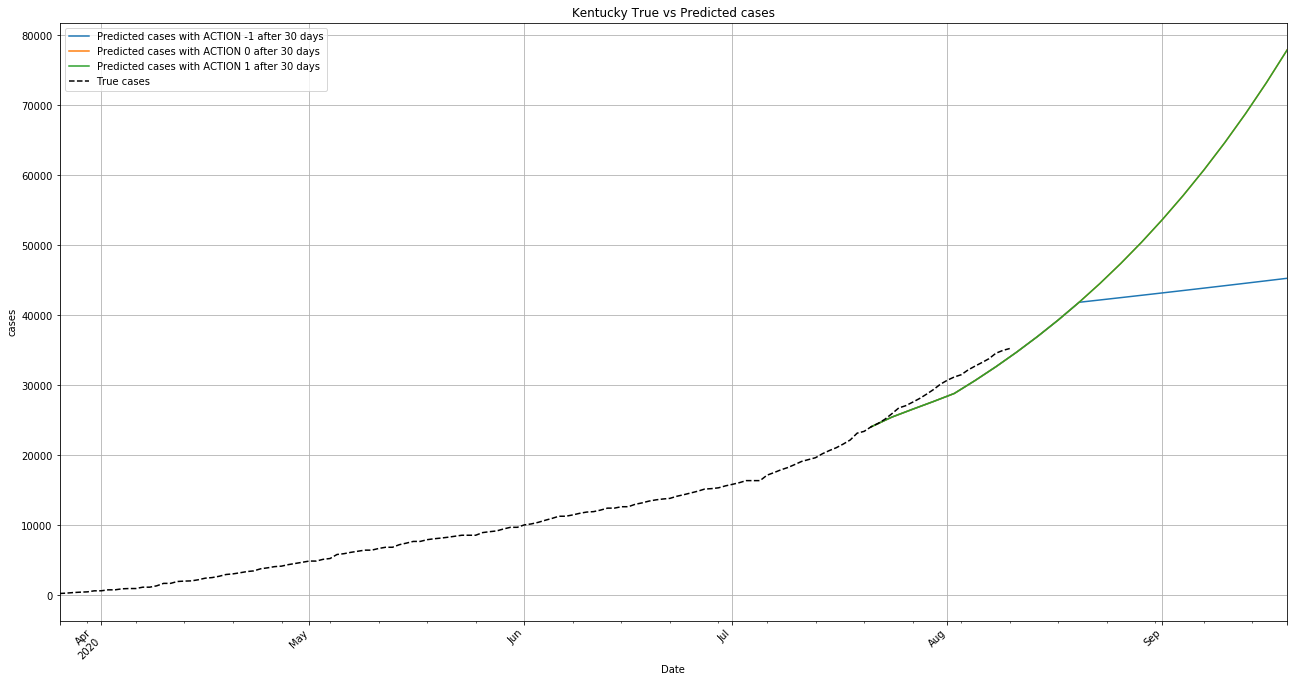

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


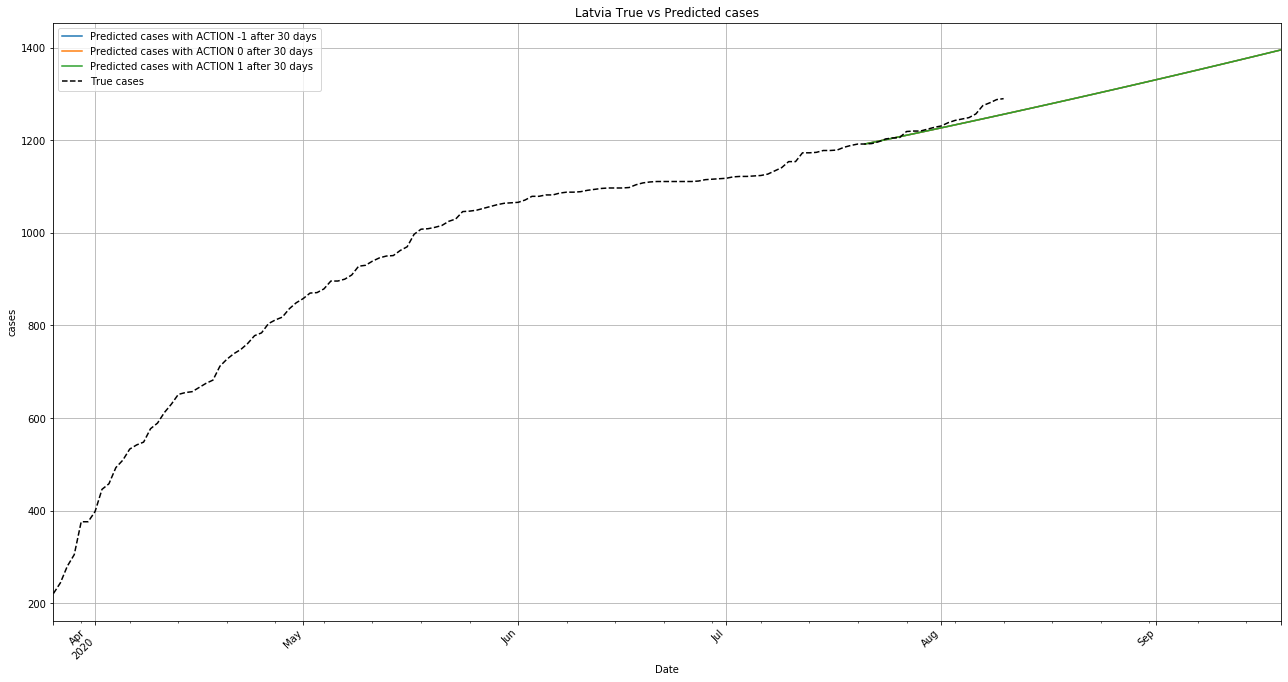

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


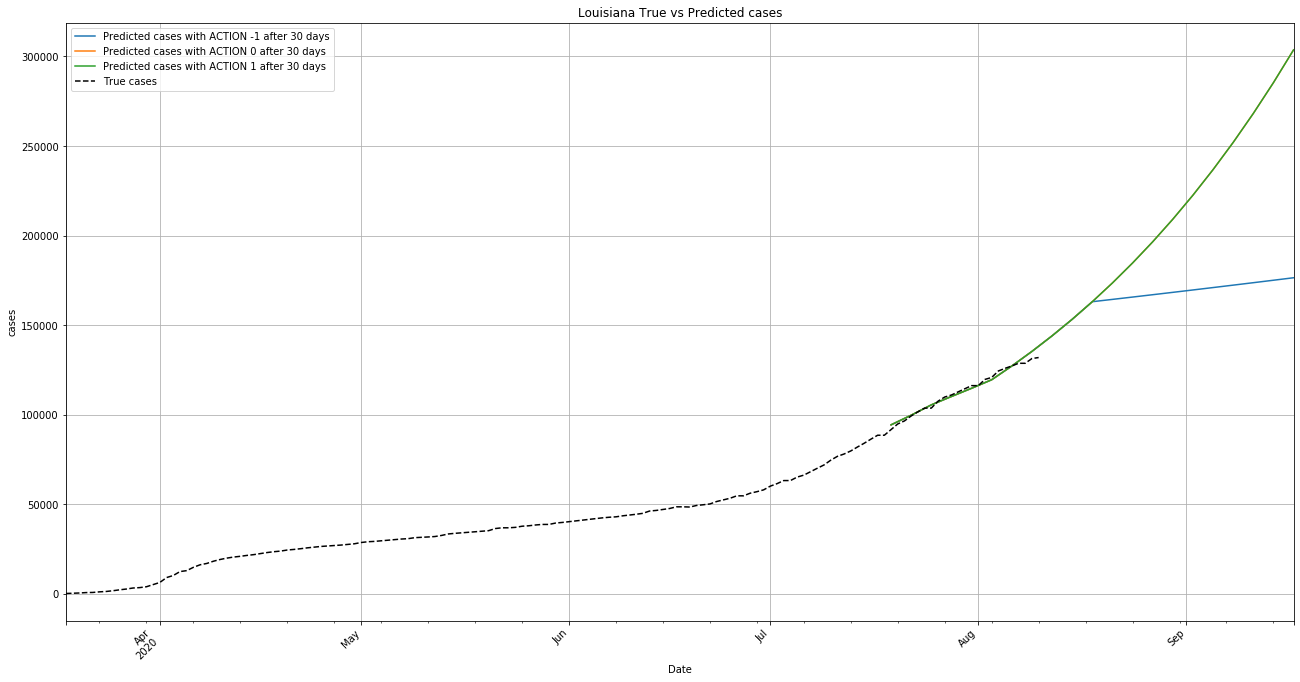

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


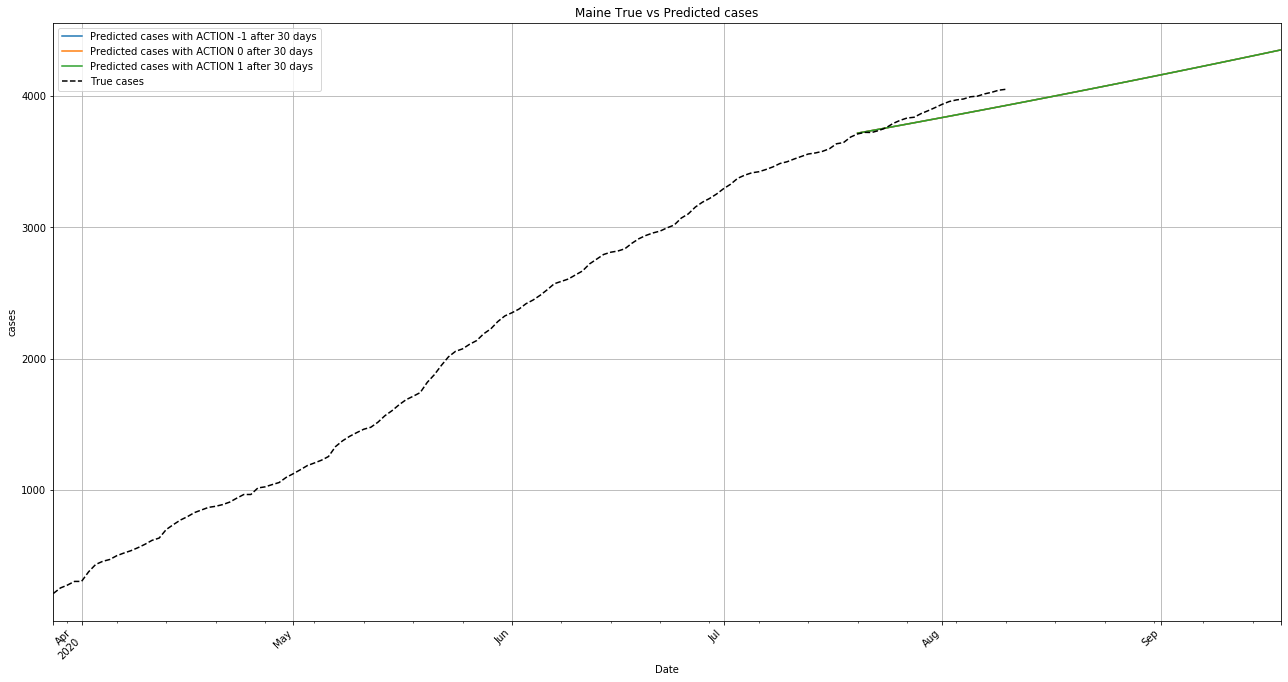

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


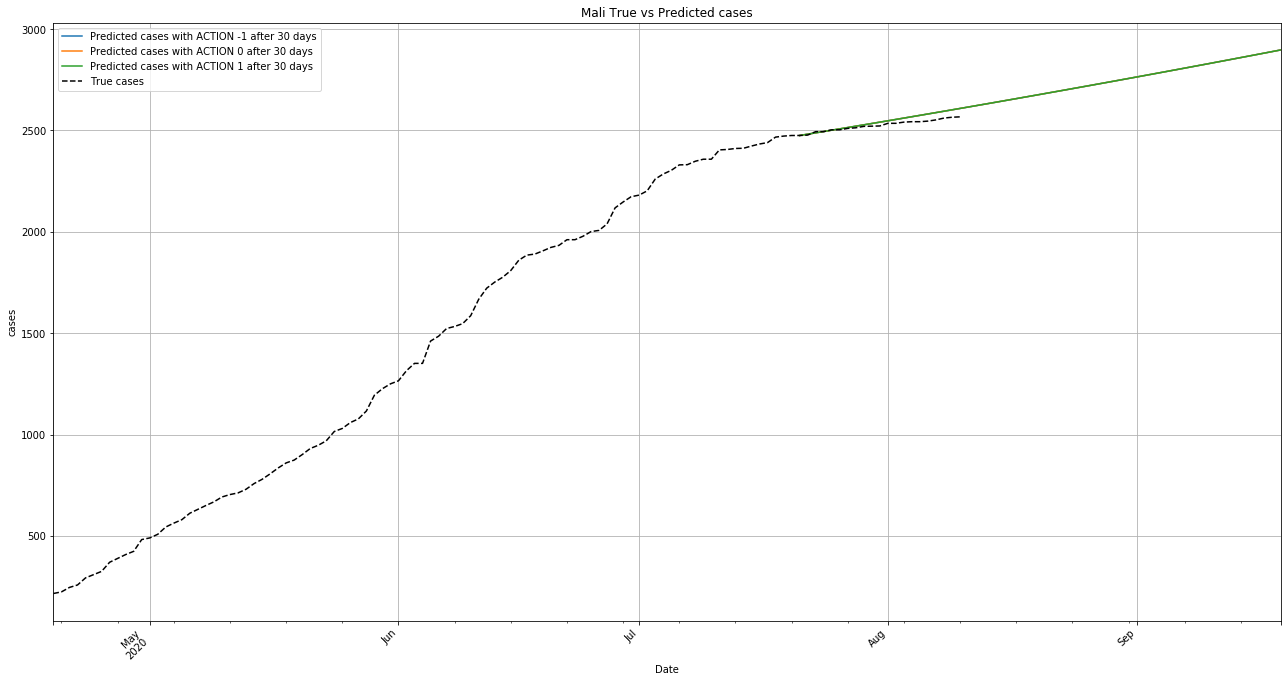

with action -1  STATE bef: 15.0  STATE aft: 8.0
with action 0  STATE bef: 15.0  STATE aft: 15.0
with action 1  STATE bef: 15.0  STATE aft: 40.0


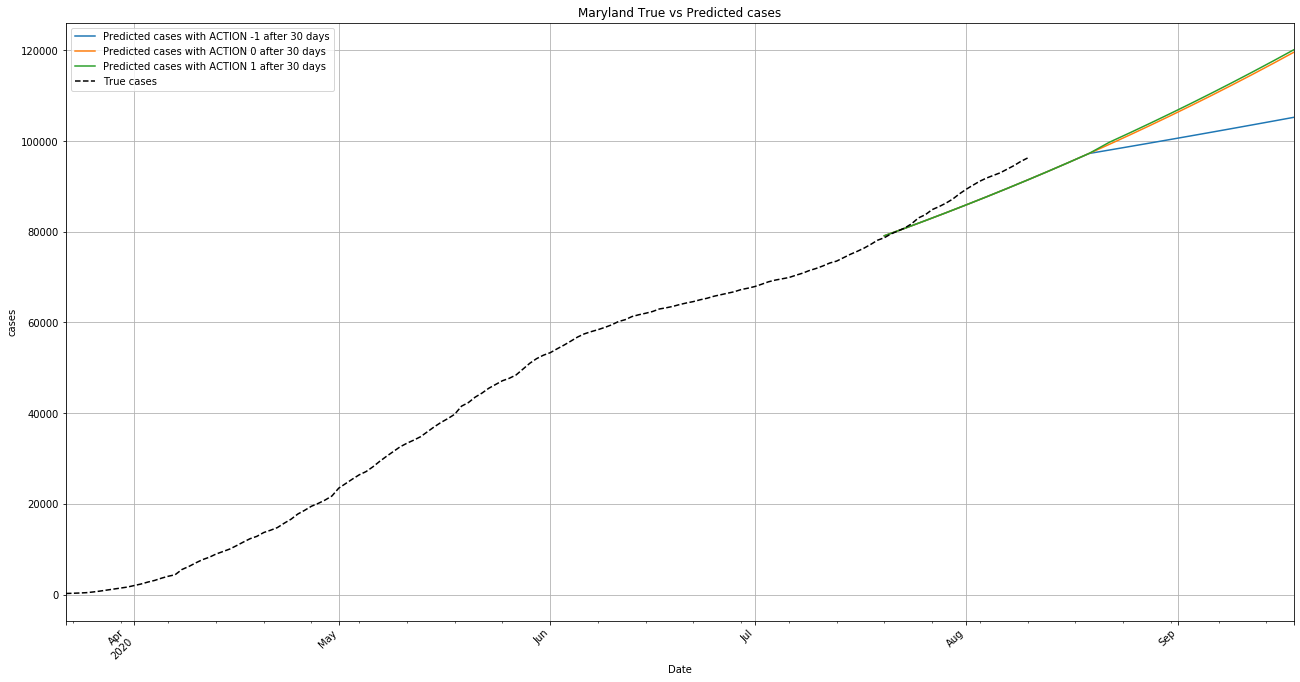

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


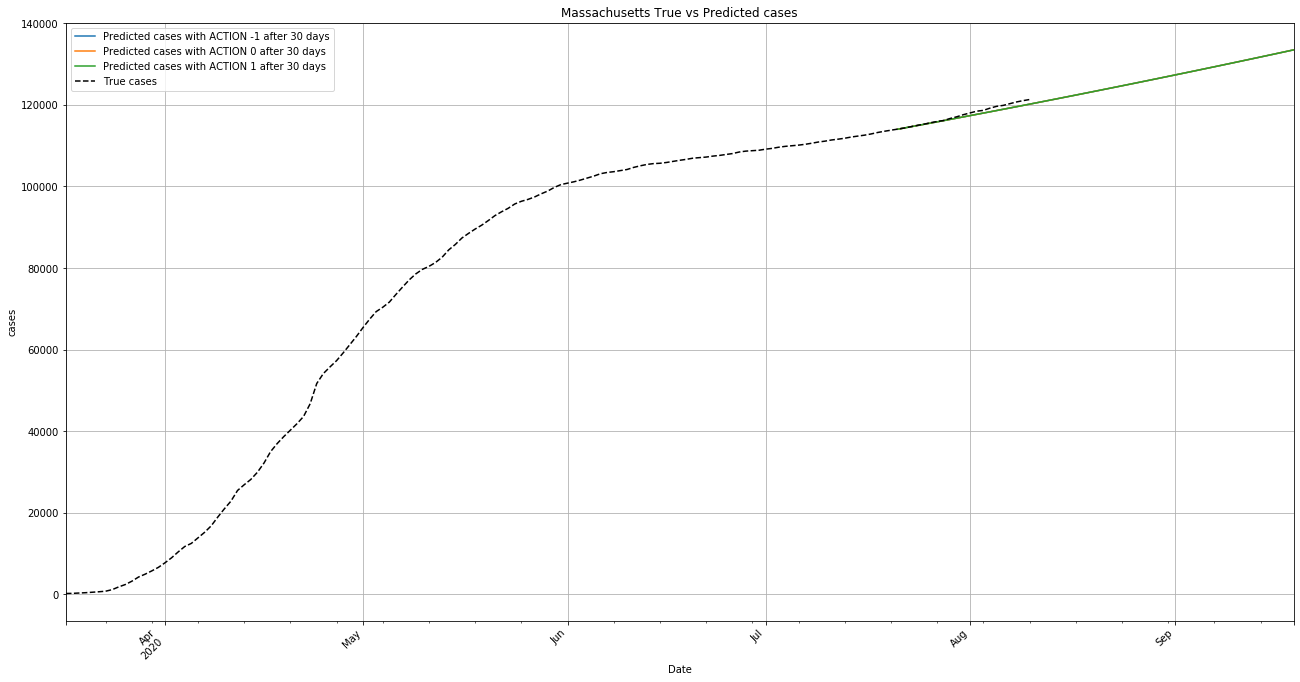

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


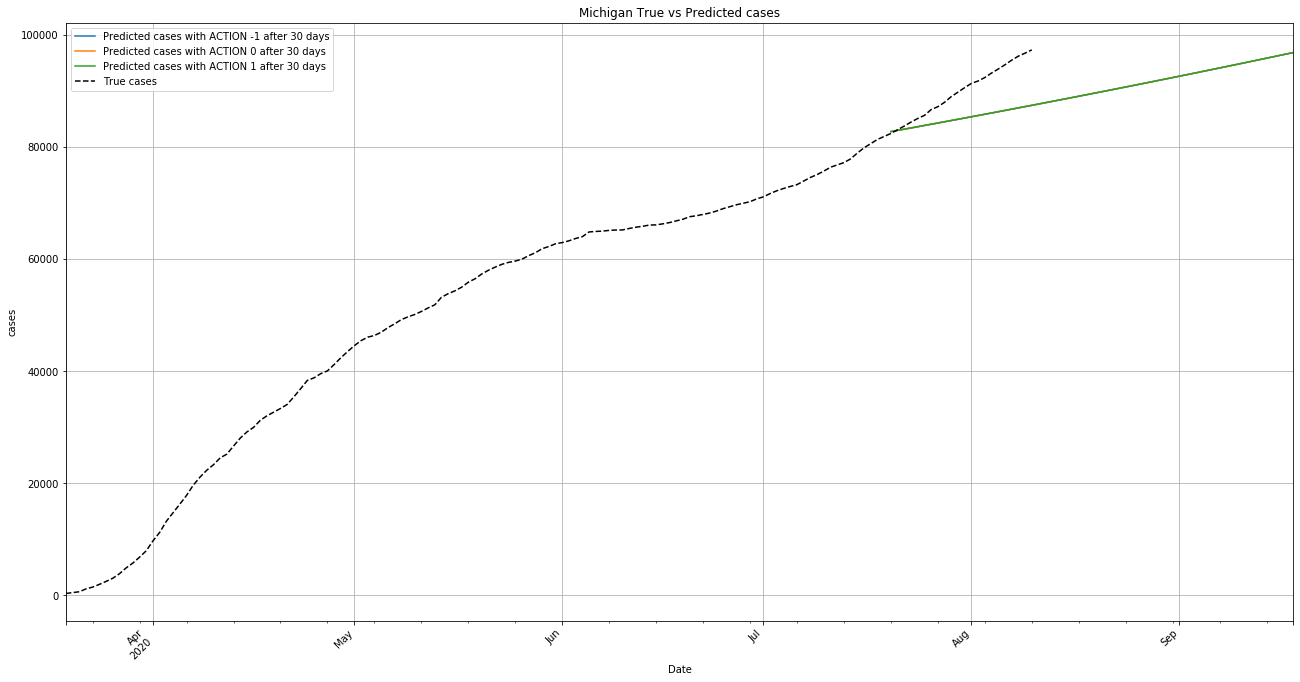

with action -1  STATE bef: 6.0  STATE aft: 8.0
with action 0  STATE bef: 6.0  STATE aft: 6.0
with action 1  STATE bef: 6.0  STATE aft: 51.0


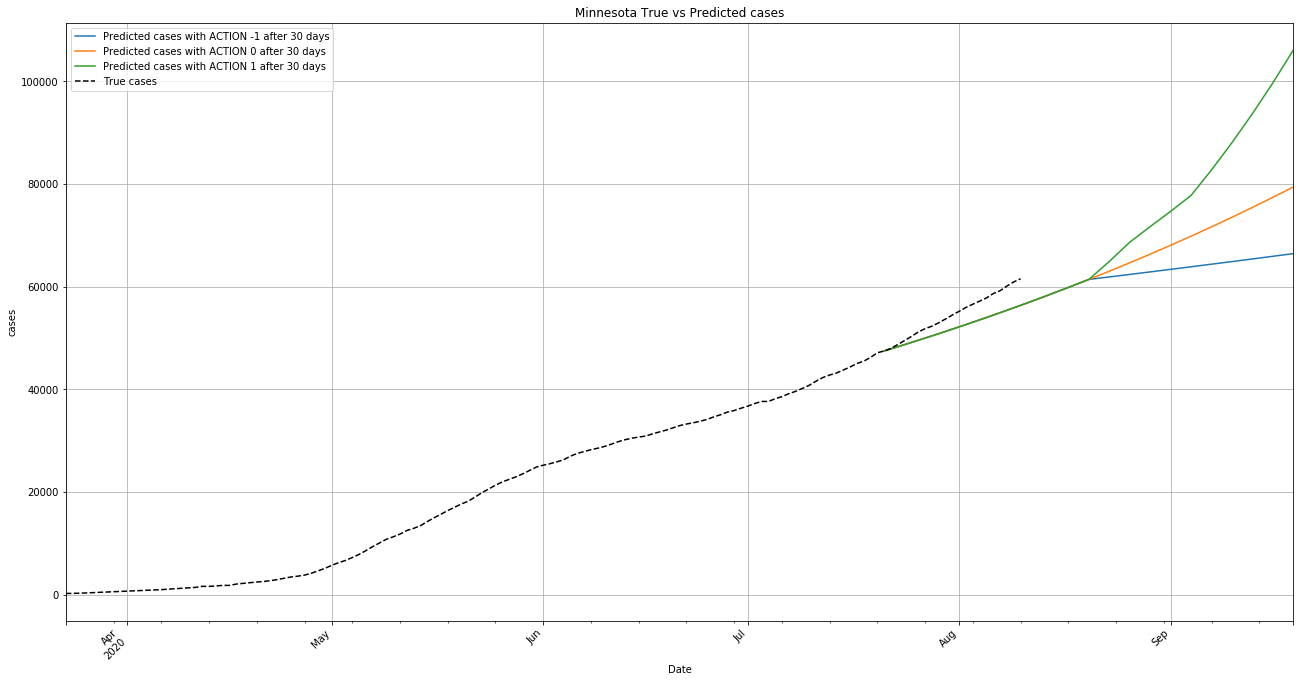

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


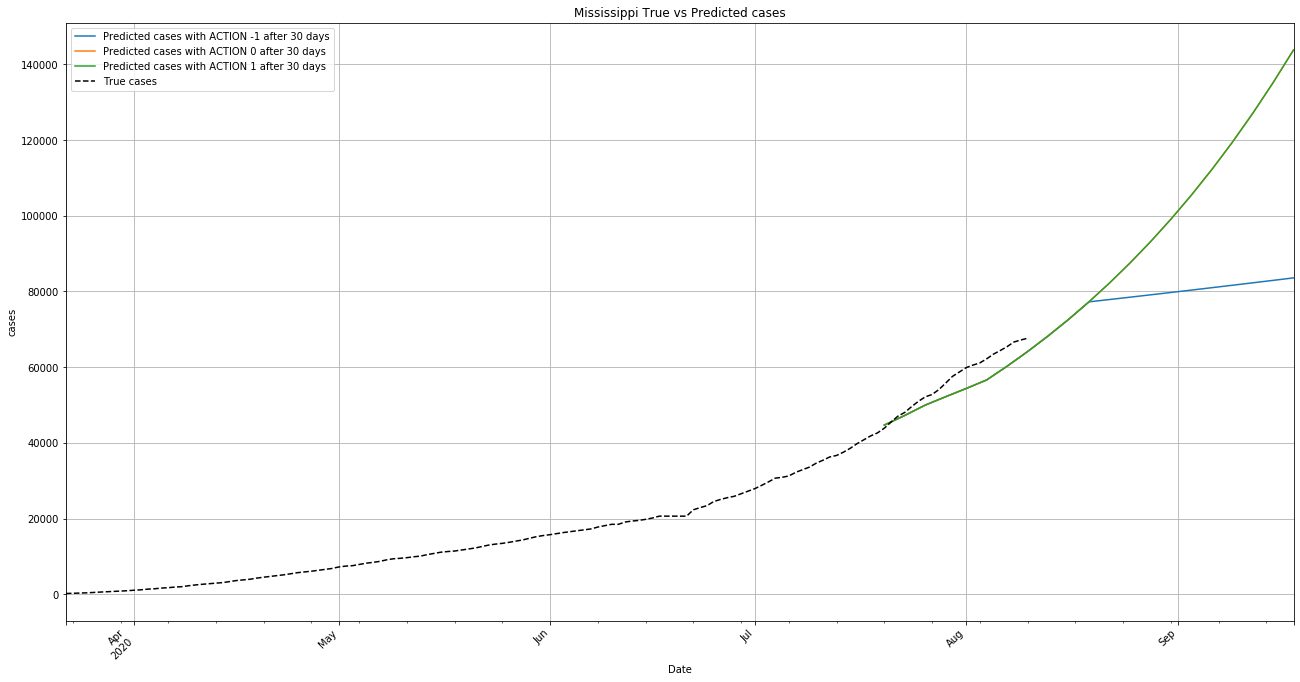

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


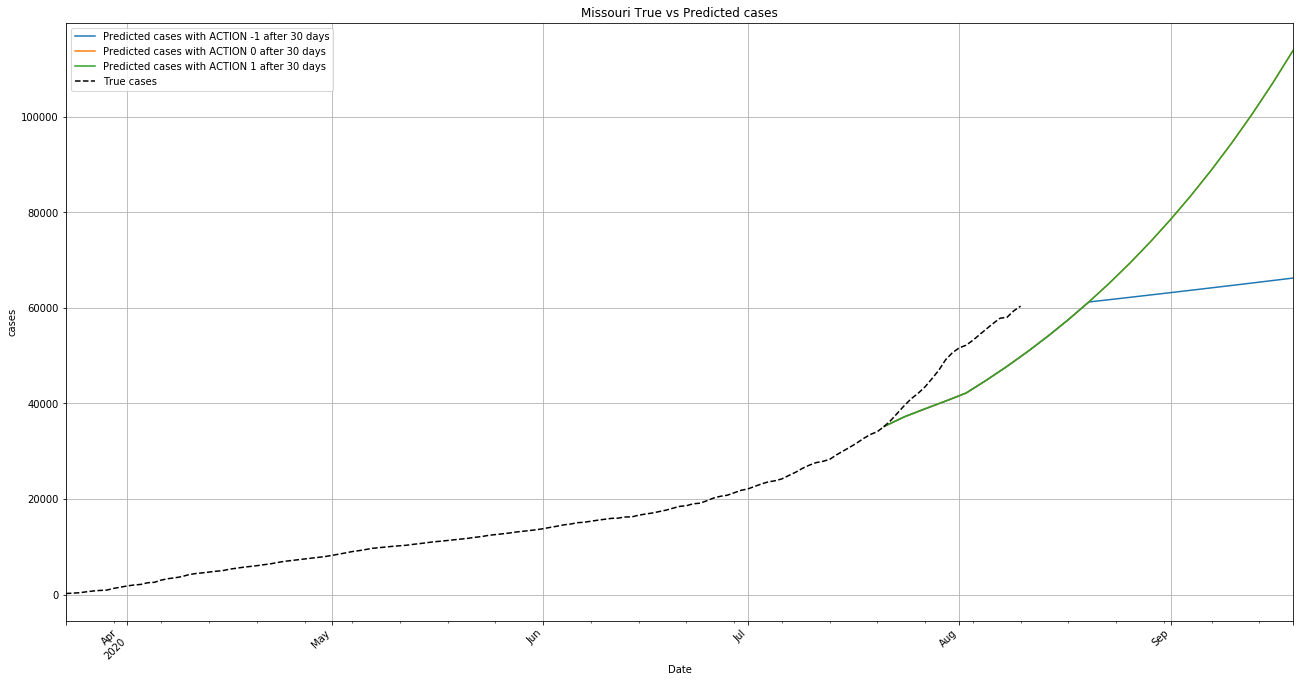

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


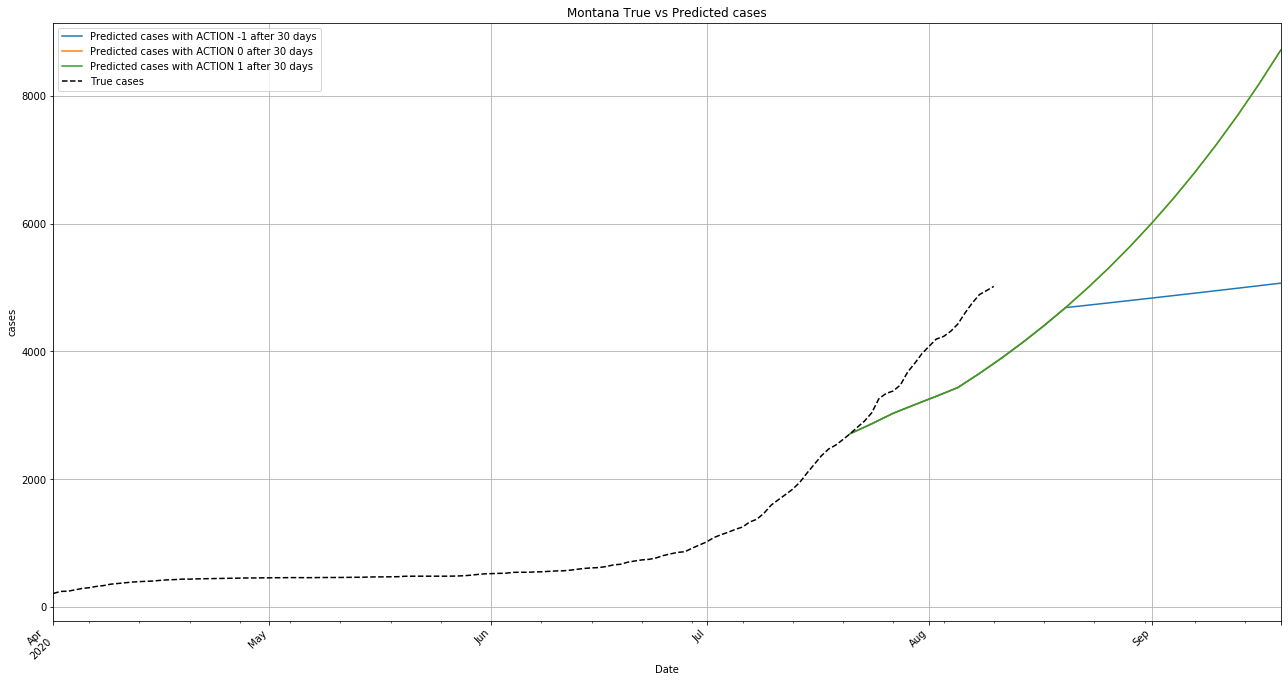

with action -1  STATE bef: 6.0  STATE aft: 8.0
with action 0  STATE bef: 6.0  STATE aft: 6.0
with action 1  STATE bef: 6.0  STATE aft: 51.0


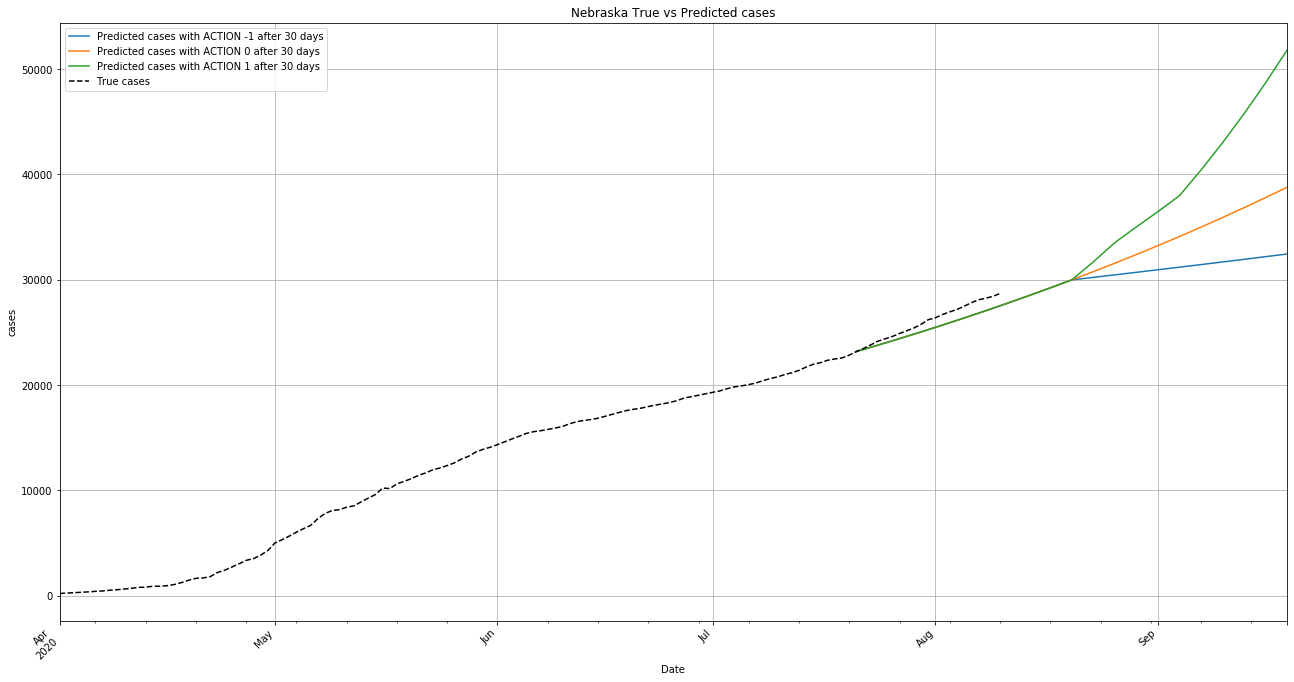

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


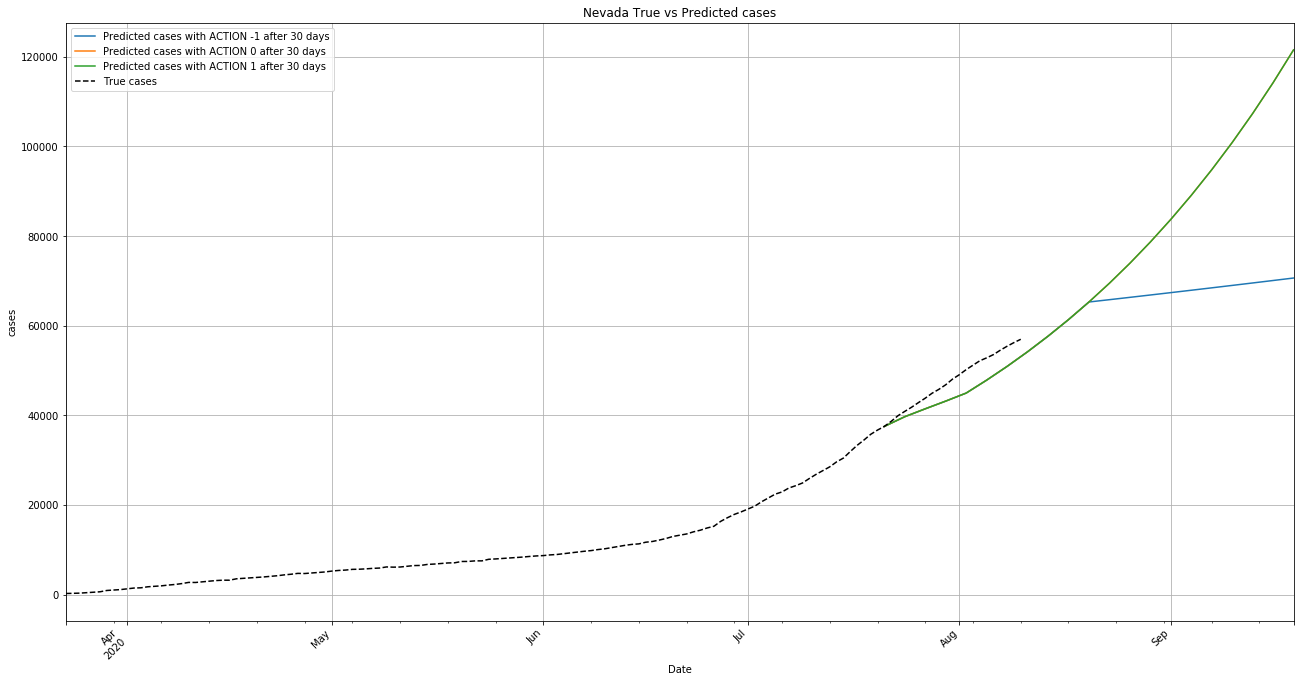

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


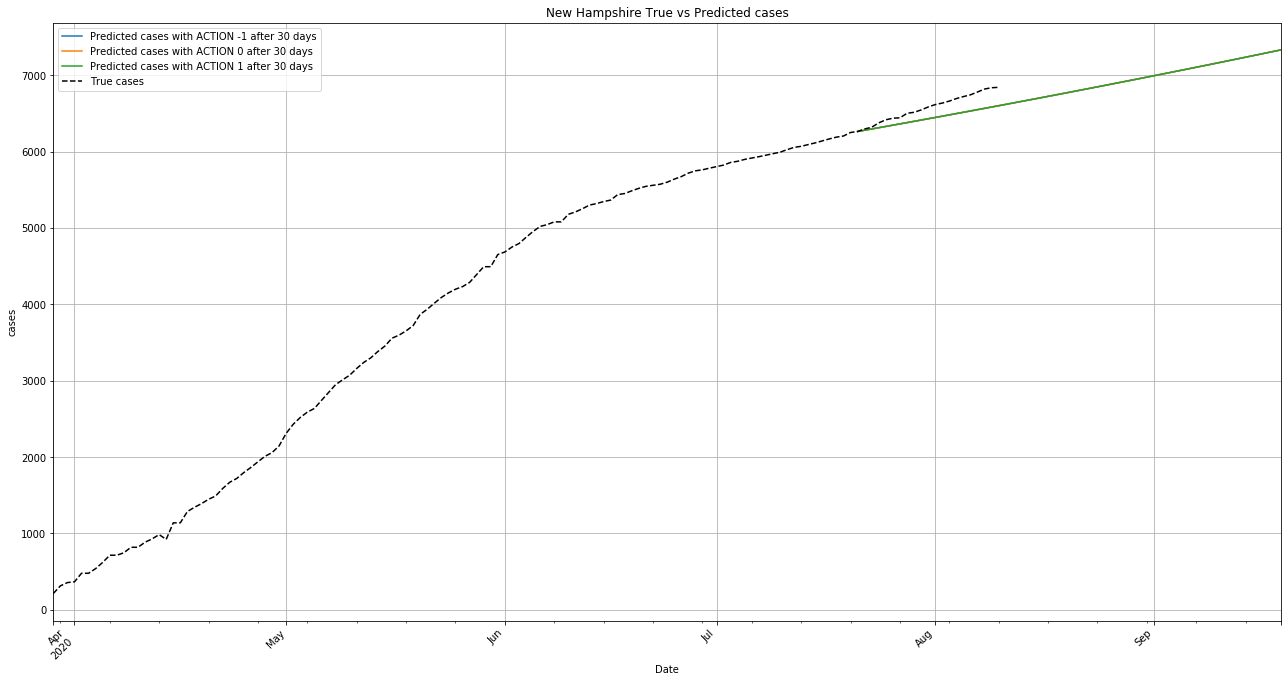

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


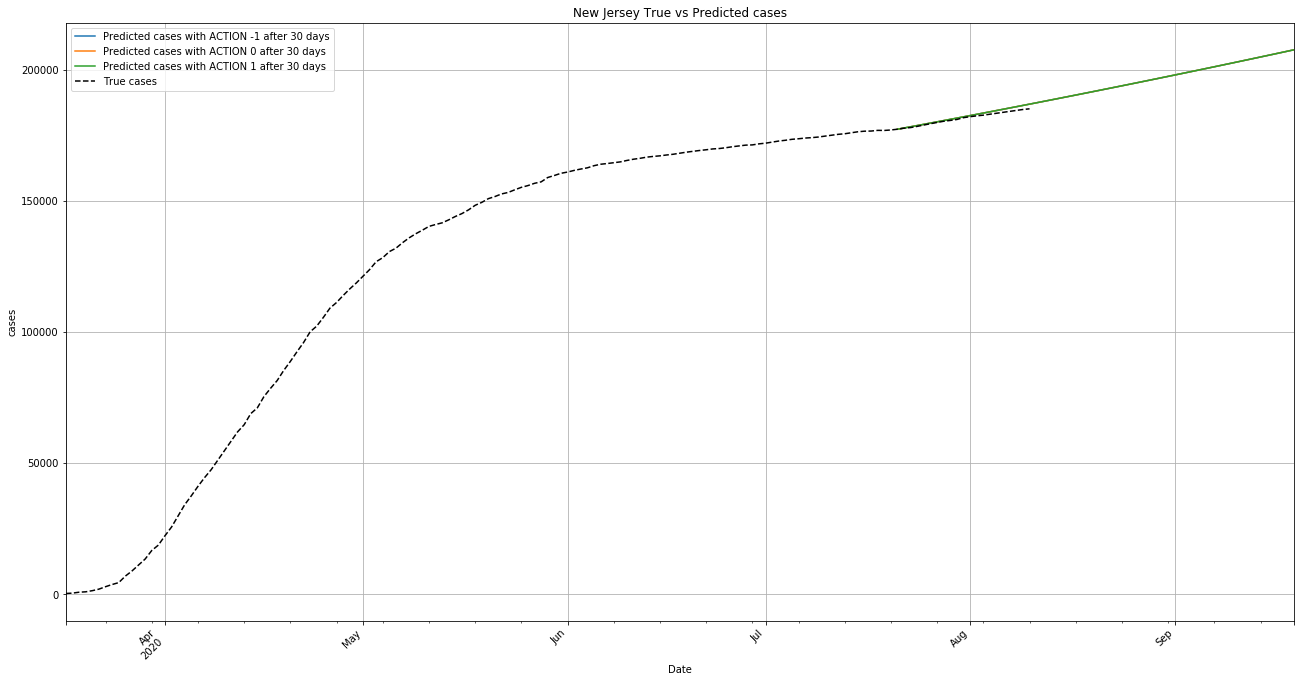

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


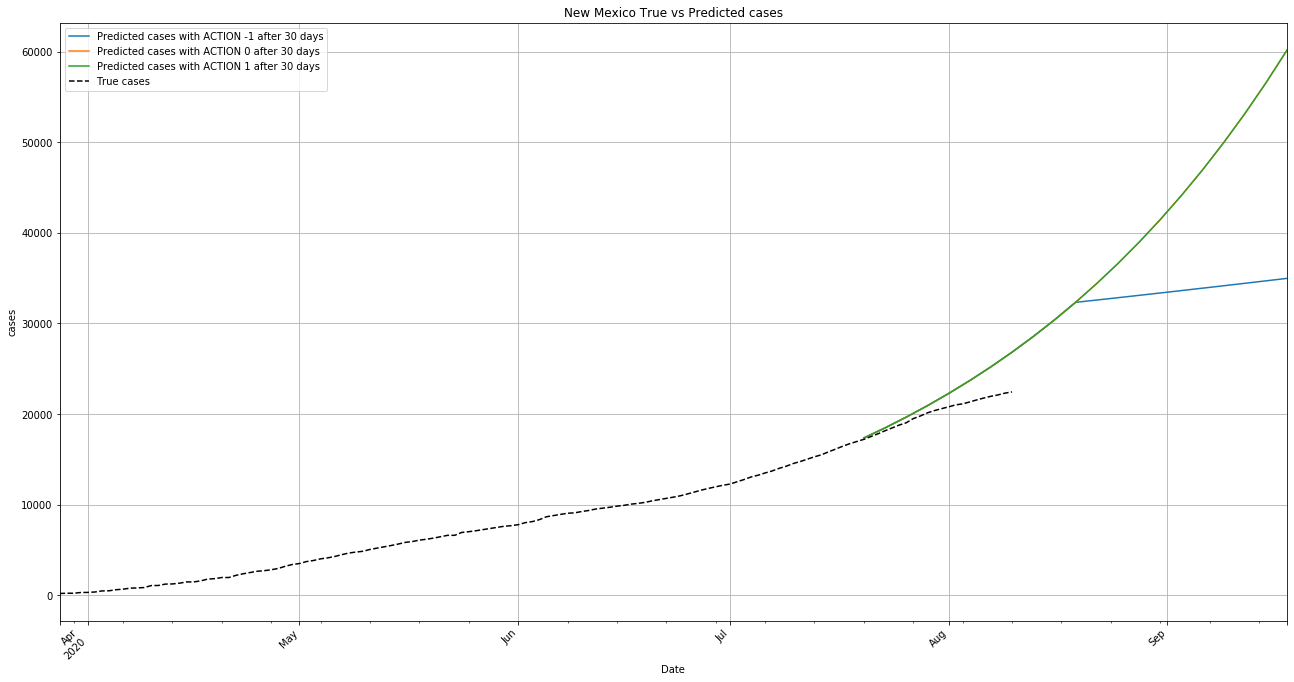

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


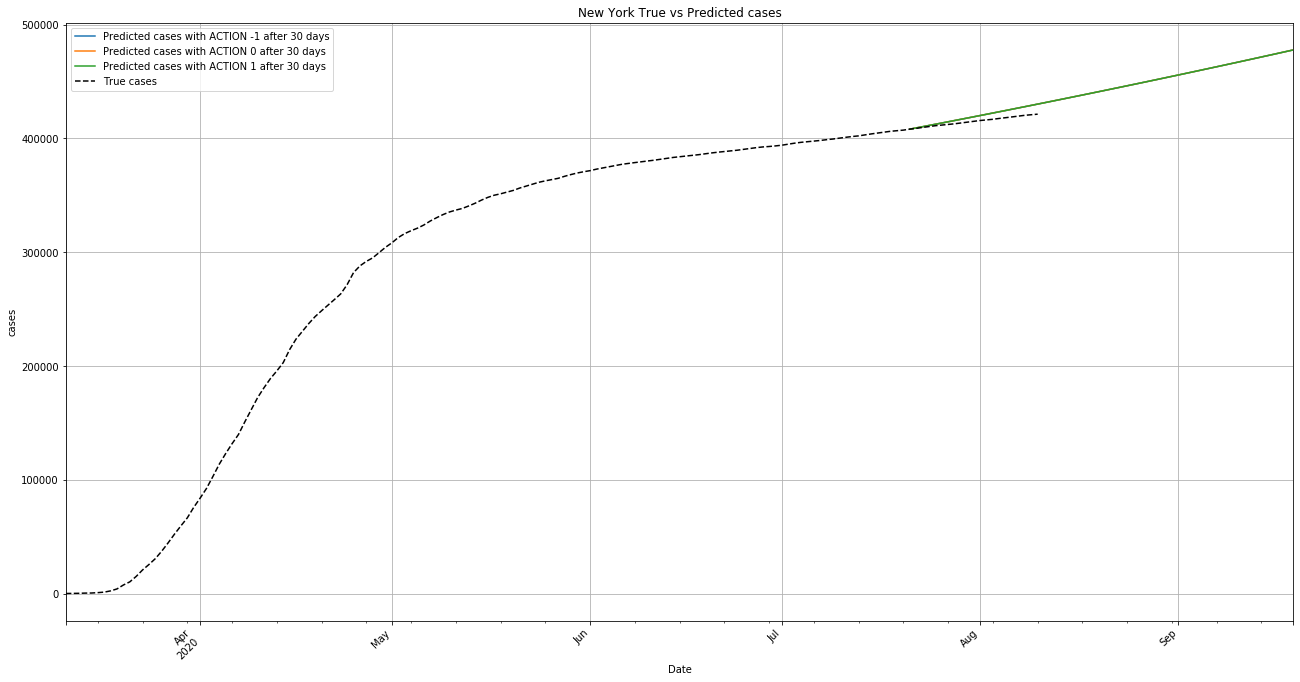

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


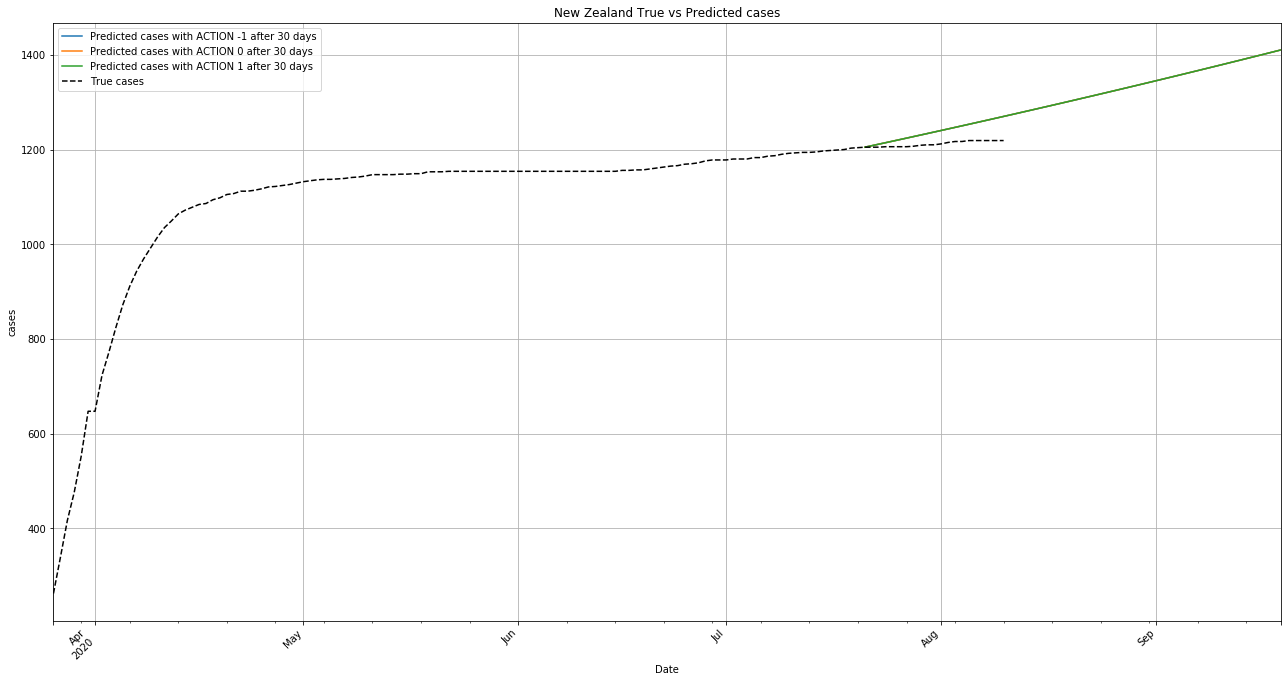

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


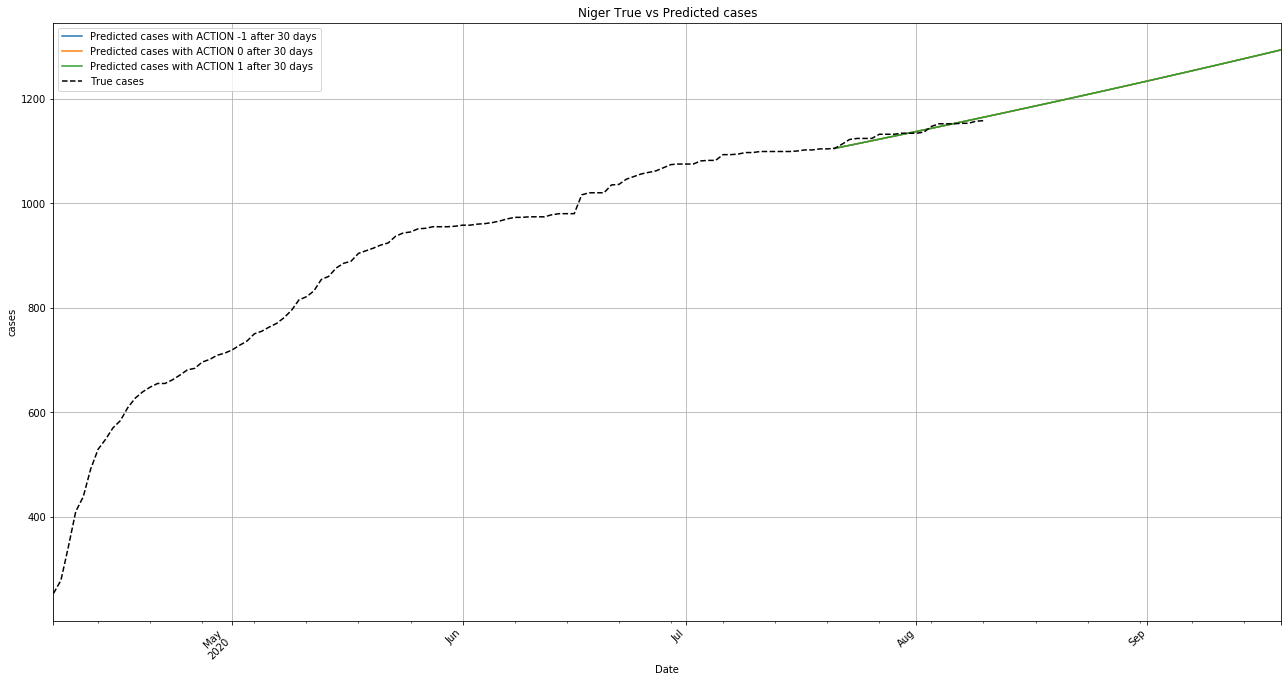

with action -1  STATE bef: 7.0  STATE aft: 8.0
with action 0  STATE bef: 7.0  STATE aft: 7.0
with action 1  STATE bef: 7.0  STATE aft: 48.0


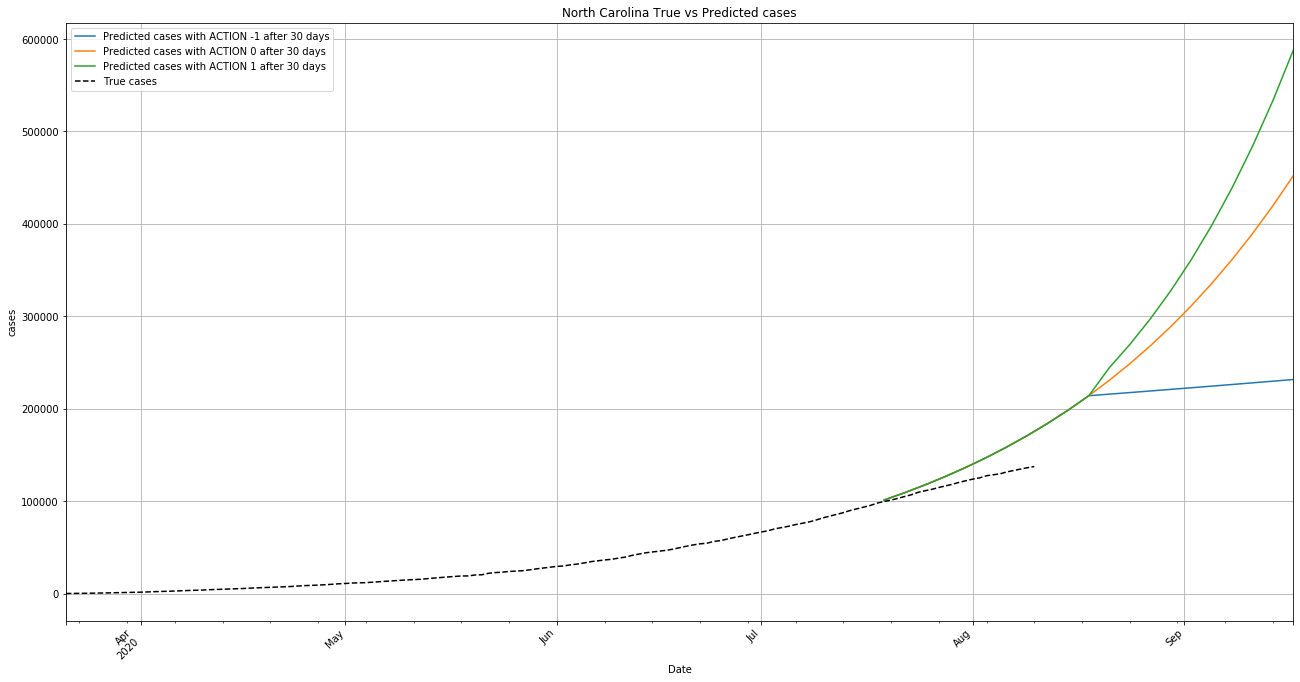

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


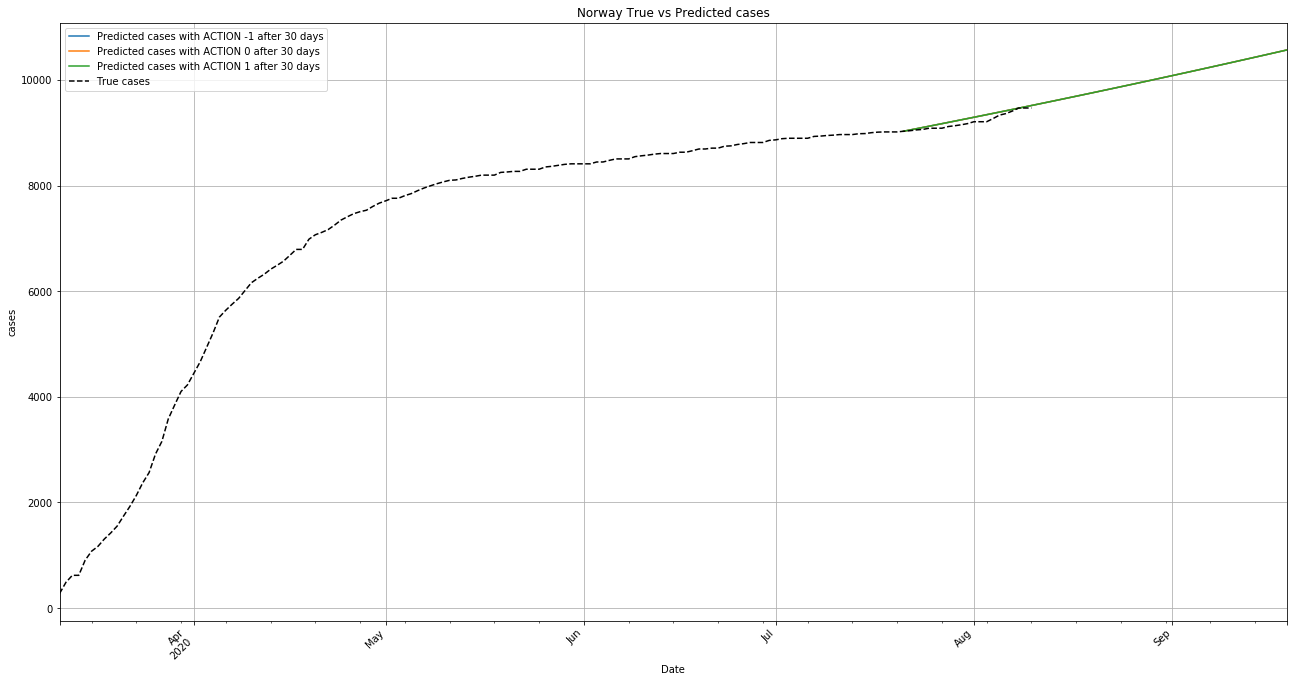

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


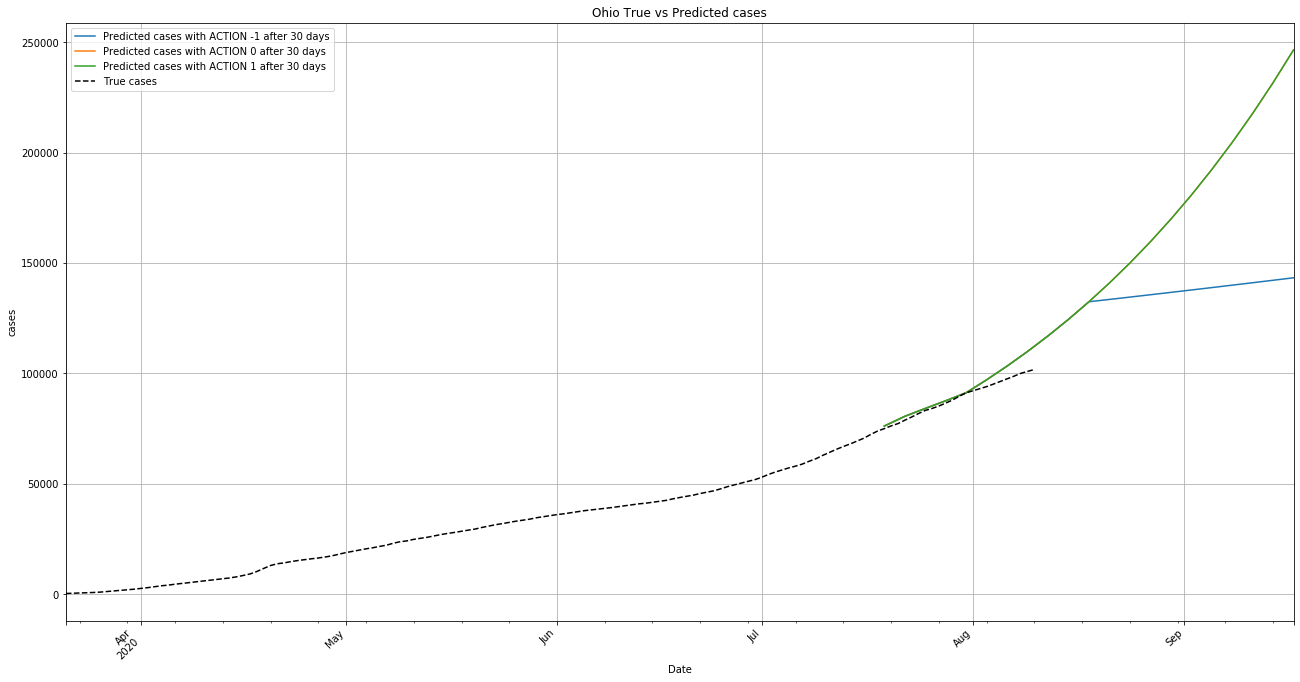

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


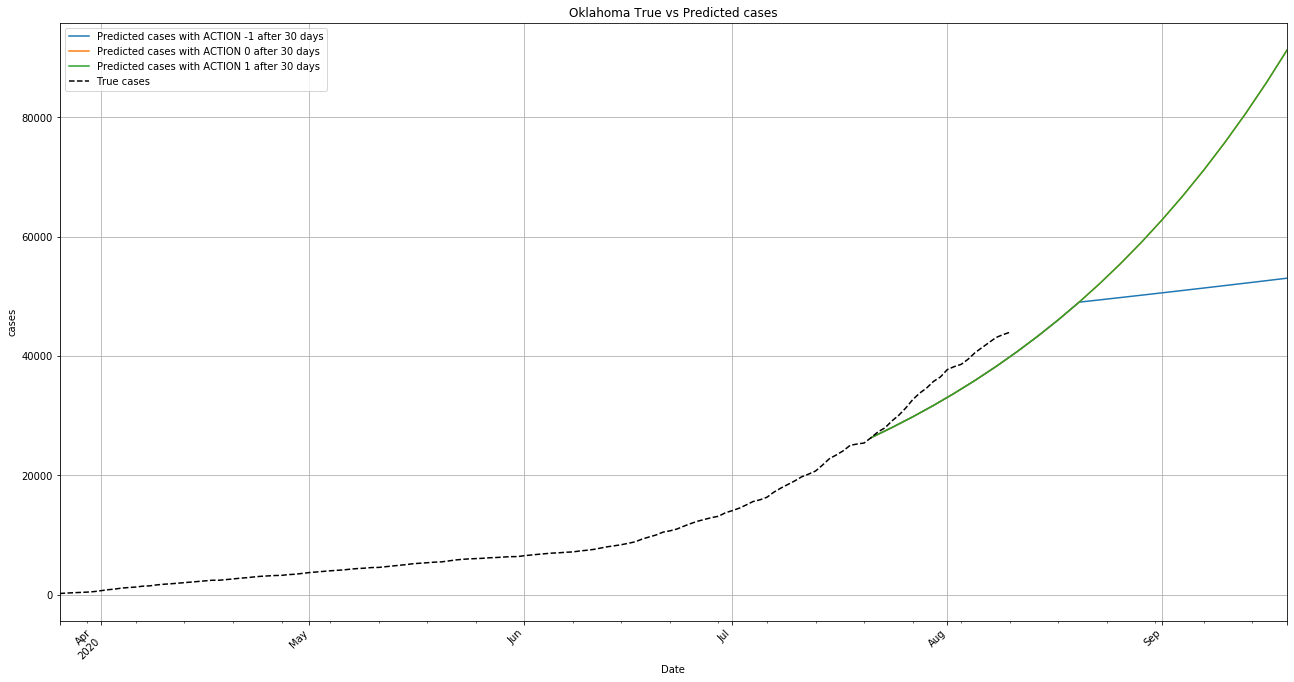

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


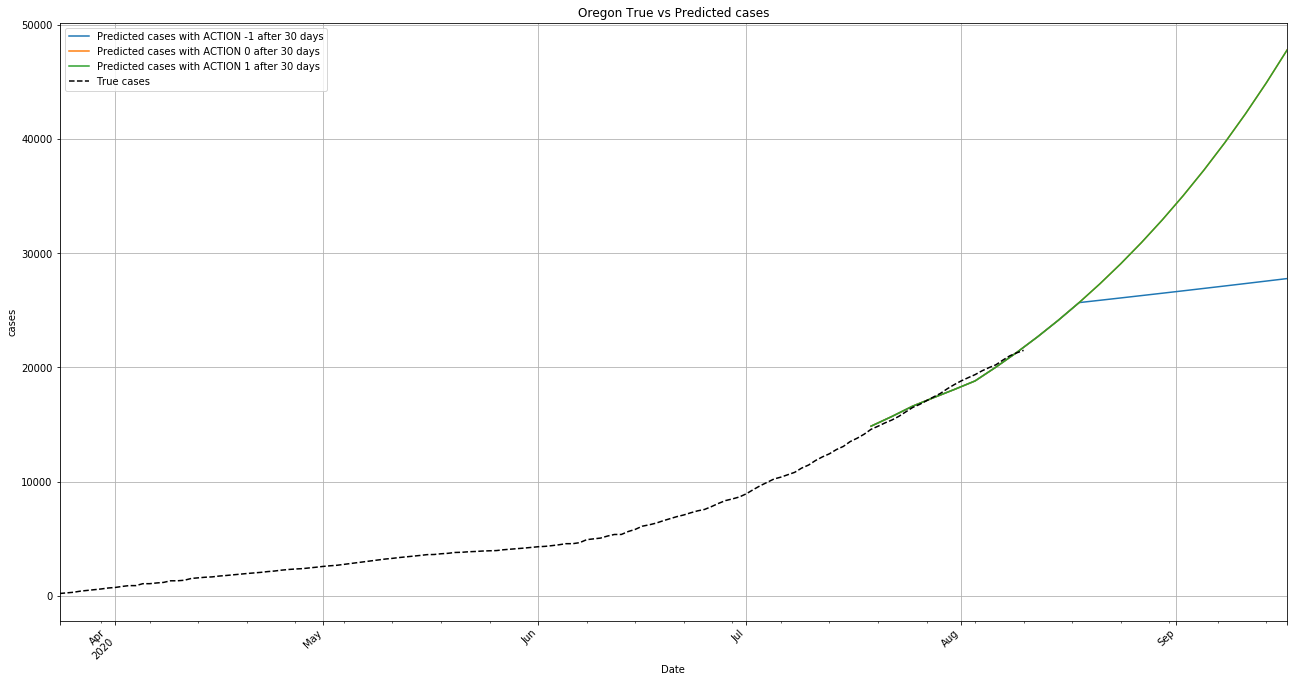

with action -1  STATE bef: 15.0  STATE aft: 8.0
with action 0  STATE bef: 15.0  STATE aft: 15.0
with action 1  STATE bef: 15.0  STATE aft: 40.0


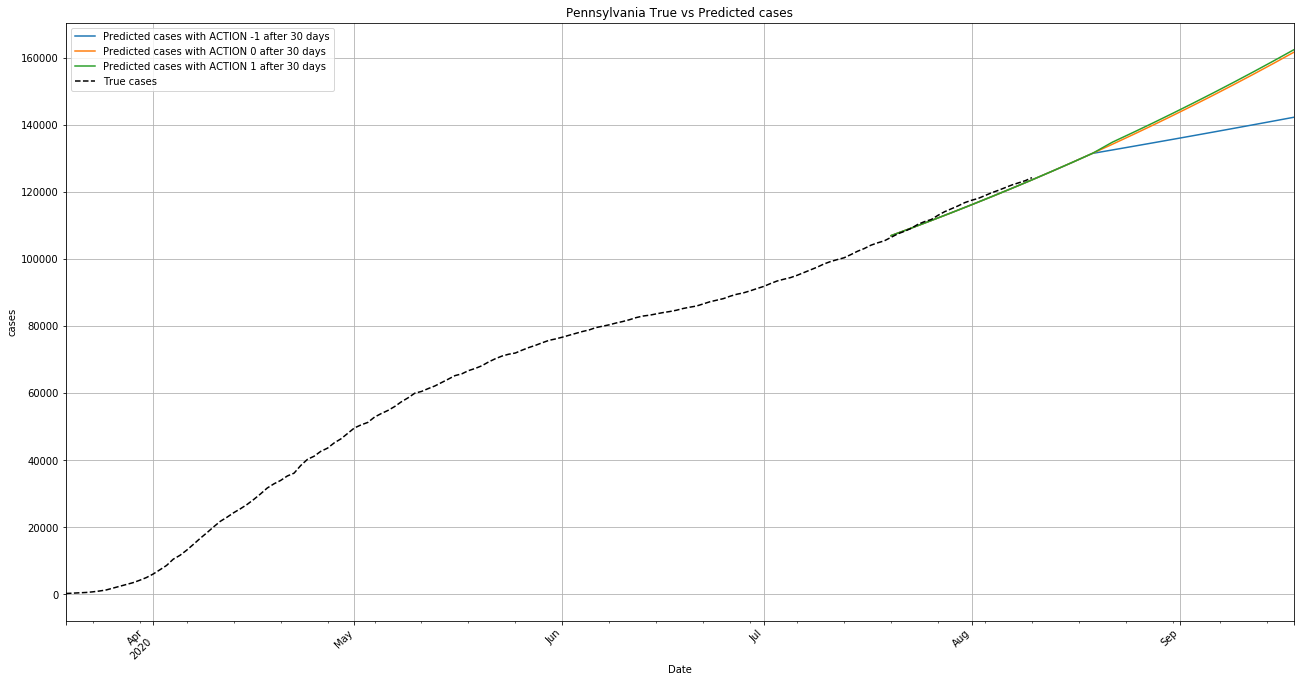

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


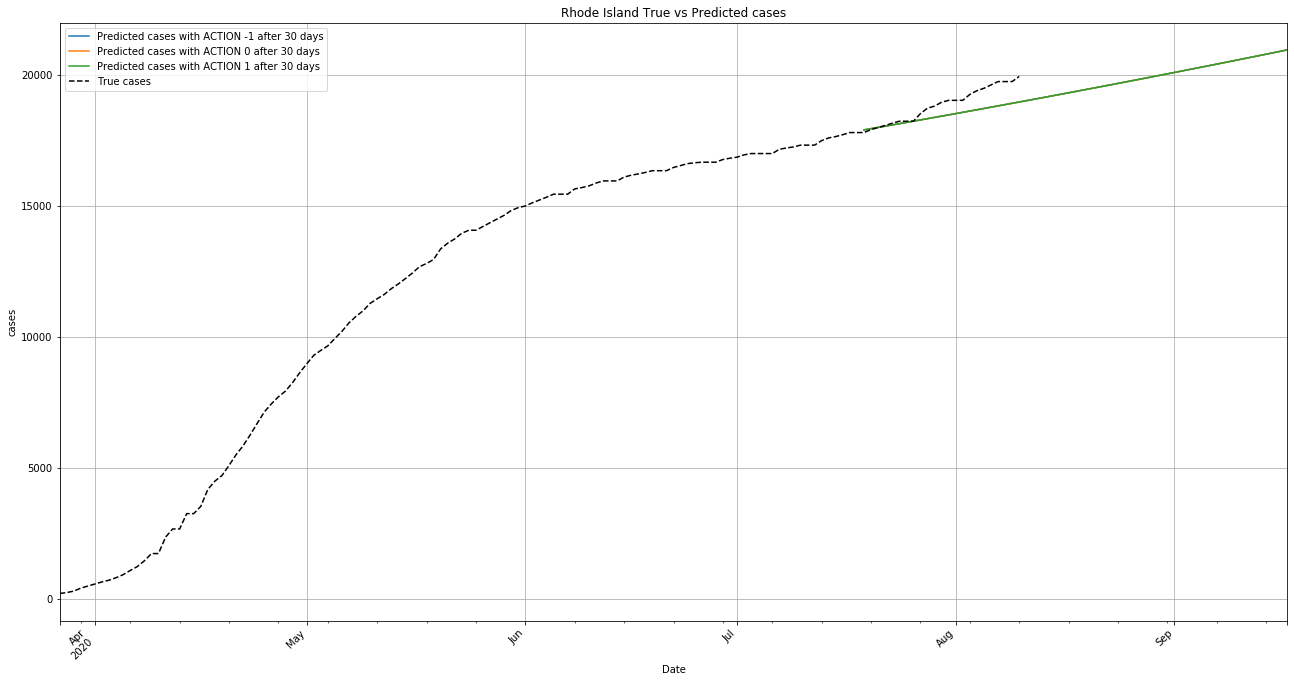

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


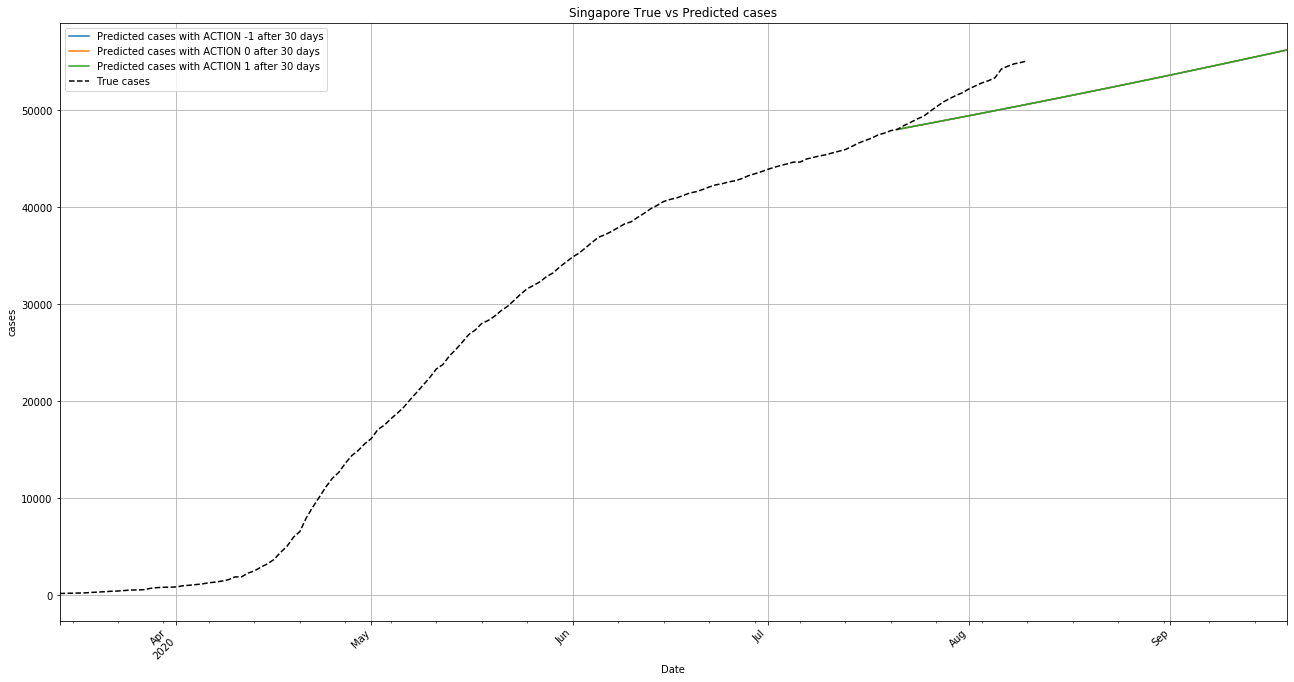

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


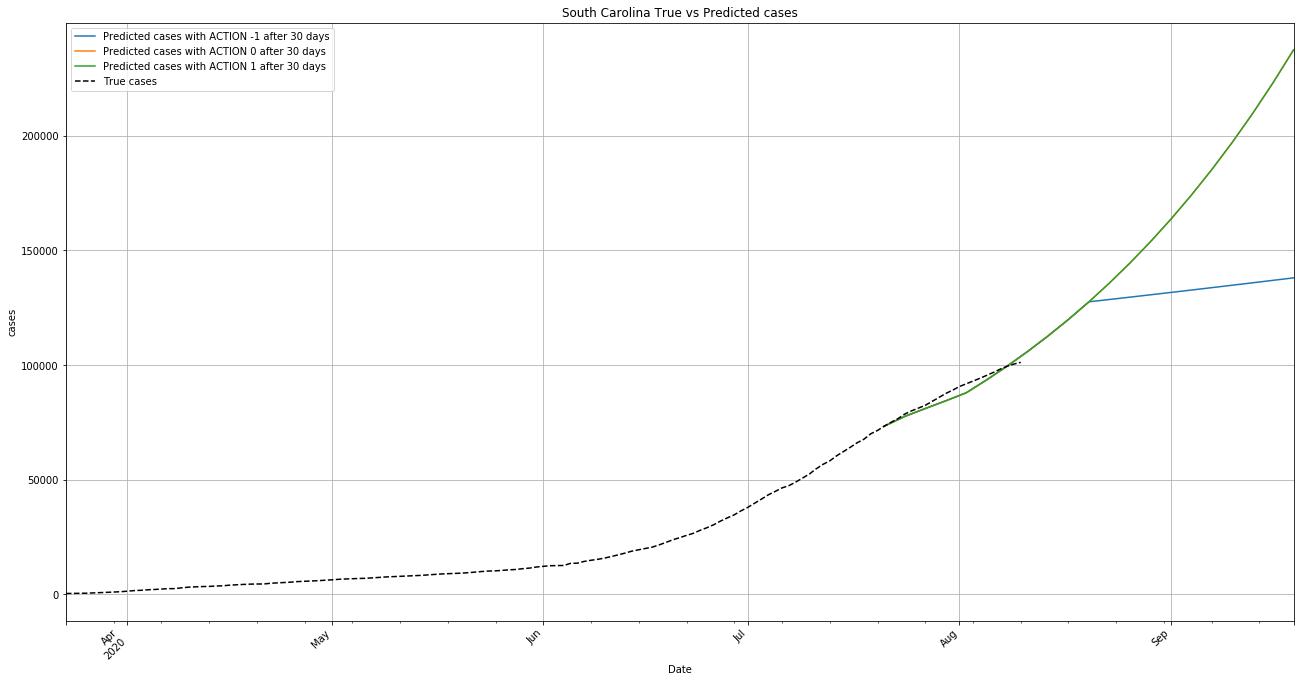

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


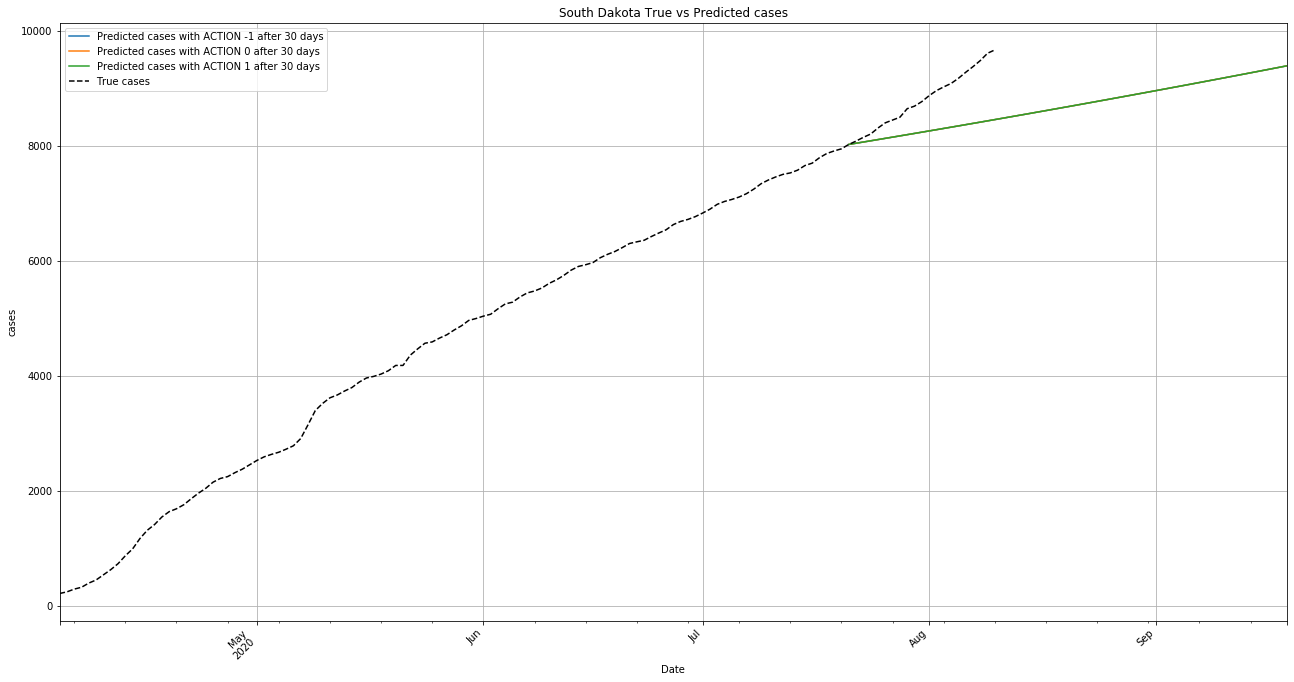

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


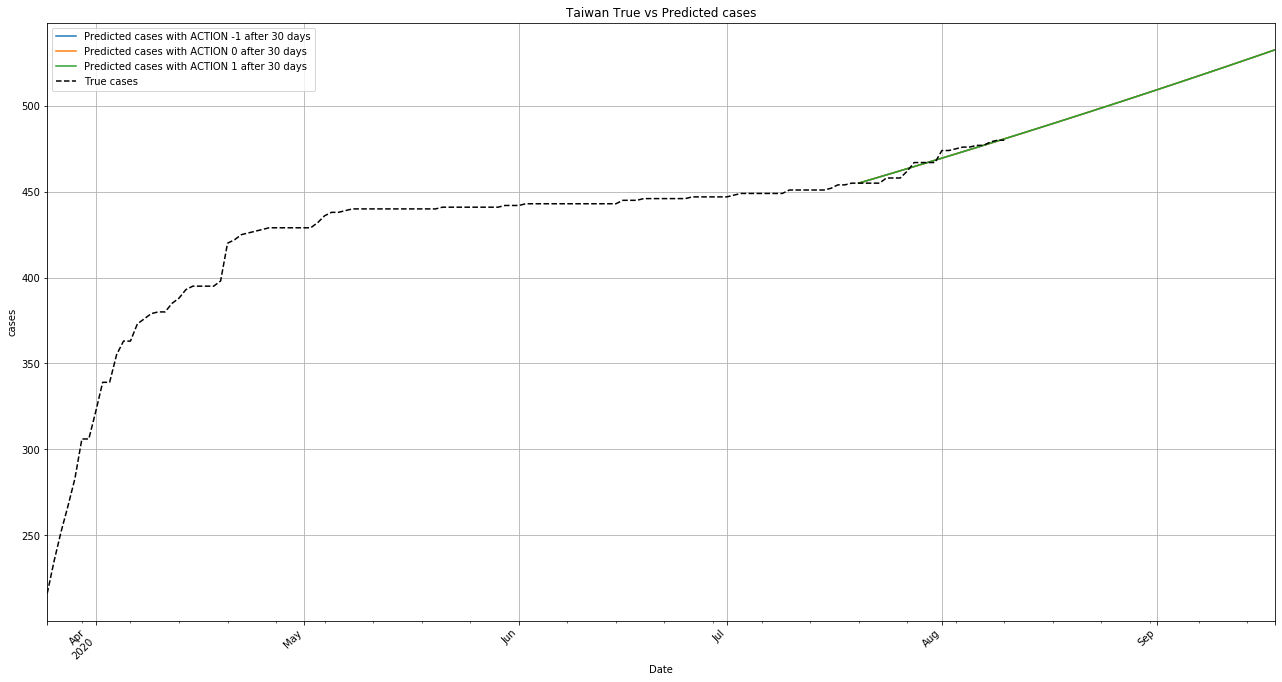

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


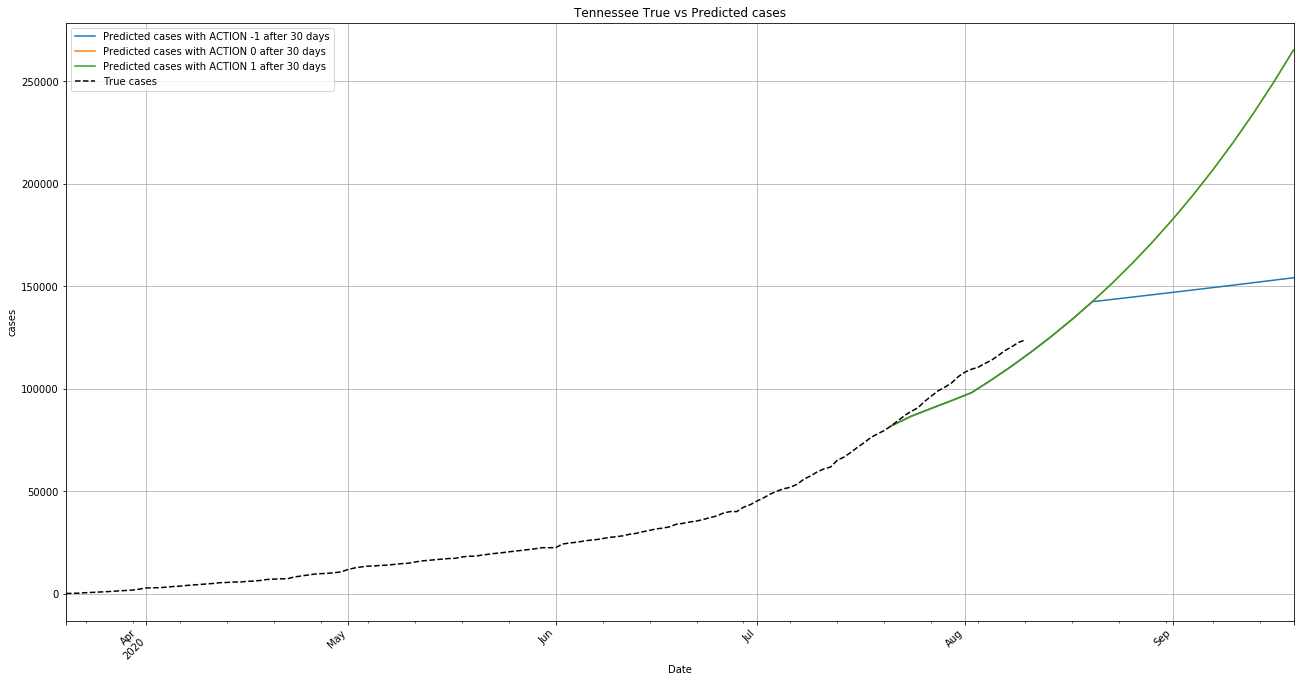

with action -1  STATE bef: 7.0  STATE aft: 8.0
with action 0  STATE bef: 7.0  STATE aft: 7.0
with action 1  STATE bef: 7.0  STATE aft: 48.0


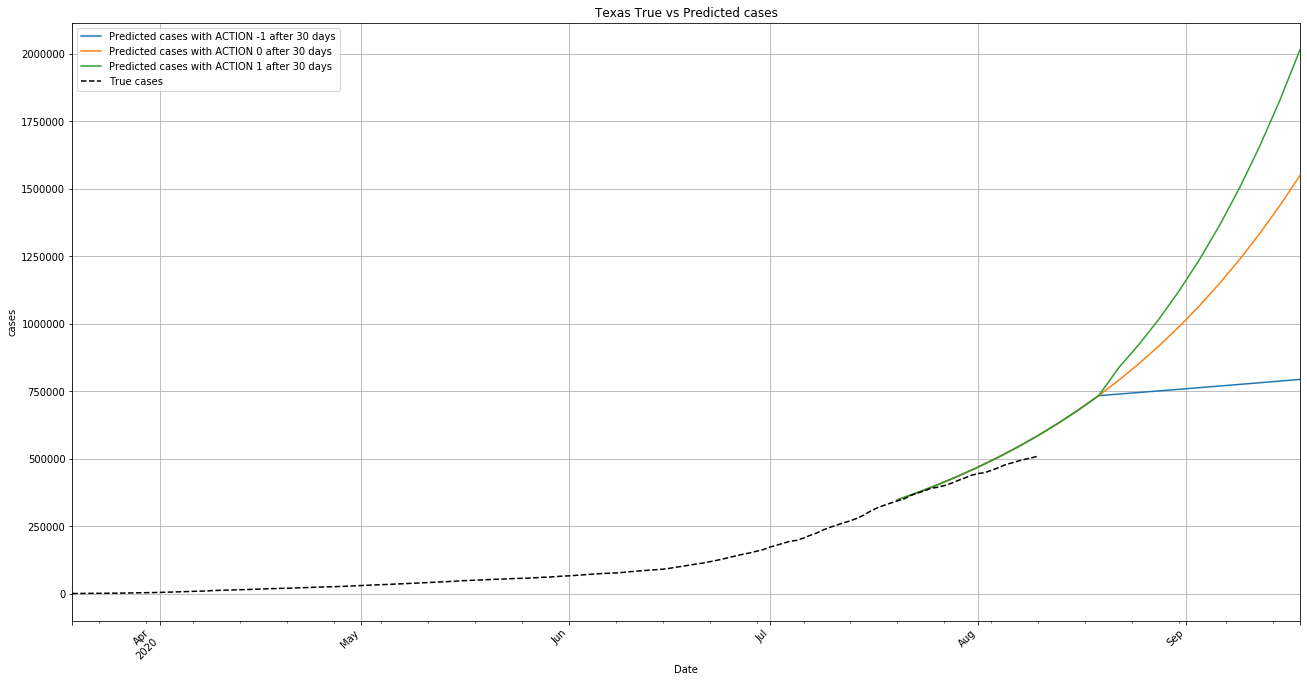

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


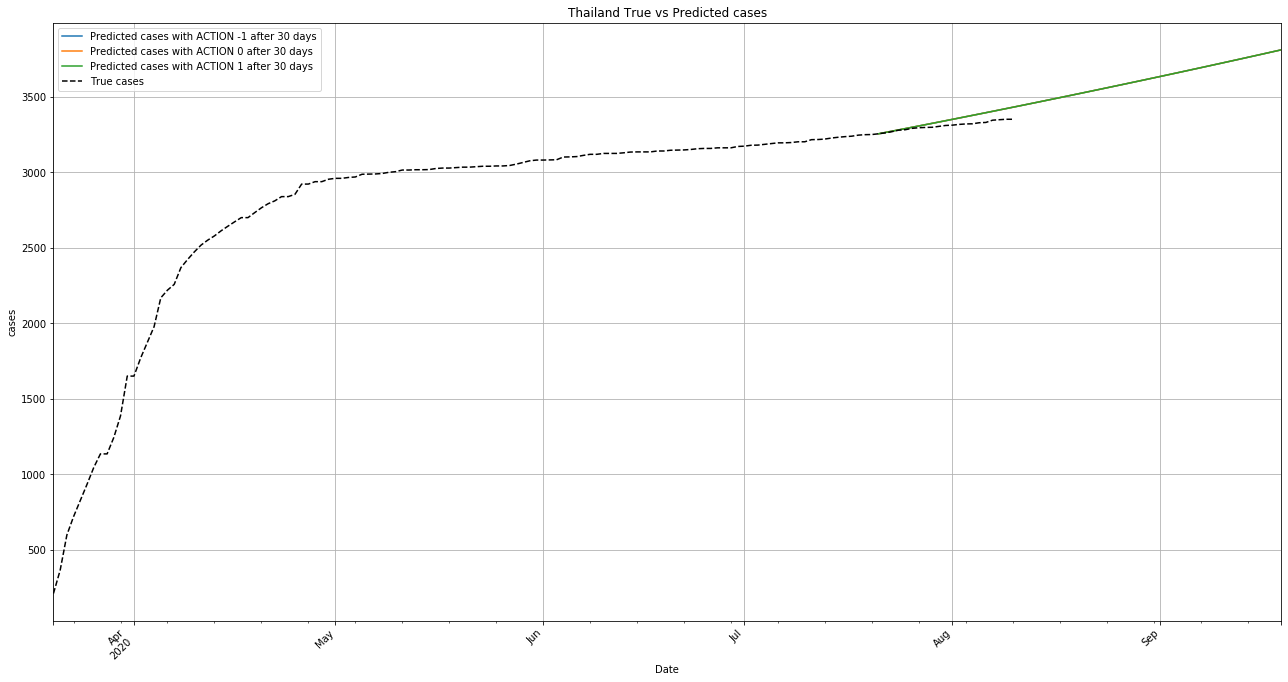

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


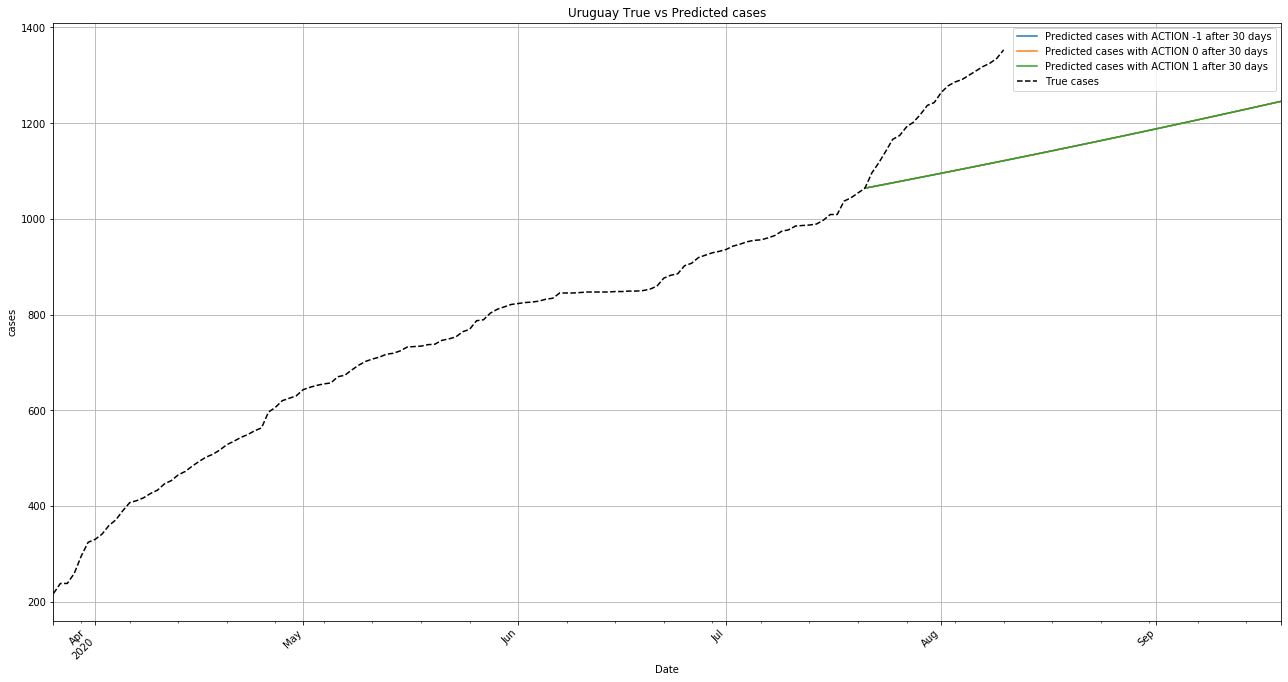

with action -1  STATE bef: 15.0  STATE aft: 8.0
with action 0  STATE bef: 15.0  STATE aft: 15.0
with action 1  STATE bef: 15.0  STATE aft: 40.0


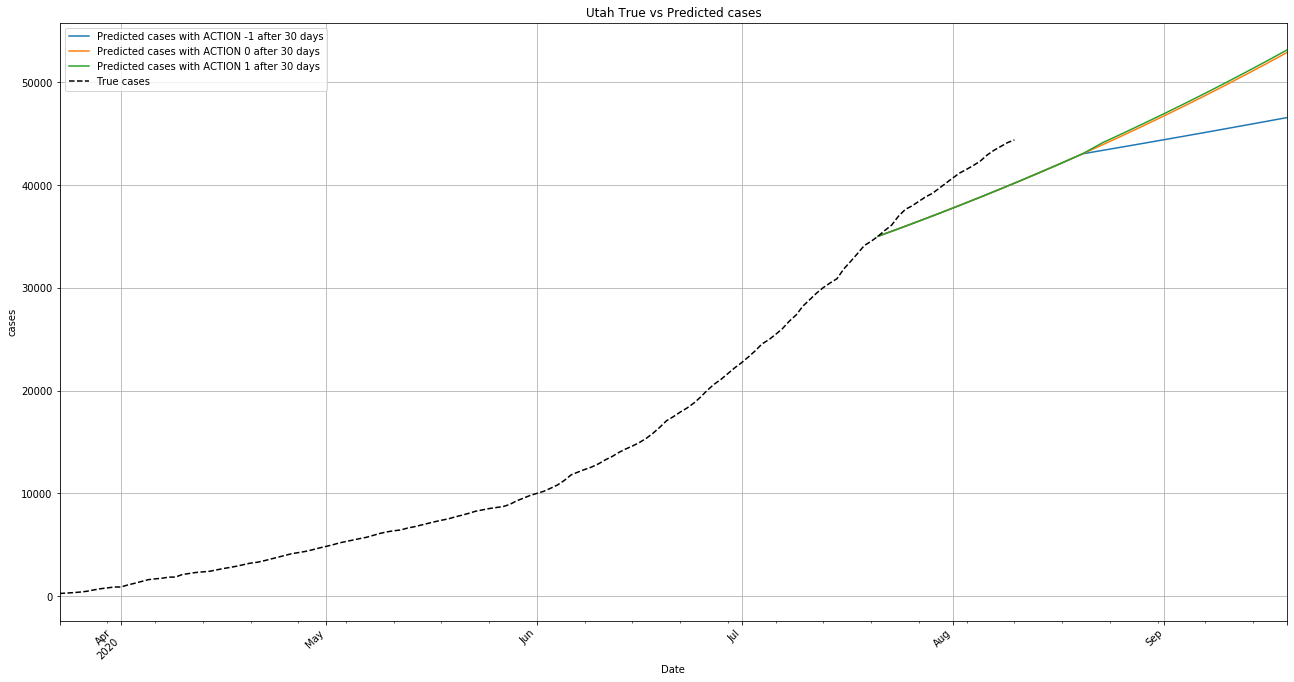

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


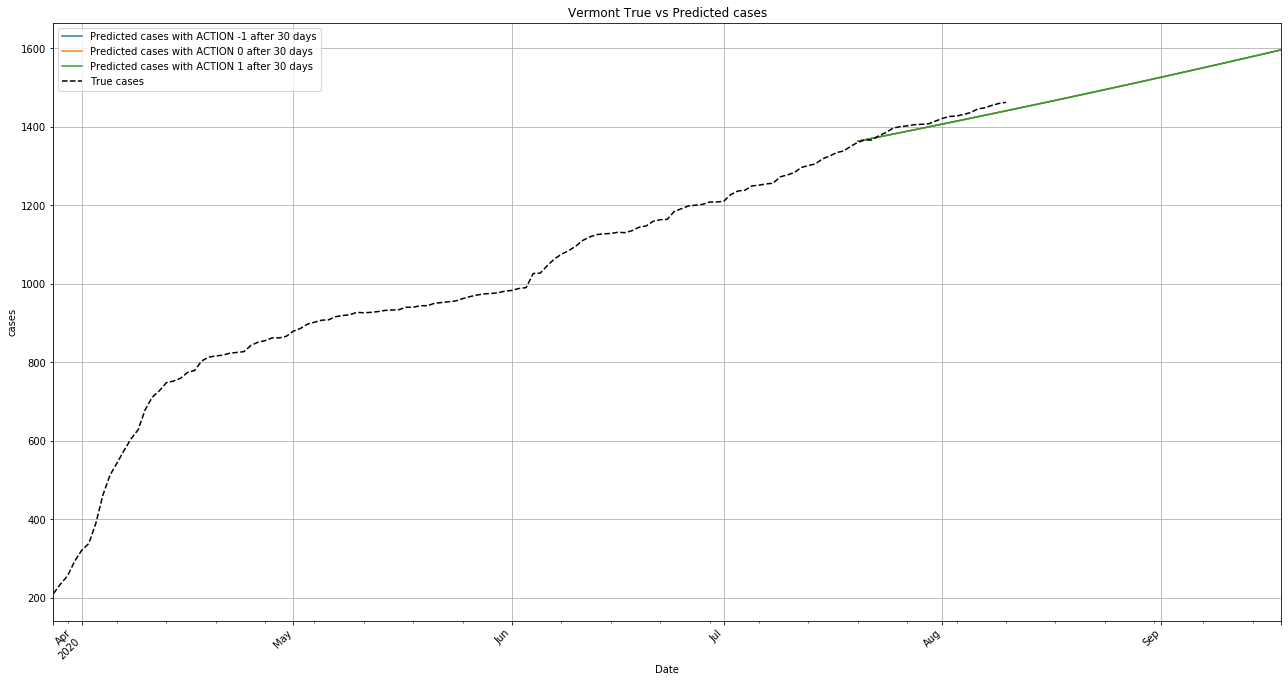

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


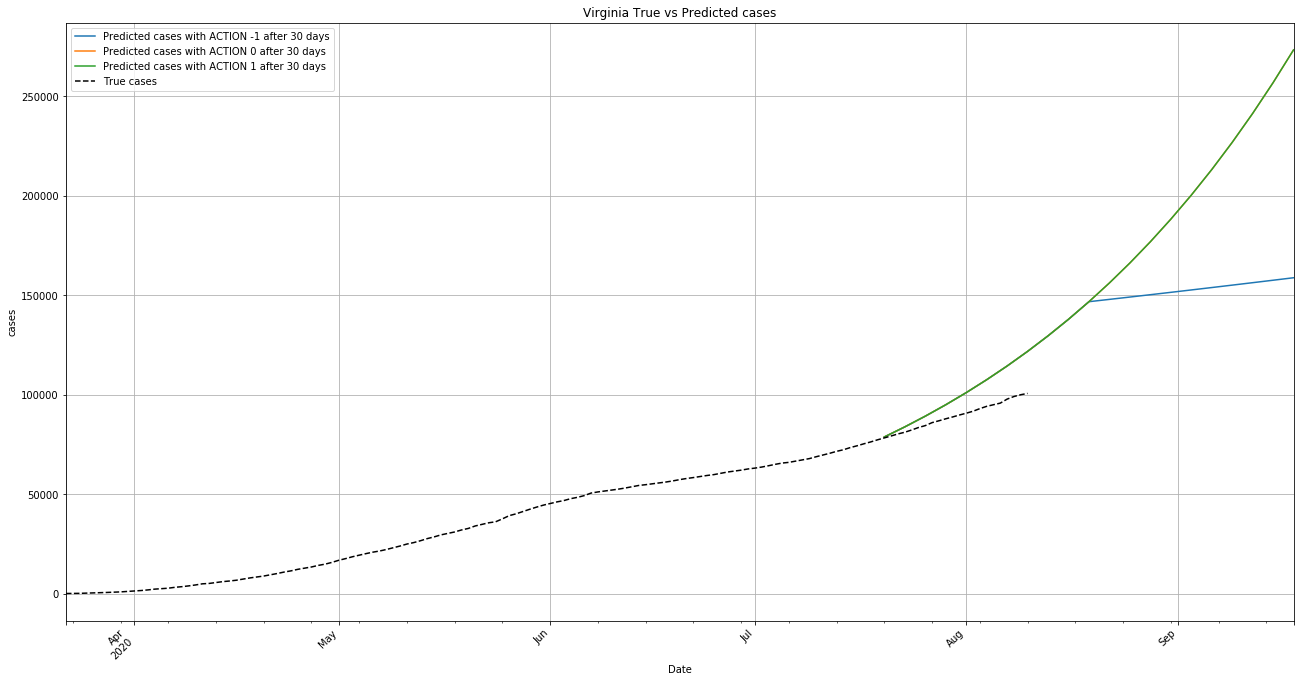

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


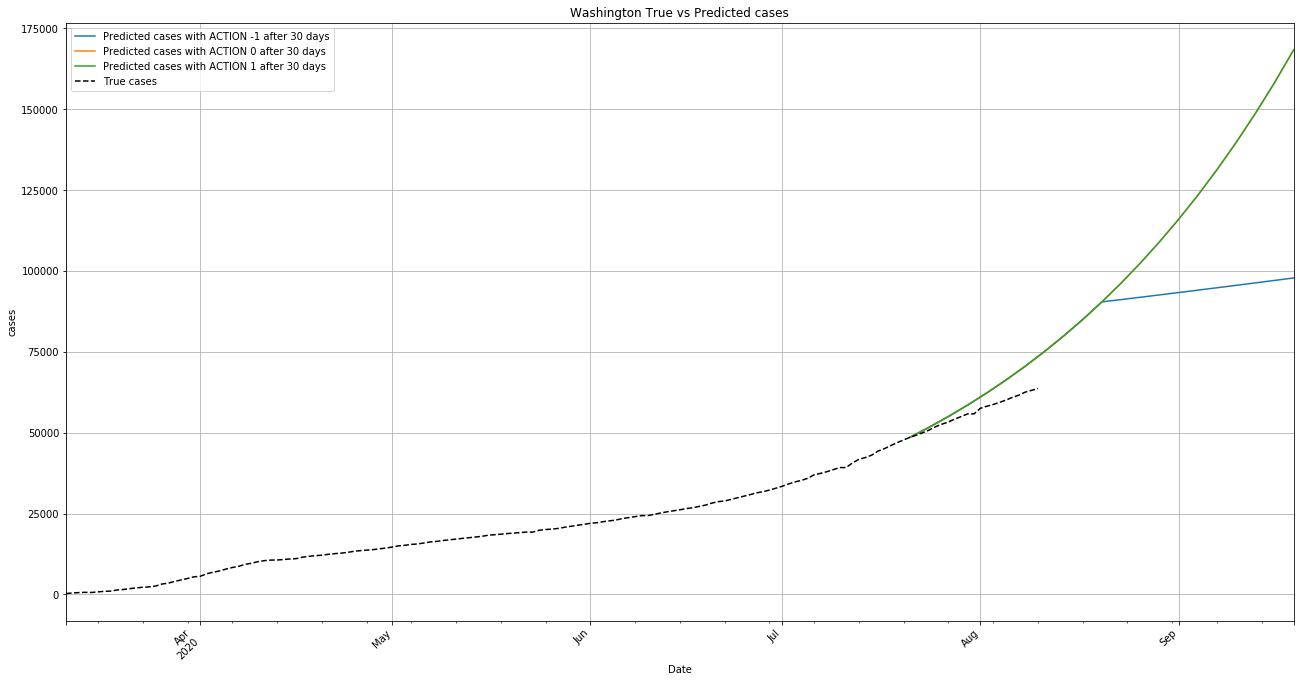

with action -1  STATE bef: 7.0  STATE aft: 8.0
with action 0  STATE bef: 7.0  STATE aft: 7.0
with action 1  STATE bef: 7.0  STATE aft: 48.0


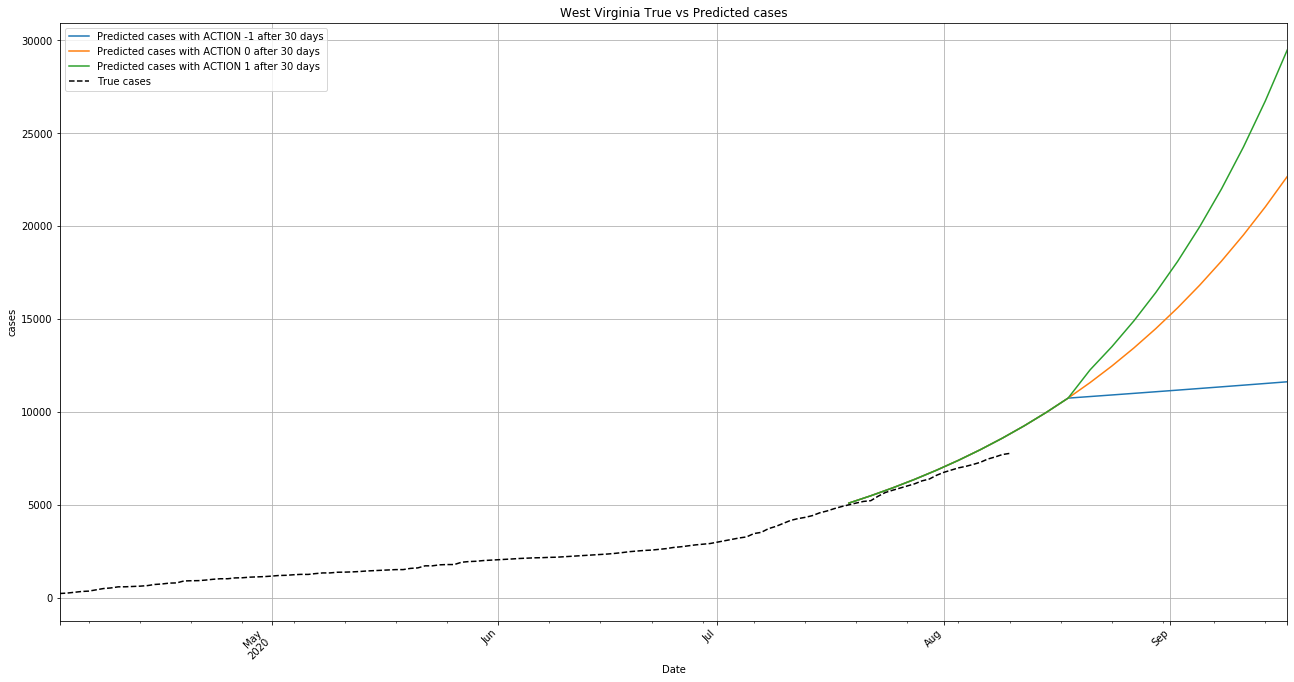

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


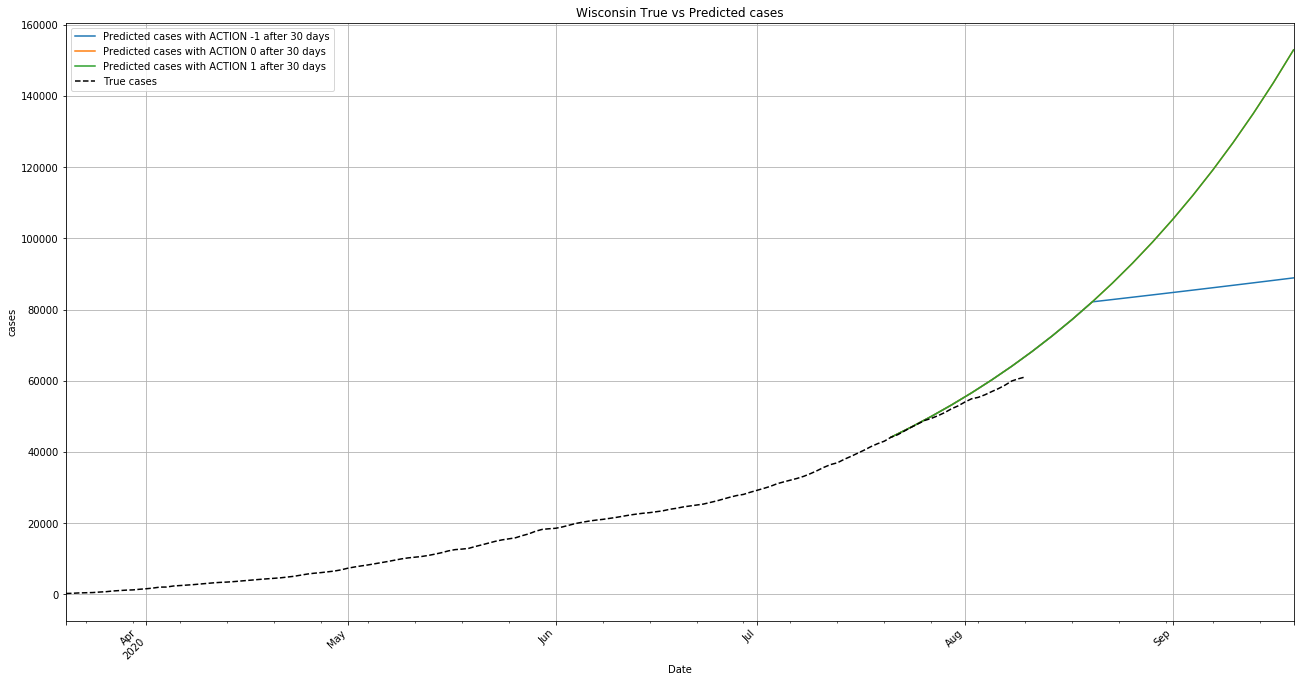

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


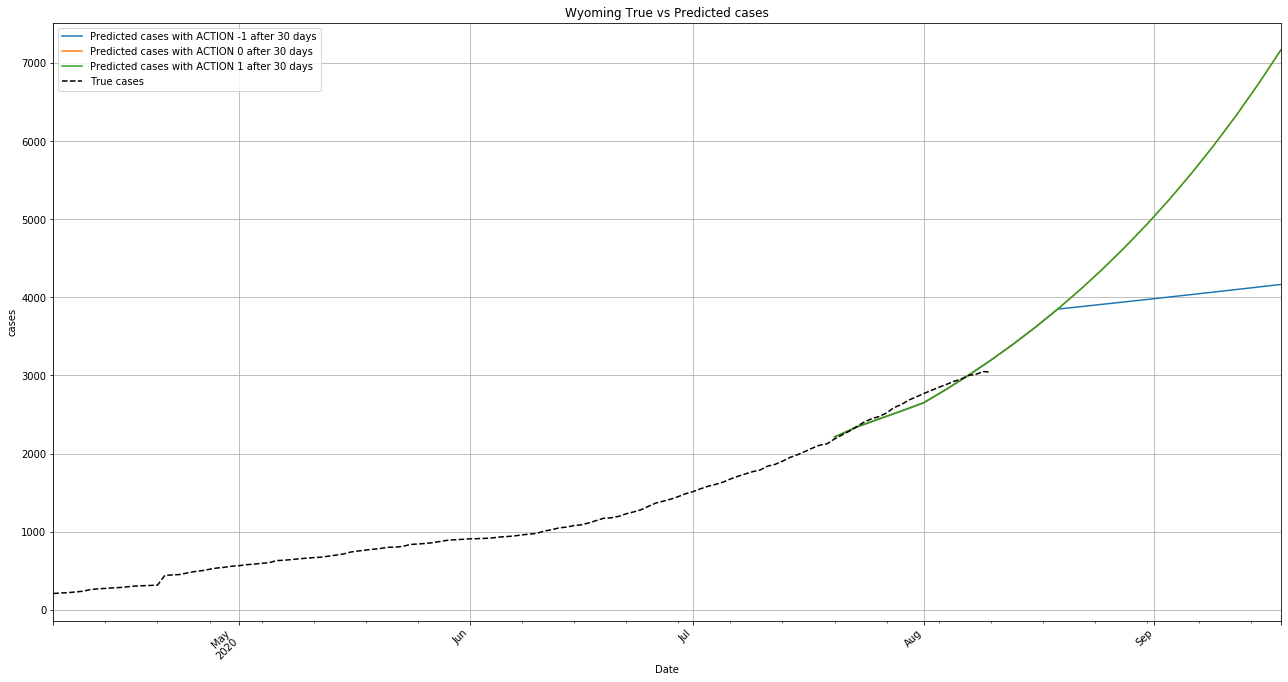

In [148]:
for region in m.df_trained.index:
    plot_pred_action(m, region, df, 60, 30, from_first=False)

with action -1  STATE bef: 5.0  STATE aft: 8.0
with action 0  STATE bef: 5.0  STATE aft: 5.0
with action 1  STATE bef: 5.0  STATE aft: 5.0


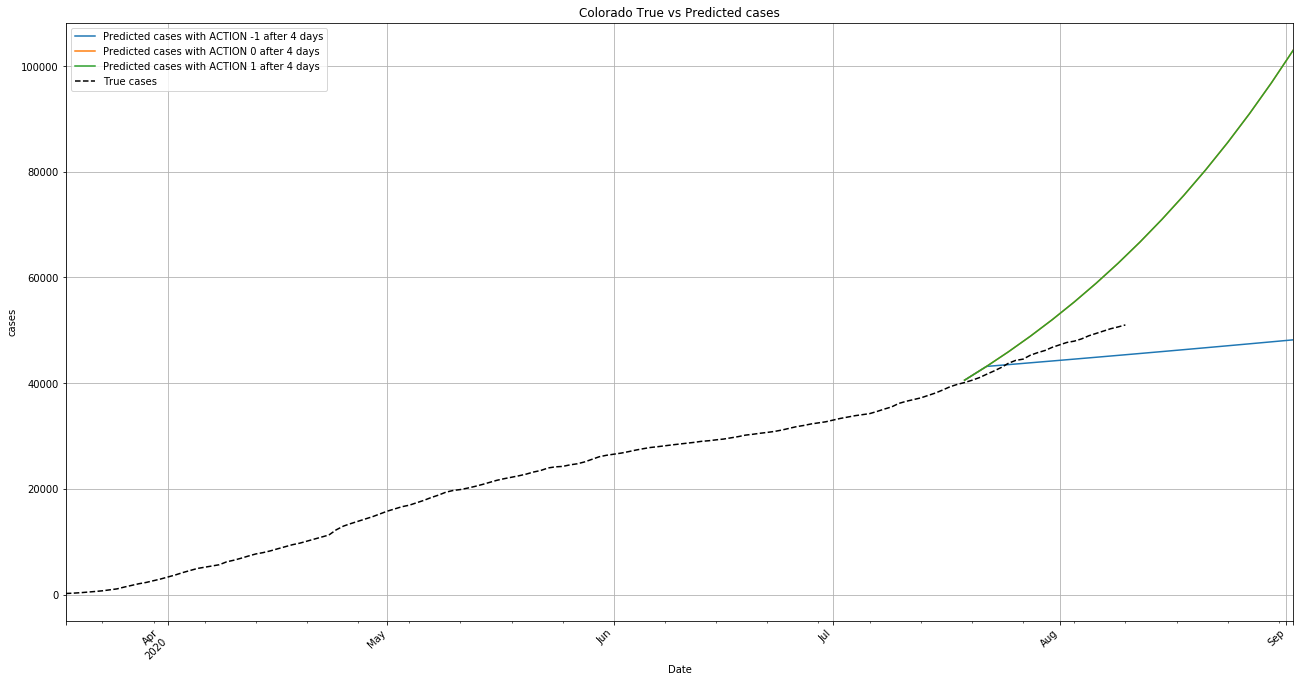

In [126]:
plot_pred_action(m, "Colorado", df, 45, 4, from_first=False)

with action -1  STATE bef: 8.0  STATE aft: 8.0
with action 0  STATE bef: 8.0  STATE aft: 8.0
with action 1  STATE bef: 8.0  STATE aft: 8.0


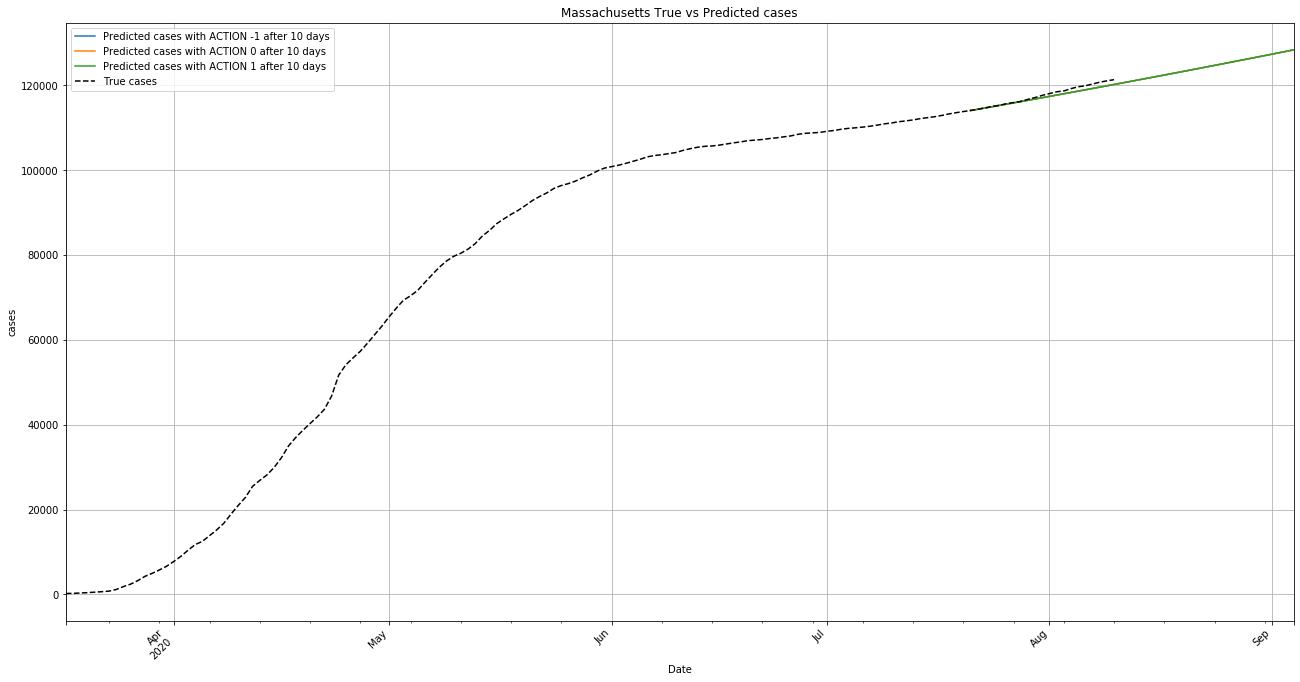

In [119]:
m.verbose = 3
plot_pred_action(m, "Massachusetts", df, 45, 10, from_first=False)

## $\textbf{Counterfactual analysis}$

In [40]:
# Setting parameters
file = '08_15_2020_states_countries_combined_with_GooPCADavid.csv'
df = pd.read_csv(os.path.join(DATA_PATH, file), parse_dates=["date"], index_col = 0)

In [41]:
df.head()

state       date  cases  deaths  population  emergdec  schoolclose  \
0  Alabama 2020-03-24    242       0   4903185.0       1.0          1.0   
1  Alabama 2020-03-25    381       1   4903185.0       1.0          1.0   
2  Alabama 2020-03-26    517       1   4903185.0       1.0          1.0   
3  Alabama 2020-03-27    587       4   4903185.0       1.0          1.0   
4  Alabama 2020-03-28    694       4   4903185.0       1.0          1.0   

   gathrestrict  barrestrict  otherbusinessclose  ...  \
0           1.0          1.0                 1.0  ...   
1           1.0          1.0                 1.0  ...   
2           1.0          1.0                 1.0  ...   
3           1.0          1.0                 1.0  ...   
4           1.0          1.0                 1.0  ...   

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                               -5.0   
1                                               -4.0   
2                                               -3.0   
3                                               -2.0   
4                                               -2.0   

   parks_percent_change_from_baseline  \
0                                 4.0   
1                                36.0   
2                                32.0   
3                                30.0   
4                                22.0   

   transit_stations_percent_change_from_baseline  \
0                                          -18.0   
1                                          -15.0   
2                                          -19.0   
3                                          -24.0   
4                                          -25.0   

   workplaces_percent_change_from_baseline  \
0                                    -34.0   
1                                    -36.0   
2                                    -36.0   
3                                    -37.0   
4                                    -22.0   

   residential_percent_change_from_baseline  cases_nom    deaths_nom  \
0                                      15.0   0.000049  0.000000e+00   
1                                      13.0   0.000078  2.039491e-07   
2                                      14.0   0.000105  2.039491e-07   
3                                      16.0   0.000120  8.157963e-07   
4                                       9.0   0.000142  8.157963e-07   

   cases_pct3  cases_pct5  mobility_pca  
0         NaN         NaN           NaN  
1         NaN         NaN           NaN  
2         NaN         NaN    -37.818198  
3    1.425620         NaN    -32.139411  
4    0.821522         NaN    -32.217391  

[5 rows x 47 columns]

In [42]:
target_colname = 'cases'
region_colname = 'state'
date_colname = 'date'
feature_cols = ["mobility_pca", "cases_pct3", "cases_pct5"]  # action with no features
days_avg = m.days_avg

action_thresh = ([-25, 25], 1)
df_samples, pfeatures = createSamples(df, target_colname, region_colname, date_colname, feature_cols, action_thresh, days_avg)
df_samples.tail()

ID       TIME  mobility_pca  cases_pct3  cases_pct5  mobility_pca-1  \
2567  62 2020-08-01    266.348985    0.047943    0.089037      257.492703   
2568  62 2020-08-04    268.732685    0.039785    0.070811      266.348985   
2569  62 2020-08-07    275.932481    0.034848    0.061524      268.732685   
2570  62 2020-08-10    288.822951    0.015013    0.036672      275.932481   
2571  62 2020-08-13    270.022172    0.035599    0.046305      288.822951   

      mobility_pca-2  cases_pct3-1  cases_pct3-2  cases_pct5-1  cases_pct5-2  \
2567      287.407470      0.060202      0.053606      0.097419      0.103469   
2568      257.492703      0.047943      0.060202      0.089037      0.097419   
2569      266.348985      0.039785      0.047943      0.070811      0.089037   
2570      268.732685      0.034848      0.039785      0.061524      0.070811   
2571      275.932481      0.015013      0.034848      0.036672      0.061524   

           r_t     r_t-1     r_t-2      RISK  mobility_pca_change ACTION  \
2567  1.047886  1.060127  1.053626  0.046774           -29.914767     -1   
2568  1.039763  1.047886  1.060127  0.038992             8.856282      0   
2569  1.034817  1.039763  1.047886  0.034225             2.383700      0   
2570  1.015003  1.034817  1.039763  0.014891             7.199796      0   
2571  1.035648  1.015003  1.034817  0.035028            12.890470      0   

        state        cases  
2567  Wyoming  2808.333333  
2568  Wyoming  2920.000000  
2569  Wyoming  3021.666667  
2570  Wyoming  3067.000000  
2571  Wyoming  3176.333333

TypeError: float() argument must be a string or a number, not 'Timestamp'

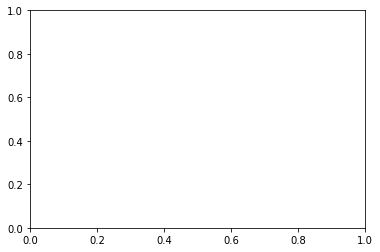

In [44]:
plot_pred_fact(m, "Colorado", df_samples, "20200601", n_days=30)

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0
2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


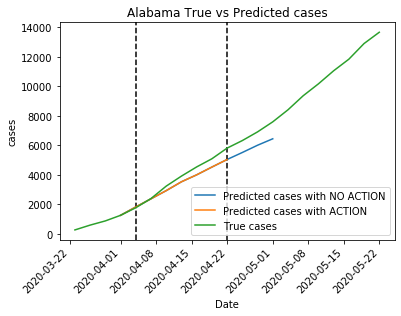

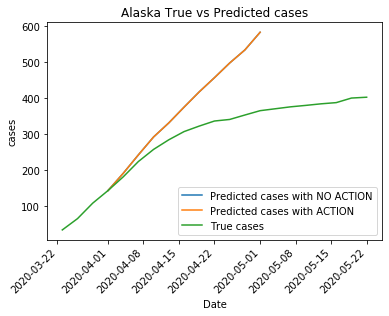

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0
2020-04-25 00:00:00 : Action 1
with action 1  STATE bef: 67.0  STATE aft: 22.0


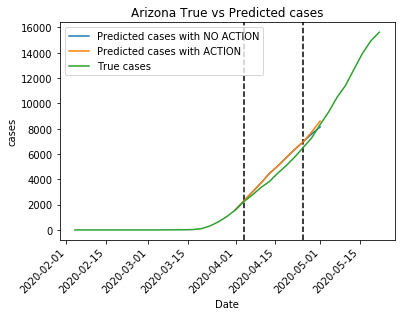

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 71  STATE aft: 39.0
2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


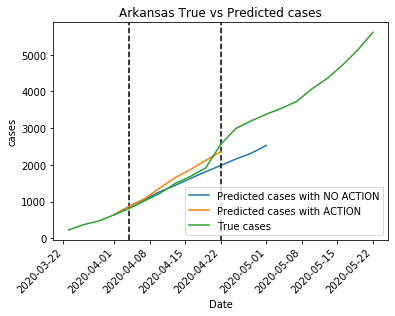

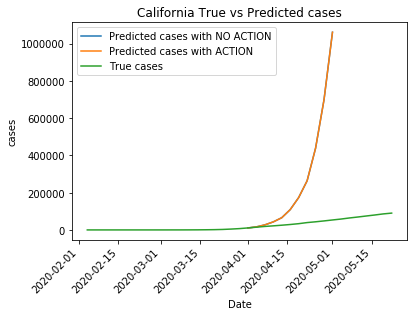

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0


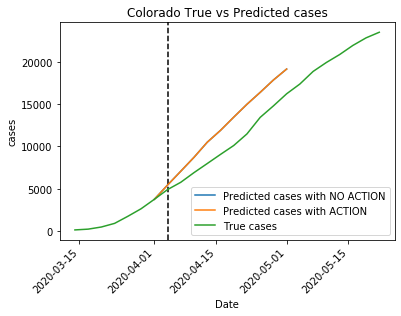

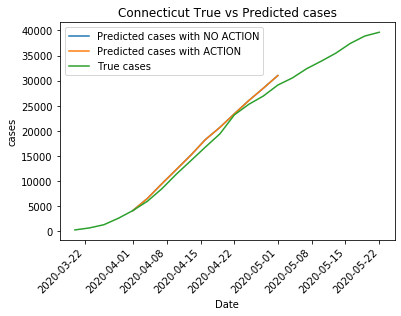

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 80  STATE aft: 24.0


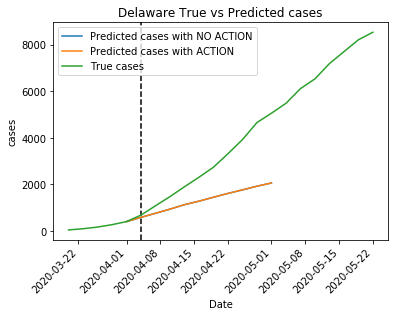

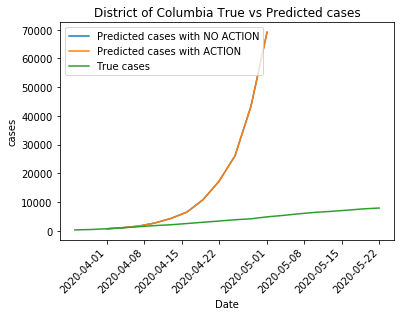

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 80.0  STATE aft: 24.0


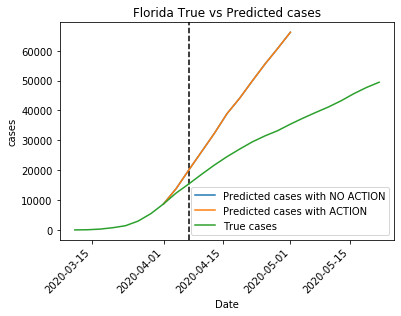

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 82.0  STATE aft: 80.0
2020-04-22 00:00:00 : Action 1
Transition not found: (14.0, 1)


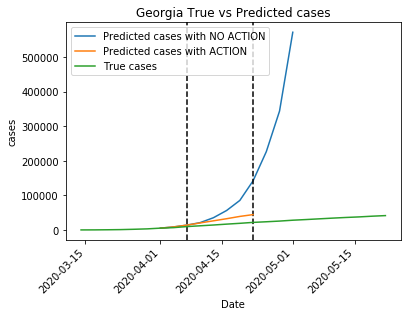

2020-04-22 00:00:00 : Action 1
Transition not found: (74.0, 1)


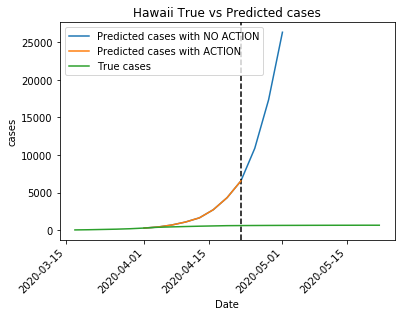

2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 80.0  STATE aft: 24.0
2020-04-19 00:00:00 : Action 1
with action 1  STATE bef: 65.0  STATE aft: 25.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 25.0  STATE aft: 75.0


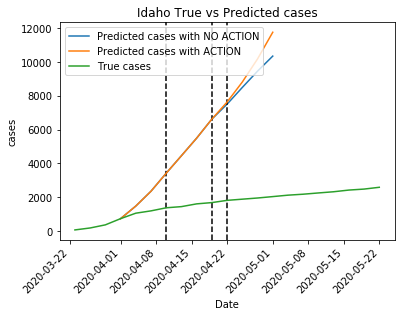

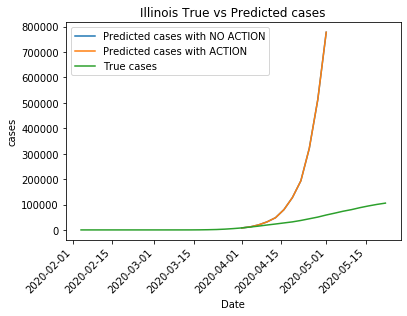

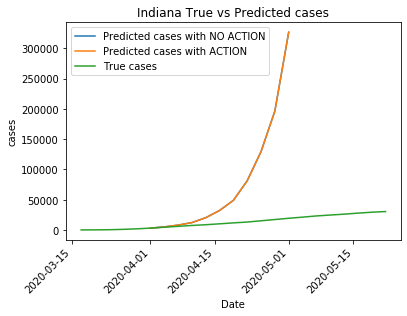

2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


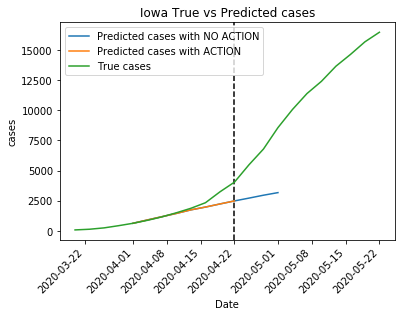

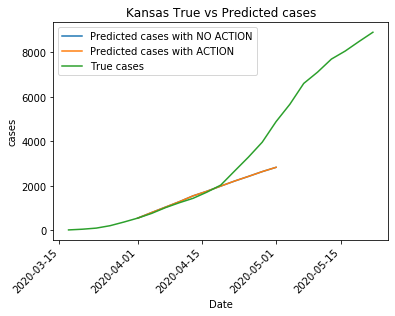

2020-04-19 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0
2020-04-22 00:00:00 : Action 1
Transition not found: (36.0, 1)


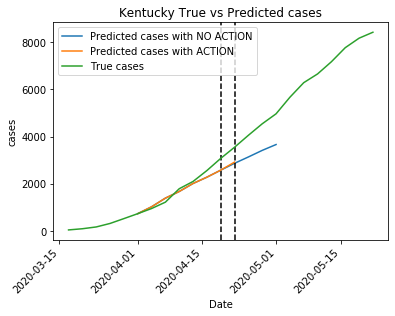

2020-04-22 00:00:00 : Action 1
Transition not found: (14.0, 1)


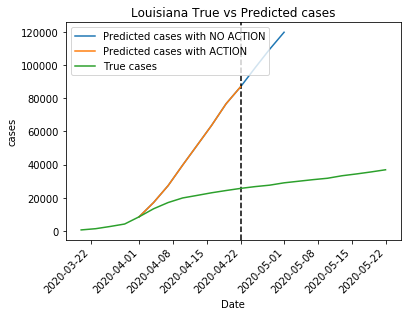

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 81  STATE aft: 59.0
2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 59.0  STATE aft: 77.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 77.0  STATE aft: 75.0
2020-04-19 00:00:00 : Action 1
with action 1  STATE bef: 75.0  STATE aft: 77.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0


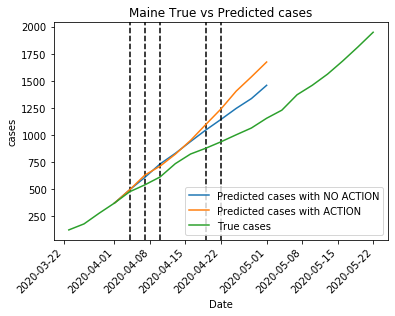

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 4  STATE aft: 0.0
2020-04-07 00:00:00 : Action -1
Transition not found: (0.0, -1)


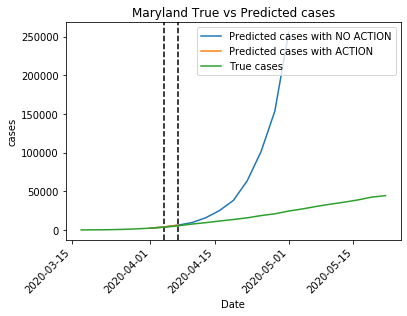

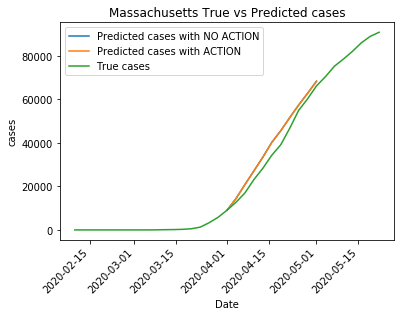

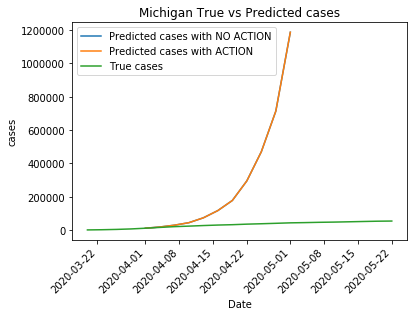

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 24  STATE aft: 78.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 67.0  STATE aft: 22.0


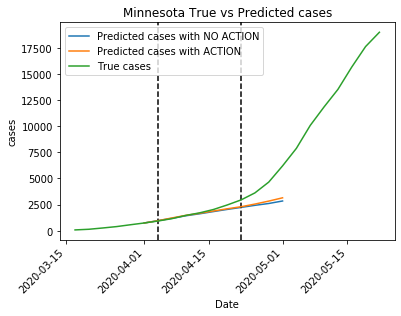

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 71.0  STATE aft: 39.0
2020-04-10 00:00:00 : Action -1
Transition not found: (39.0, -1)


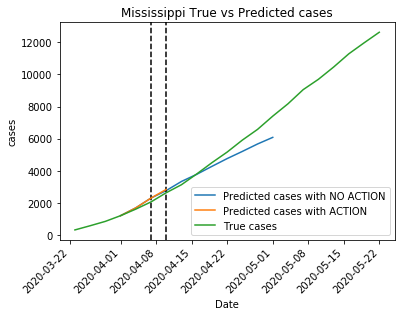

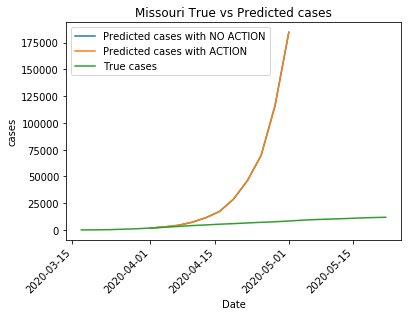

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 81  STATE aft: 59.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0


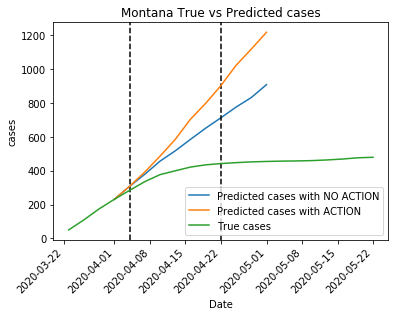

2020-04-22 00:00:00 : Action 1
Transition not found: (29.0, 1)


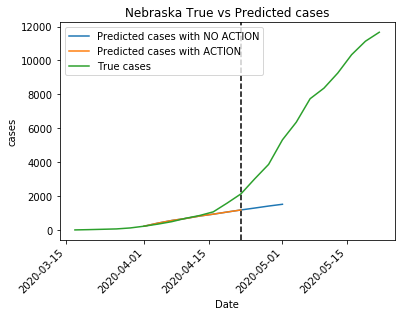

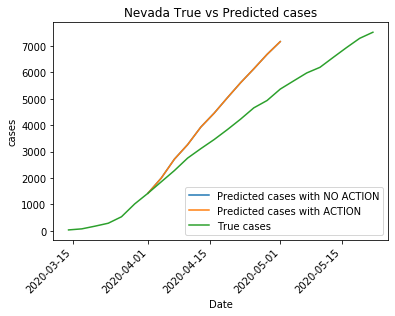

2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 71.0  STATE aft: 39.0


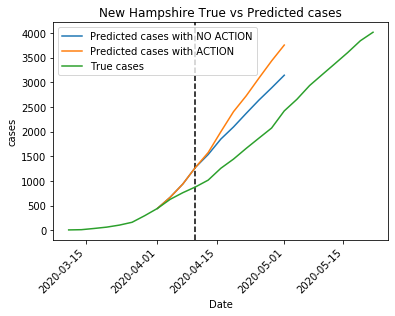

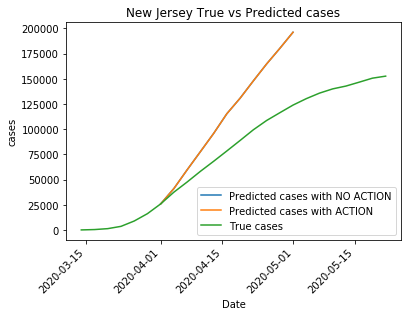

2020-04-22 00:00:00 : Action 1
Transition not found: (74.0, 1)


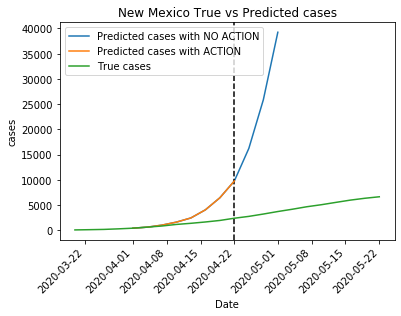

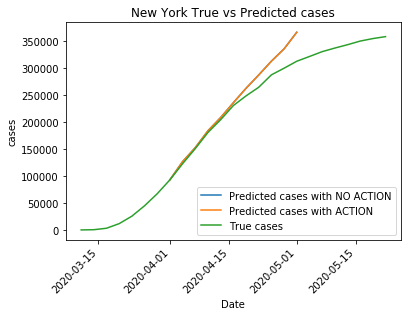

2020-04-04 00:00:00 : Action -1
Transition not found: (1, -1)


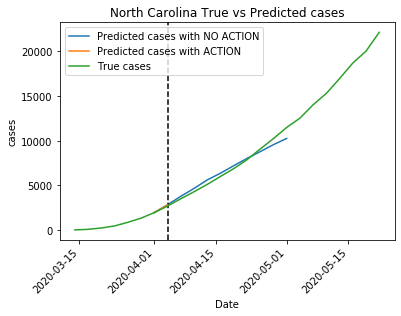

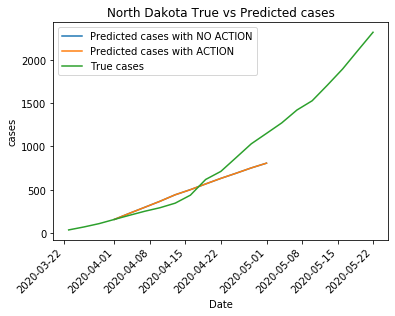

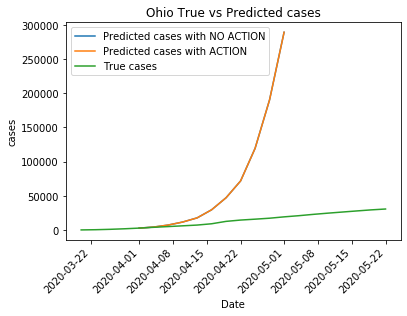

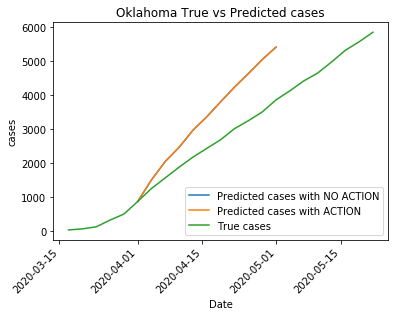

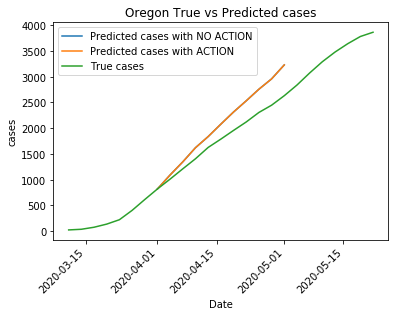

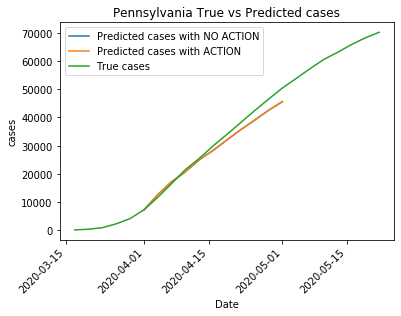

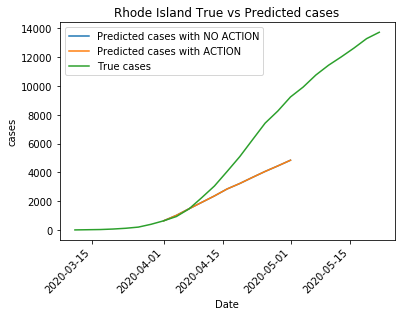

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 4  STATE aft: 0.0
2020-04-07 00:00:00 : Action -1
Transition not found: (0.0, -1)


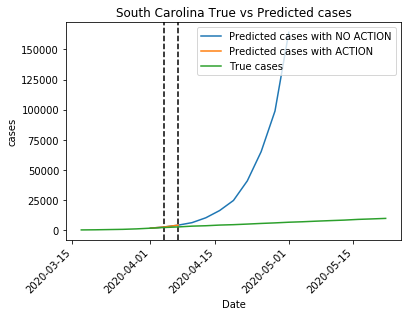

2020-04-22 00:00:00 : Action 1
Transition not found: (82.0, 1)


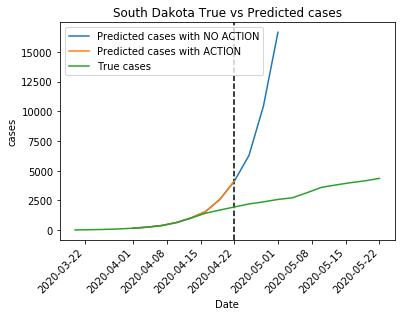

2020-04-07 00:00:00 : Action -1
with action -1  STATE bef: 26.0  STATE aft: 24.0
2020-04-10 00:00:00 : Action -1
with action -1  STATE bef: 24.0  STATE aft: 78.0
2020-04-22 00:00:00 : Action 1
with action 1  STATE bef: 77.0  STATE aft: 36.0


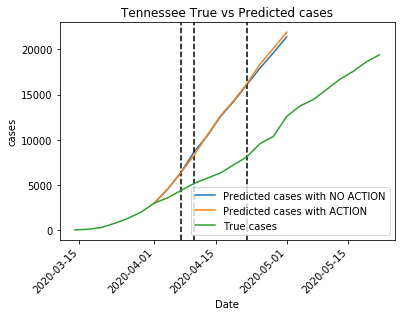

2020-04-28 00:00:00 : Action 1
with action 1  STATE bef: 67.0  STATE aft: 22.0


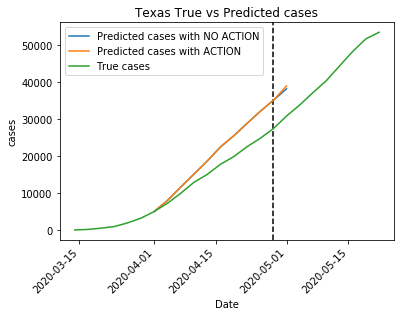

2020-04-28 00:00:00 : Action 1
Transition not found: (76.0, 1)


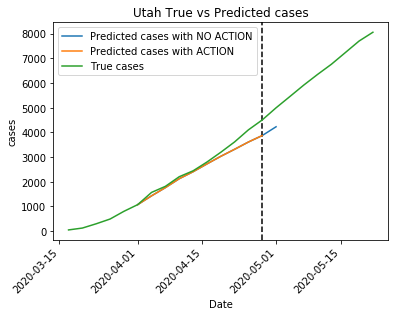

2020-04-04 00:00:00 : Action -1
with action -1  STATE bef: 81  STATE aft: 59.0
2020-04-10 00:00:00 : Action -1
Transition not found: (51.0, -1)


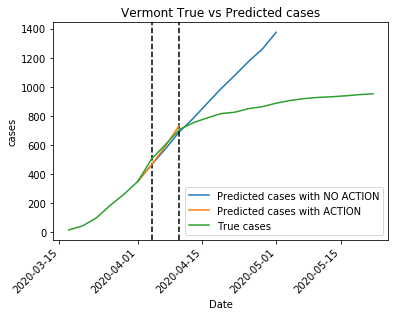

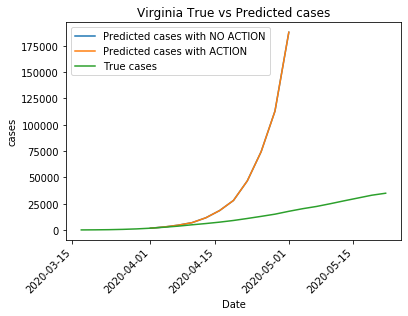

2020-04-04 00:00:00 : Action -1
Transition not found: (15, -1)


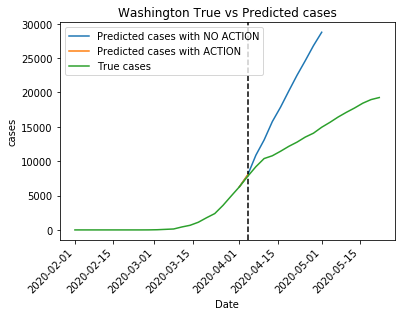

2020-04-19 00:00:00 : Action 1
Transition not found: (82.0, 1)


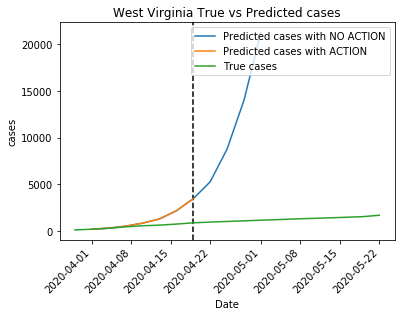

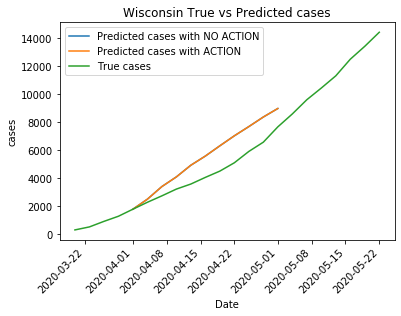

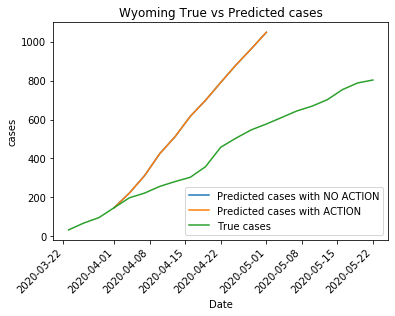

In [52]:
for region in m.df_trained.index:
    plot_pred_fact(m, region, df_samples, "20200401", n_days=30)

In [29]:
m.P_df.shape[0] % 29

10

In [46]:
m.P_df.head(45)

NEXT_CLUSTER
CLUSTER ACTION              
0       -1               1.0
         0               1.0
1       -1              24.0
         0              28.0
         1              28.0
2       -1               5.0
         0               0.0
3       -1               3.0
         0               3.0
         1              22.0
4       -1               0.0
         0               0.0
5       -1               4.0
         0               0.0
6       -1               6.0
         0              13.0
         1               6.0
7       -1              25.0
         0               7.0
         1               7.0
8       -1               1.0
         0              26.0
9       -1              14.0
         0              14.0
         1               3.0
10      -1               0.0
         0               0.0
11      -1               7.0
         0               7.0
12      -1              12.0
         0              12.0
         1               6.0
13      -1              12.0
         0              12.0
         1              13.0
14      -1               3.0
         0              14.0
         1               3.0
15      -1               9.0
         0               9.0
16      -1              11.0
         0              11.0
17       0              20.0
18      -1              18.0
         0              10.0

In [47]:
df_samples[df_samples.state=="Colorado"]

ID       TIME  mobility_score_trend  cases_pct3  cases_pct5  \
137   5 2020-03-14           6635.000000    1.623008    6.106209   
138   5 2020-03-17           6512.619048    0.697214    2.067651   
139   5 2020-03-20           6149.142857    1.109478    1.959382   
140   5 2020-03-23           5823.619048    0.911051    2.204687   
141   5 2020-03-26           5513.380952    0.926539    1.927386   
142   5 2020-03-29           5252.380952    0.521534    1.340524   
143   5 2020-04-01           5108.476190    0.424687    0.846596   
144   5 2020-04-04           4924.857143    0.311923    0.652502   
145   5 2020-04-07           4838.238095    0.176098    0.390005   
146   5 2020-04-10           4851.142857    0.198919    0.330534   
147   5 2020-04-13           4900.000000    0.156047    0.304689   
148   5 2020-04-16           5064.095238    0.135098    0.241087   
149   5 2020-04-19           5240.380952    0.116253    0.217473   
150   5 2020-04-22           5402.428571    0.134959    0.219379   
151   5 2020-04-25           5495.666667    0.171641    0.280062   
152   5 2020-04-28           5517.238095    0.101055    0.217371   
153   5 2020-05-01           5489.476190    0.096989    0.168669   
154   5 2020-05-04           5520.857143    0.071192    0.137252   
155   5 2020-05-07           4614.809524    0.085474    0.136401   
156   5 2020-05-10           2927.285714    0.056267    0.115527   
157   5 2020-05-13           1831.095238    0.046918    0.080215   
158   5 2020-05-16           1860.380952    0.051677    0.086979   
159   5 2020-05-19           1731.273810    0.040982    0.074874   
160   5 2020-05-22           1570.984694    0.044702    0.070608   

     mobility_score_trend-1  mobility_score_trend-2  cases_pct3-1  \
137             6600.190476             6902.809524      3.307190   
138             6635.000000             6600.190476      1.623008   
139             6512.619048             6635.000000      0.697214   
140             6149.142857             6512.619048      1.109478   
141             5823.619048             6149.142857      0.911051   
142             5513.380952             5823.619048      0.926539   
143             5252.380952             5513.380952      0.521534   
144             5108.476190             5252.380952      0.424687   
145             4924.857143             5108.476190      0.311923   
146             4838.238095             4924.857143      0.176098   
147             4851.142857             4838.238095      0.198919   
148             4900.000000             4851.142857      0.156047   
149             5064.095238             4900.000000      0.135098   
150             5240.380952             5064.095238      0.116253   
151             5402.428571             5240.380952      0.134959   
152             5495.666667             5402.428571      0.171641   
153             5517.238095             5495.666667      0.101055   
154             5489.476190             5517.238095      0.096989   
155             5520.857143             5489.476190      0.071192   
156             4614.809524             5520.857143      0.085474   
157             2927.285714             4614.809524      0.056267   
158             1831.095238             2927.285714      0.046918   
159             1860.380952             1831.095238      0.051677   
160             1731.273810             1860.380952      0.040982   

     cases_pct3-2  cases_pct5-1  cases_pct5-2       r_t         r_t-1  \
137      1.541667      5.708333      7.500000  2.484472     53.666667   
138      3.307190      6.106209      5.708333  1.692500    133.333333   
139      1.623008      2.067651      6.106209  2.118168    225.666667   
140      0.697214      1.959382      2.067651  1.898187    478.000000   
141      1.109478      2.204687      1.959382  1.921014    907.333333   
142      0.911051      1.927386      2.204687  1.510996   1743.000000   
143      0.926539      1.340524      1.927386  1.422984   2633.6666

In [38]:
def plot_pred_fact(model, state, df_w_act, starting_date, n_days=30):

    fig, ax = plt.subplots()

    try :
        starting_date = datetime.strptime(starting_date, "%Y%m%d")
    except:
        pass

    df_state = df_w_act[df_w_act[model.region_colname] == state].reset_index().drop("index", axis=1)

    first_date = df_state["TIME"].min()

    starting_n_days = int((starting_date - first_date).days)
    try:
        assert starting_n_days >= 0
    except AssertionError:
        print(" the given starting_date {} occurs before the first date {} of the given data set".format(str(starting_date),
                                                                                                         str(first_date)))
        raise AssertionError

    h = int(np.round(n_days/model.days_avg))
    h_start = int(np.floor(starting_n_days/model.days_avg))

    date = df_state.iloc[h_start]["TIME"]
    target = df_state.iloc[h_start][model.target_colname]

    # predict the current state
    date_features = df_state.iloc[h_start, 2:(2+model.pfeatures)].values.reshape((1, -1))
    s_init = model.classifier.predict(date_features)[0]

    # prediction ACTION = 0
    s = s_init
    dates = [date]
    targets_pred = [target]
    r = 1.
    for i in range(h):
        dates.append(date + timedelta((i+1)*model.days_avg))
        r = r*np.exp(model.R_df.loc[s])
        targets_pred.append(target*r)
        try:
            s = model.P_df.loc[s, 0].values[0]
        except TypeError:
            print("Transition not found:", (s, 0))
            break

    ax.plot(dates, targets_pred, label='Predicted '+model.target_colname+ ' with NO ACTION')

    # prediction with adaptive ACTION
    s = s_init
    dates = [date]
    targets_pred = [target]
    r = 1.
    for i in range(h):
        dates.append(date + timedelta((i+1)*model.days_avg))
        r = r*np.exp(model.R_df.loc[s])
        targets_pred.append(target*r)

        try:
            a = df_state.iloc[(h_start+i)]["ACTION"]
        except:
#             print(state)
#             print("sdays:", starting_n_days)
#             print("current:", starting_n_days+i)
#             print("previous day:", df_state.iloc[(starting_n_days+i-1)])
#             print("dates:", dates)
            break

        if a != 0:
            print("{} : Action {}".format(dates[-1], a))
            ax.axvline(dates[-1], color='k', linestyle='--')
        try:
            s_bf = s
            s = model.P_df.loc[s, a].values[0]
            if a != 0:
                print("with action {}".format(a)," STATE bef:", s_bf, " STATE aft:", s)
        except TypeError:
            print("Transition not found:", (s, a))
            break

    ax.plot(dates, targets_pred, label='Predicted '+model.target_colname+ ' with ACTION')

    ax.plot(df_state["TIME"], \
            df_state[model.target_colname], \
            label = 'True '+model.target_colname)
    ax.set_title('%s True vs Predicted '%state + model.target_colname)
    ax.set_xlabel('Date')
    ax.set_ylabel(model.target_colname)
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show(block=False)
#############################################################################

In [59]:
m.P_df

TRANSITION_CLUSTER
CLUSTER ACTION                    
0       0                      1.0
1       0                      1.0
2       0                      2.0
3       0                      7.0
4       0                      4.0
5       0                      5.0
6       0                     21.0
7       0                     12.0
8       0                     22.0
9       0                      4.0
10      0                      7.0
11      0                      3.0
12      0                      6.0
13      0                     16.0
14      0                      2.0
15      0                     19.0
16      0                      2.0
17      0                     17.0
18      0                     11.0
19      0                      3.0
20      0                      8.0
21      0                      8.0
22      0                      5.0
23      0                     22.0
24      0                     14.0
25      0                      8.0
26      0                      7.0
27      0                      8.0
28      0                     17.0
29      0                     29.0

In [60]:
m.R_df

EST_RISK
CLUSTER          
0        0.050658
1        0.013250
2        0.102683
3        0.716437
4        0.067827
5        0.184799
6        0.423901
7        0.504678
8        0.292464
9        0.084097
10       0.655861
11       0.859762
12       0.471792
13       0.234706
14       0.124484
15       1.547902
16       0.161875
17       0.033695
18       1.026300
19       1.247489
20       0.326349
21       0.353444
22       0.209236
23       0.263794
24       0.142448
25       0.548811
26       0.594195
27       0.380063
28       0.018697
29       0.049792